# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [75]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from spacymoji import Emoji
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial
from gensim.models import FastText  
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
import gensim.downloader as api
import numpy as np
import tensorflow as tf
#Load Packages
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Bidirectional
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import joblib


warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [2]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [3]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [4]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [5]:
df.shape

(1600000, 6)

In [6]:
df.head(2)

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

In [7]:
df = df.drop([3], axis=1)

In [8]:
df.head(2)

0           1                             2                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

In [9]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [10]:
df.shape

(1600000, 5)

In [11]:
df.head(2)

target    identity                          date         username  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  _TheSpecialOne_   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009    scotthamilton   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...

#### Nous conservons uniquement les classes positives et négatives 

In [12]:
part1 = df.loc[df["target"]==0]

In [13]:
part1 = part1.sample(800)

In [14]:
part2 = df.loc[df["target"]==4]

In [15]:
part2 = part2.sample(800)

In [16]:
df = pd.concat([part1, part2])

In [17]:
df.shape

(1600, 5)

### Export csv

In [170]:
df.to_csv("output/sample.csv")

In [4]:
df = pd.read_csv("output/sample.csv")

In [5]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [6]:
sum(df.duplicated())

0

In [7]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  
0  @drallenlubell do know anything about sphincte...  
1  its not lookin good Mr. Sun, its not lookin good

Vérification des données manquantes

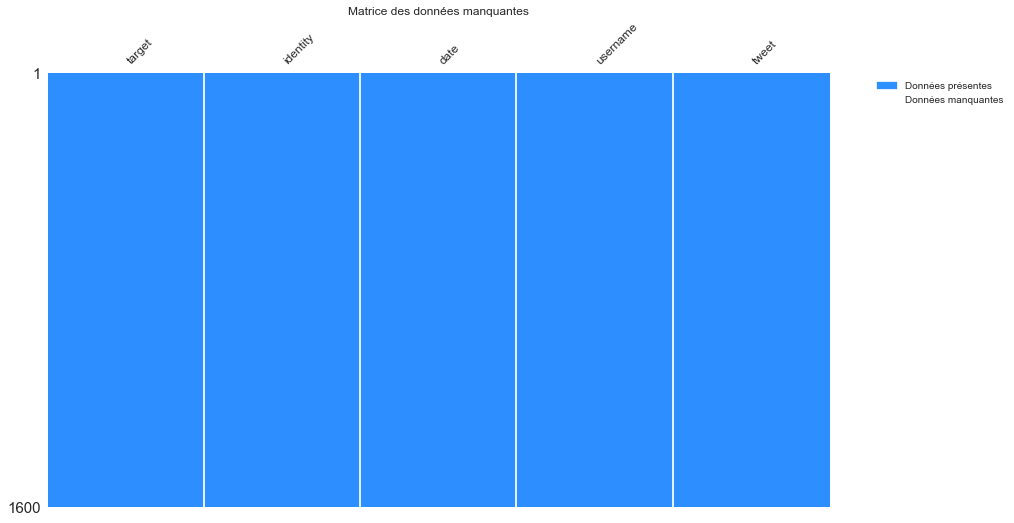

In [12]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [13]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  
0  @drallenlubell do know anything about sphincte...  
1  its not lookin good Mr. Sun, its not lookin good

Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative, 2 = neutral et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [6]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    elif target == 2:
        return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [372]:
df.head(5)

target    identity                          date      username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009     Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009    kawtreenah   
2       0  2064059763  Sun Jun 07 05:05:10 PDT 2009  ohglorymegan   
3       0  2217050969  Wed Jun 17 20:19:28 PDT 2009    brojoghost   
4       0  2265139701  Sun Jun 21 05:53:13 PDT 2009  itsamishmash   

                                               tweet target_lib  
0  @drallenlubell do know anything about sphincte...   Negative  
1  its not lookin good Mr. Sun, its not lookin good    Negative  
2  Emily thought it'd be cool to just take my bla...   Negative  
3  @BlizzardSkies nothing will ever help Iran. We...   Negative  
4  drunk, and missing one of my best friends wedd...   Negative

Etudions notre variable

In [7]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

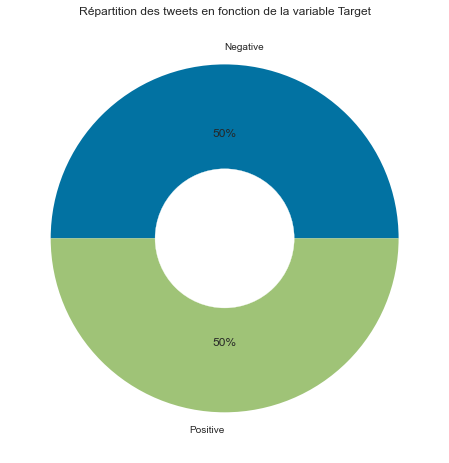

In [374]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est à peu près équilibrée. En effet, nous retrouvons 57% de tweets avec un sentiment positif, contre 43% avec un sentiment negatif.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

In [8]:
gc.collect()

60

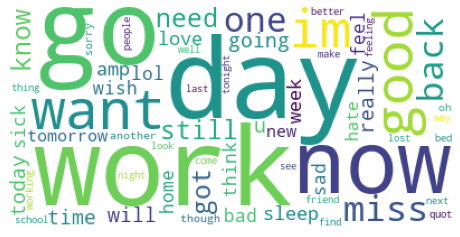

In [376]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet"])

Nous avons ici des mots plutôt négatifs avec oh, never, horrible, burnt, byye, sorry, work, go.

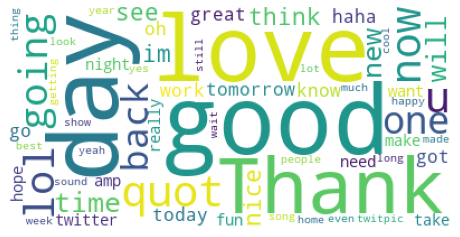

In [377]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet"])

Nous retrouvons des mots positifs avec thank, good, well, yeah, love...

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [378]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet target_lib  
0  @drallenlubell do know anything about sphincte...   Negative  
1  its not lookin good Mr. Sun, its not lookin good    Negative

In [379]:
df["tweet"][0]

"@drallenlubell do know anything about sphincter of oddi dysfunction? If so, can you pls send me a link? Dx'd but unable to do ERCP "

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

!!!!!!!!!!!!!!!!!Pour rappel, dans le pipeline de spacy nous avons :
-'tok2vec',
-'tagger',
-'parser',
-'attribute_ruler',
-'lemmatizer',
-'ner'

In [57]:
nlp = spacy.load("en_core_web_sm")
_ = nlp.add_pipe("emoji", first=True)

In [58]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [59]:
gc.collect()

10081

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [60]:
doc = nlp("Dr. Alex Smith :-) 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji) for token in doc])

[('Dr.', False), ('Alex', False), ('Smith', False), (':-)', False), ('😂', True), ('not', False), ('chaired', False), ('LMAO', False), ('first', False), ('board', False), ('meeting', False), ('of', False), ('Acme', False), ('Corp', False), ('Inc.', False), ('titi@gmail.com', False), ('<', False), ('https://t.co', False), ('>', False), ('Re', False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

!!!!!!!!!!!!!!!!!!!! problem ROFL | LOL | LMAO + :) :(

In [61]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('not', False, False, None, False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [62]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

print(len(stopwords))
print(stopwords)

276
{'all', '‘d', 'with', 'so', 'there', 'to', 'anything', 'seemed', 'become', 'make', 'name', 'fifty', 'by', 'over', 'thus', 'therefore', 'from', 'the', 'of', 'he', 'on', 'regarding', 'beforehand', '‘s', "'ve", 'nor', 'what', 'we', 'it', 'which', 'two', 'and', 'whither', 'other', 'last', 'your', '’d', 'yours', 'in', 'during', 'nine', 'now', 'seem', 'toward', 'thru', 'thence', 'our', 'where', 'keep', 'due', 'while', 'yourselves', 'above', 'such', 'besides', 'since', 'up', 'whether', 'whose', 'whenever', 'nobody', 'least', 'ten', 'seeming', 'quite', 'thereupon', '’ve', 'within', 'anyway', 'anyone', 'therein', 'i', "'s", 'nevertheless', 'doing', 'cannot', 'forty', 'below', 'wherever', '‘m', 'when', '’m', 'indeed', 'against', 'her', 'somewhere', 'n’t', 'these', '’s', 'six', 'otherwise', 'hereupon', 'across', 'his', 'here', 'eleven', 'done', 'be', 'once', 'say', 'yourself', 'an', 'do', 'empty', 'ours', 'show', 'every', 'four', 'itself', 'everywhere', 'third', 'hereafter', "'re", 'go', 'whe

In [63]:
nlp.Defaults.stop_words.add("re")

In [64]:
nlp.Defaults.stop_words -= {"not", "no", "n't", "would", "without", "could", "still", "ever", 
                            "yet", "almost", "should", "always", "too", "sometimes", "except", 
                            "everything", "really", "nothing", "down", "also", "very", "most", "'d", 
                            "serious", "than", "however", "well", "neither", "anyhow", "few",
                            "rather", "mostly", "none", "must", "less", "many", "as", "often", 
                            "never", "enough", "much", "out", "but", "whereas", "netherrless",
                            "next", "even", "although", "why", "again", "perhaps"}

In [65]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('not', False, False, None, False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [66]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [67]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [68]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            if token._.emoji_desc != " ":
                new_words.append(token._.emoji_desc)
            else:
                continue
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [69]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [70]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [71]:
nlp.pipe_names

['emoji',
 'pre_process_text',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [72]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [73]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [74]:
test = stemming_function(doc)

Dr.
Alex
Smith
face with tears of joy
not
chaired
LMAO
board
meeting
Acme
Corp
Inc.
<
>


In [75]:
doc.text

'Dr. Alex Smith face with tears of joy not chaired LMAO board meeting Acme Corp Inc. < > '

In [76]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'not',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [77]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [78]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [79]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
face with tears of joy
not
chair
lmao
board
meet
acm
corp
inc.
<
>


In [80]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [81]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/1589 [00:00<?, ?it/s]

In [82]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/1589 [00:00<?, ?it/s]

In [83]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                          tweet_stem  \
0  [know, sphincter, oddi, dysfunct, pls, send, l...   
1   [not, lookin, good, mr., sun, not, lookin, good]   

                                    tweet_lemma_join  \
0  know sphincter oddi dysfunction pls send link ...   
1                    lookin good Mr. Sun lookin good   

                                     tweet_stem_join target_lib  
0  know sphincter oddi dysfunct pls send link dx'...   Negative  
1                    lookin good mr. sun lookin good   Negative

Nous ne supprimons pas les # car on peut avoir des #encolere

In [84]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

HASHTAG 7 9 ##
HASHTAG 8 10 ##
HASHTAG 9 11 #toto


In [85]:
df.head(3)

target    identity                          date      username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009     Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009    kawtreenah   
2       0  2064059763  Sun Jun 07 05:05:10 PDT 2009  ohglorymegan   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    
2  Emily thought it'd be cool to just take my bla...   

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   
2  (Emily, thought, 'd, cool, blanket, pillow, co...   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   
2  [Emily, think, would, cool, blanket, pillow, c...   

                                          tweet_stem  \
0  [know, sphincter, oddi, dysfunct, pls, send, l...   
1   [not, lookin, good, mr., sun, not, lookin, good]   
2  [emili, thought, 'd, cool, blanket, pillow, co...   

                                    tweet_lemma_join  \
0  know sphincter oddi dysfunction pls send link ...   
1                    lookin good Mr. Sun lookin good   
2          Emily think cool blanket pillow come help   

                                     tweet_stem_join target_lib  
0  know sphincter oddi dysfunct pls send link dx'...   Negative  
1                    lookin good mr. sun lookin good   Negative  
2        emili thought cool blanket pillow come help   Negative

In [38]:
gc.collect()

8200

#### Retraçons les wordcloud par classe et par methode stem / lemma

In [86]:
df["tweet_lemma_join"] = df["tweet_lemma"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [87]:
df["tweet_stem_join"] = df["tweet_stem"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [88]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                          tweet_stem  \
0  [know, sphincter, oddi, dysfunct, pls, send, l...   
1   [not, lookin, good, mr., sun, not, lookin, good]   

                                    tweet_lemma_join  \
0  know sphincter oddi dysfunction pls send link ...   
1            not lookin good Mr. Sun not lookin good   

                                     tweet_stem_join target_lib  
0  know sphincter oddi dysfunct pls send link dx'...   Negative  
1            not lookin good mr. sun not lookin good   Negative

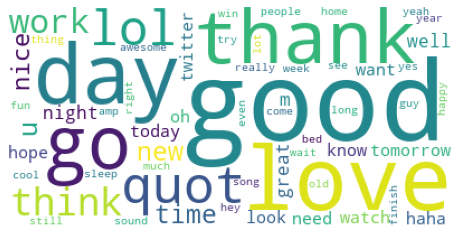

In [89]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_lemma_join"])

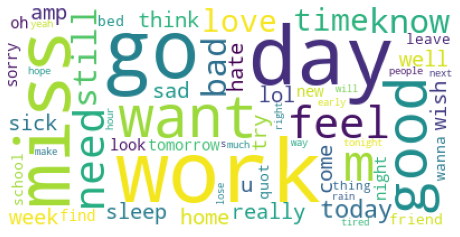

In [90]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_lemma_join"])

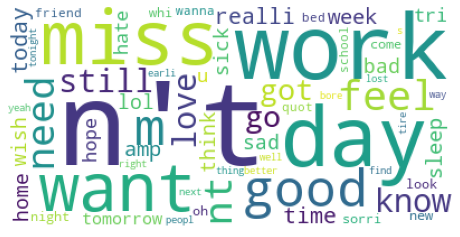

In [91]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_stem_join"])

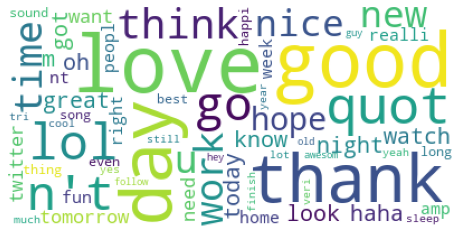

In [92]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_stem_join"])

Nous conservons donc la méthode de lemmatisation. Nous pouvons supprimer les colonnes contenant les données de stemming.

In [93]:
df = df.drop(["tweet_stem", "tweet_stem_join"], axis=1)

In [94]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                    tweet_lemma_join target_lib  
0  know sphincter oddi dysfunction pls send link ...   Negative  
1            not lookin good Mr. Sun not lookin good   Negative

La technique de lemmatization supprime surement des commentaires qui n'ont pas de sens tel que "I will go".
Nous supprimons donc les lignes vides.

In [95]:
df = df.loc[df["tweet_lemma"] != np.array(0)]

In [96]:
df.shape

(1589, 9)

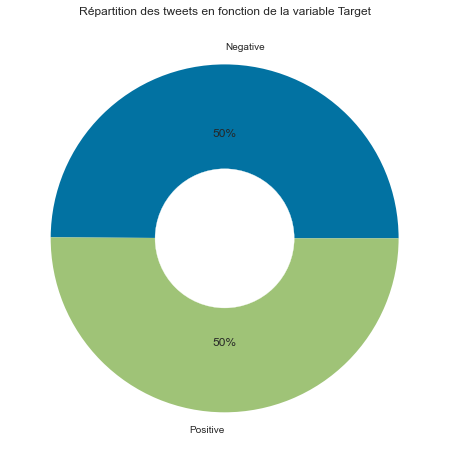

In [97]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

- Algorithme pour l'incorporation de mots :
- Prétraitez les données textuelles.
- Créé le dictionnaire.
- Parcourir le fichier glove d'une dimension précise et comparer chaque mot avec tous les mots du dictionnaire,
- si une correspondance se produit, copiez le vecteur équivalent du gant et collez-le dans embedding_matrix à l'index correspondant.

La matrice d'intégration est une matrice dont la taille de ligne est égale au nombre de mots uniques dans le document et dont la taille de colonne correspond à la dimension du vecteur d'intégration. Ainsi, afin de construire une matrice d'intégration, il faut soit créer les vecteurs d'intégration de mots, soit utiliser des intégrations de mots pré-formés. Dans cet exemple, nous allons lire un fichier d'incorporation de mots fictifs et construire la matrice.

In [7]:
df.head(2)

Unnamed: 0  target    identity                          date    username  \
0           0     0.0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1           1     0.0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  know sphincter oddi dysfunction pls send link ...   
1           not lookin good Mr. Sun not lookin good    

                                         tweet_lemma  \
0  ['know', 'sphincter', 'oddi', 'dysfunction', '...   
1  ['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...   

                                    tweet_lemma_join target_lib  cg_positive  \
0  know sphincter oddi dysfunction pls send link ...   Negative         0.01   
1            not lookin good Mr. Sun not lookin good   Negative         0.01   

   cg_neutral  cg_negative  
0        0.21         0.78  
1        0.00         0.99

In [20]:
df["tweet_lemma"][0]

'[\'know\', \'sphincter\', \'oddi\', \'dysfunction\', \'pls\', \'send\', \'link\', "Dx\'d", \'but\', \'unable\', \'ERCP\']'

In [8]:
import numpy as np


class Embeddings():
    """
    A class to read the word embedding file and to create the word embedding matrix
    """

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [79]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2[["tweet_lemma_join"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

In [90]:
X_train = df["tweet_lemma_join"]# Texte 


In [91]:
X_train

0       know sphincter oddi dysfunction pls send link ...
1                 not lookin good Mr. Sun not lookin good
2         Emily think would cool blanket pillow come help
3          nothing ever help Iran give illusion help Iran
4       drunk miss good friend wed love side drunk kin...
                              ...                        
1584    naah sweet person never harm hope say nice rit...
1585    got nail look like zebra not sound cute but re...
1586                                           follow Mya
1587    closed phone finger hurt like bitch lol go bed...
1588    not wait tomorrow breakfast car ride massage g...
Name: tweet_lemma_join, Length: 1589, dtype: object

In [92]:
Y_train = df["target"] # Libellé

In [93]:
X_train.shape

(1589,)

In [94]:
Y_train.shape

(1589,)

In [95]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
embed_path = 'Input\\embeddings\\glove.6B\\glove.6B.300d.txt' #glove.6B.300d
embed_dim = 300


In [18]:
# Creating the embedding matrix
embedding = Embeddings(embed_path, embed_dim)
embedding_matrix_glove = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [19]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0083903 ,  0.28769001, -0.23466   , ..., -0.66409999,
         0.10303   ,  0.1219    ],
       [-0.0093601 ,  0.22789   , -0.10275   , ..., -0.51568002,
        -0.035701  ,  0.0074737 ],
       ...,
       [-0.13891   , -0.083528  , -0.11974   , ...,  0.40112999,
         0.24844   ,  0.96111   ],
       [-0.11415   ,  0.33406001,  0.084096  , ...,  0.50097001,
        -0.064236  ,  0.10605   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Passons à Fasttext

In [20]:
fasttext = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

In [21]:
class Embeddings_Model():
    """
    A class to read the word embedding model and to create the word embedding matrix
    """

    def __init__(self, model, vector_dimension):
        self.model = model 
        self.vector_dimension = vector_dimension

    def get_embedding_index(self):
        embeddings_index = self.model
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [22]:
# Creating the embedding matrix
embedding = Embeddings_Model(fasttext, embedding_dim)
embedding_matrix_fasttext = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [23]:
embedding_matrix_fasttext.shape

(3622, 300)

Nous avons créé deux embeddings, nous pouvons donc essayer à présent de trouver un modèle.

## Recherche d'un modèle avancé

Commençons par réaliser un modèle simple

### Réseau de neurone simple

In [96]:
X_train

0       know sphincter oddi dysfunction pls send link ...
1                 not lookin good Mr. Sun not lookin good
2         Emily think would cool blanket pillow come help
3          nothing ever help Iran give illusion help Iran
4       drunk miss good friend wed love side drunk kin...
                              ...                        
1584    naah sweet person never harm hope say nice rit...
1585    got nail look like zebra not sound cute but re...
1586                                           follow Mya
1587    closed phone finger hurt like bitch lol go bed...
1588    not wait tomorrow breakfast car ride massage g...
Name: tweet_lemma_join, Length: 1589, dtype: object

In [25]:
vocab_size = len(tokenizer.word_index) + 1

Notre modèle simple sera composé :
- des poids de l'embedding sans entrainement, 
- d'une couche dense, 
- d'une couche dropout avec un taux à 0.2/0.5, 
- d'une couche Flatten (pour créer un vecteur de caractéristiques unique)
- et d'une couche dense avec une fonction d'activation sigmoid.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Pour rappel :
- Une couche dense est un vecteur de dimension « m ». Ainsi, la couche dense est essentiellement utilisée pour modifier les dimensions du vecteur. Les couches denses appliquent également des opérations telles que la rotation, la mise à l'échelle, la translation sur le vecteur.
- Une couche dropout permet de reguler overffiting en desactivant certains neurones
- La fonction d'activation permet de modifier spatialement la représentation des données

In [39]:
# dense(activation), dropout(%), flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(32, input_dim=3622, activation='sigmoid'))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])

In [122]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 115, 300)          1086600   
                                                                 
 dense_8 (Dense)             (None, 115, 32)           9632      
                                                                 
 dropout_229 (Dropout)       (None, 115, 32)           0         
                                                                 
 flatten_5 (Flatten)         (None, 3680)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 3681      
                                                                 
Total params: 1,099,913
Trainable params: 13,313
Non-trainable params: 1,086,600
_________________________________________________________________


In [120]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2["tweet_lemma_join"].loc[pd.isna(data["target"])==False]
    del data2["target"]
    Y=data["target"].loc[pd.isna(data["target"])==False]
    return X,Y

from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences

class TextToTensor():

    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def string_to_tensor(self, string_list: list) -> list:
        """
        A method to convert a string list to a tensor for a deep learning model
        """    
        string_list = self.tokenizer.texts_to_sequences(string_list)
        string_list = pad_sequences(string_list, maxlen=self.max_len)
        
        return string_list

def ml_step1_ech(df):
        X, Y = ml_pipeline_divide_data(df)
        X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
        return X_train, X_test, y_train, y_test

def ml_step2_ech(X_train, X_test, y_train, y_test):
    max_len = np.max([len(text) for text in X_train])
    TextToTensor_instance = TextToTensor(
            tokenizer=tokenizer,
            max_len=max_len
            )
    X_train = TextToTensor_instance.string_to_tensor(X_train)
    # Creating the padded input for the deep learning model
    # X_train = ml_transform(X_train)
    X_test = TextToTensor_instance.string_to_tensor(X_test)
    # X_test = TextToTensor_instance.string_to_tensor(X_test)
    return X_train, X_test, np.array(y_train), np.array(y_test)
    
def ml_ech(df):
    X_train, X_test, y_train, y_test = ml_step1_ech(df)
    X_train, X_test, y_train, y_test = ml_step2_ech(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test


In [121]:
X_train, X_test, y_train, y_test = ml_ech(df)

In [122]:
X_train.shape

(1112, 115)

In [124]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=113)

Epoch 1/10
10/10 [==============================] - 88s 281ms/step - loss: 1.0027 - auc: 0.5221 - val_loss: 0.7595 - val_auc: 0.5231
Epoch 2/10
10/10 [==============================] - 1s 52ms/step - loss: 0.8145 - auc: 0.5069 - val_loss: 0.7002 - val_auc: 0.4970
Epoch 3/10
10/10 [==============================] - 0s 41ms/step - loss: 0.7997 - auc: 0.4989 - val_loss: 0.7123 - val_auc: 0.5344
Epoch 4/10
10/10 [==============================] - 0s 39ms/step - loss: 0.8645 - auc: 0.4691 - val_loss: 0.7093 - val_auc: 0.5342
Epoch 5/10
10/10 [==============================] - 0s 29ms/step - loss: 0.7553 - auc: 0.5134 - val_loss: 0.7626 - val_auc: 0.5353
Epoch 6/10
10/10 [==============================] - 1s 55ms/step - loss: 0.7879 - auc: 0.5257 - val_loss: 0.7138 - val_auc: 0.5654
Epoch 7/10
10/10 [==============================] - 0s 50ms/step - loss: 0.8423 - auc: 0.4961 - val_loss: 0.7898 - val_auc: 0.5657
Epoch 8/10
10/10 [==============================] - 0s 25ms/step - loss: 0.7322 -

In [70]:
def graph_history_train(history):
    loss_curve = history.history["loss"]
    acc_curve = history.history["auc"]

    loss_val_curve = history.history["val_loss"]
    acc_val_curve = history.history["val_auc"]

    plt.plot(loss_curve, label="Train")
    plt.plot(loss_val_curve, label="Val")
    plt.legend(loc='upper left')
    plt.title("Loss")
    plt.show()

    plt.plot(acc_curve, label="Train")
    plt.plot(acc_val_curve, label="Val")
    plt.legend(loc='upper left')
    plt.title("AUC")
    plt.show()

In [115]:
results = model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 6ms/step - loss: 0.9912 - auc: 0.5406


Créons un pipeline afin de pouvoir tester différentes méthodes et les deux embeddings.

In [192]:
def funct_model_simple(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Dense(32, input_dim=3622, activation='sigmoid'))
    model.add(Dropout(rate=param))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [81]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.5)

In [82]:
models = []
models.append({"method":1, "function":funct_model_simple, "parameters":params_model1})
#models.append({"method":2, model2})

In [83]:
models = pd.DataFrame(models)

In [84]:
models

method                                           function  parameters
0       1  <function funct_model_simple at 0x0000027C4A6F...  [0.2, 0.5]

In [71]:
gc.collect()

328

In [211]:
####score pour fonction metier
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_pred, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    #y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #


In [ ]:
len(params_model1)

2

In [233]:
metric_history = []
test_history_n = []

def pip_search_model(X, y, funct_model, embeddings, X_eval, y_eval):
        auc_fold=[]
        metier_fold=[]
        params = funct_model["parameters"]
        for param in params:    
            j=0        
            for idx, row_embed in embeddings.iterrows():
                name_embed=row_embed["name_embed"]
                embed=row_embed["embed"]
                print("----------------------------------------------")
                print("-----function : ", str(funct_model["function"]))
                print("------------embeddings : ", name_embed)
                print("------------params : ", param)
                t0 = time.time()
                cv = StratifiedKFold(n_splits=3)
                print("X shape : ", X.shape)
                print("y shape : ", y)
                i=0
                for train_idx, test_idx, in cv.split(X, y):
                    X_train, y_train = X[train_idx], y[train_idx]
                    X_test, y_test = X[test_idx], y[test_idx]
                    print("x_train shape : ", X_train.shape)
                    print("y_train shape : ", y_train.shape)
                    print("x_test shape : ", X_test.shape)
                    print("y_test shape : ", y_test.shape)
                    model_v = funct_model["function"]
                    model = model_v(embed, param)
                    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=110)
                    #y_prob = model.predict_classes(X_test)
                    #predict_x=model.predict(X_test)
                    #y_prob=np.argmax(predict_x,axis=1)
                    # On créé un vecteur de prédiction à partir du vecteur de probabilités
                    #y_pred = np.where(y_prob > 0.5, 1, 0) 

                    # Making prediction
                    #predict_x=model.predict(X_test) 
                    #y_pred=np.argmax(predict_x,axis=1)
                    y_pred = np.argmax(model.predict(X_test),axis=1)
                    print("----------------predictions: ", max(y_pred))
                    print(y_pred.shape)
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
                    roc_auc = auc(false_positive_rate, true_positive_rate)
                    metier_c=fmetric_metier(y_test, y_pred)
                    auc_fold.append(float(roc_auc))
                    metier_fold.append(metier_c)
                    graph_history_train(history)
                    print(f'For fold {i}:')
                    print(f'AUC: {roc_auc}')
                    print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
                    print(f'score métier:{metier_c}')
                    i=i+1
                    gc.collect()
                    j=j+1
                time_res=time.time() - t0
                auc_m=float(np.mean(auc_fold))
                metier=np.mean(metier_fold)
                print("---------------------------------------------------------")
                print("---------------------------------------------------------")
                print("function", str(funct_model["function"]))
                print("embed", name_embed)
                print("parametre :", param)
                print("metric auc moyenne :", auc_m)
                print("taux metier moyen :", metier)
                print("temps calcul :", time_res)
                print("---------------------------------------------------------")
                print("---------------------------------------------------------")
                metric_history.append({"method":funct_model["method"], 'model':model, 'function':funct_model["function"], 'auc':auc_m,
                                        'metier':metier, 'time':time_res, "name_embed":name_embed,"embbeding":embed, "parameters":param})

                X_test, y_test = X_eval, y_eval
                results = model.evaluate(X_test,y_test)
                t0 = time.time()
                # Making prediction
                y_pred = np.argmax(model.predict(X_test),axis=1)
                print("-----------------prediction :", max(y_pred))
                print(y_pred.shape)
                #y_prob = model.predict_classes(X_test)
                #y_pred = np.where(y_prob > 0.5, 1, 0) 
                false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
                roc_auc = auc(false_positive_rate, true_positive_rate)
                metier_c=fmetric_metier(y_test, y_pred)
                gc.collect()
                time_res=time.time() - t0
                test_history_n.append({"method":funct_model["method"], 'model':model, 'function':funct_model["function"], 'auc':roc_auc,'metier':metier_c, 'time':time_res,
                                        "name_embedd":name_embed, "embbeding":embed, "parameters":param})
                print(f'For test:{funct_model["method"]}')
                print(f'AUC: {roc_auc}')
                print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
                print(f'score métier:{metier_c}')
                pipeline_training_metrics(y_pred, y_test)

def search_best_model(df, embeddings):
    for idx, row in models.iterrows():
        X_train, X_test, y_train, y_test = ml_ech(df)
        pip_search_model(X_train, y_train, row, embeddings, X_test, y_test)
        
        


In [86]:
df.shape

(1589, 12)

Autre modele simple avec embedding

In [62]:
#dense, activation, flatten, dense
model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(32, input_dim=3622))
###model.add(Flatten())
model.add(Activation('relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(113,activation='softmax'))binary_crossentropy
#model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])

In [63]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 115) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding (None, 115) float32
dense (None, 115, 300) float32
activation (None, 115, 32) float32
flatten (None, 115, 32) float32
dense_1 (None, 3680) float32


[None, None, None, None, None]

In [64]:
df.head(2)

Unnamed: 0  target    identity                          date    username  \
0           0     0.0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1           1     0.0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  know sphincter oddi dysfunction pls send link ...   
1           not lookin good Mr. Sun not lookin good    

                                         tweet_lemma  \
0  ['know', 'sphincter', 'oddi', 'dysfunction', '...   
1  ['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...   

                                    tweet_lemma_join target_lib  cg_positive  \
0  know sphincter oddi dysfunction pls send link ...   Negative         0.01   
1            not lookin good Mr. Sun not lookin good   Negative         0.01   

   cg_neutral  cg_negative  
0        0.21         0.78  
1        0.00         0.99

In [111]:
X_train, X_test, y_train, y_test = ml_ech(df)


In [118]:
X_train.shape

(1112, 115)

In [70]:
df.head(2)

Unnamed: 0  target    identity                          date    username  \
0           0     0.0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1           1     0.0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  know sphincter oddi dysfunction pls send link ...   
1           not lookin good Mr. Sun not lookin good    

                                         tweet_lemma  \
0  ['know', 'sphincter', 'oddi', 'dysfunction', '...   
1  ['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...   

                                    tweet_lemma_join target_lib  cg_positive  \
0  know sphincter oddi dysfunction pls send link ...   Negative         0.01   
1            not lookin good Mr. Sun not lookin good   Negative         0.01   

   cg_neutral  cg_negative  
0        0.21         0.78  
1        0.00         0.99

In [73]:
y_train.shape

(1112,)

In [74]:
X_test.shape

(477, 115)

In [75]:
y_test.shape

(477,)

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 300)          1086600   
                                                                 
 dense (Dense)               (None, 115, 32)           9632      
                                                                 
 activation (Activation)     (None, 115, 32)           0         
                                                                 
 flatten (Flatten)           (None, 3680)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3681      
                                                                 
Total params: 1,099,913
Trainable params: 13,313
Non-trainable params: 1,086,600
_________________________________________________________________


In [77]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=113)

Epoch 1/10
10/10 [==============================] - 3s 55ms/step - loss: 0.6919 - auc: 0.5415 - val_loss: 0.6933 - val_auc: 0.5414
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6861 - auc: 0.6394 - val_loss: 0.6922 - val_auc: 0.5432
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6806 - auc: 0.6641 - val_loss: 0.6894 - val_auc: 0.5531
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6740 - auc: 0.6693 - val_loss: 0.6861 - val_auc: 0.5666
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6653 - auc: 0.6949 - val_loss: 0.6836 - val_auc: 0.5868
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6570 - auc: 0.7198 - val_loss: 0.6816 - val_auc: 0.6043
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6477 - auc: 0.7338 - val_loss: 0.6794 - val_auc: 0.6199
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.6381 - a

In [78]:
history.history

{'loss': [0.6919442415237427,
  0.6860557198524475,
  0.6805816888809204,
  0.674047589302063,
  0.6653037667274475,
  0.6570191979408264,
  0.647661030292511,
  0.6381126046180725,
  0.6264355778694153,
  0.6171016693115234],
 'auc': [0.5414789319038391,
  0.6393652558326721,
  0.664057731628418,
  0.6692659258842468,
  0.6948825120925903,
  0.7197514176368713,
  0.7337913513183594,
  0.7400142550468445,
  0.7578930854797363,
  0.7701867818832397],
 'val_loss': [0.6933410167694092,
  0.6922167539596558,
  0.6893545985221863,
  0.6861302256584167,
  0.6835914254188538,
  0.681633472442627,
  0.6794179081916809,
  0.6696515679359436,
  0.6683071255683899,
  0.6590242385864258],
 'val_auc': [0.5413743257522583,
  0.543154776096344,
  0.5530709028244019,
  0.5665568113327026,
  0.5868120193481445,
  0.6042732000350952,
  0.6198832988739014,
  0.6283538341522217,
  0.6443870067596436,
  0.6477189064025879]}

In [79]:
X_train.shape

(1112, 115)

In [80]:
X_test.shape

(477, 115)

In [81]:
y_test.shape

(477,)

In [82]:
history.history

{'loss': [0.6919442415237427,
  0.6860557198524475,
  0.6805816888809204,
  0.674047589302063,
  0.6653037667274475,
  0.6570191979408264,
  0.647661030292511,
  0.6381126046180725,
  0.6264355778694153,
  0.6171016693115234],
 'auc': [0.5414789319038391,
  0.6393652558326721,
  0.664057731628418,
  0.6692659258842468,
  0.6948825120925903,
  0.7197514176368713,
  0.7337913513183594,
  0.7400142550468445,
  0.7578930854797363,
  0.7701867818832397],
 'val_loss': [0.6933410167694092,
  0.6922167539596558,
  0.6893545985221863,
  0.6861302256584167,
  0.6835914254188538,
  0.681633472442627,
  0.6794179081916809,
  0.6696515679359436,
  0.6683071255683899,
  0.6590242385864258],
 'val_auc': [0.5413743257522583,
  0.543154776096344,
  0.5530709028244019,
  0.5665568113327026,
  0.5868120193481445,
  0.6042732000350952,
  0.6198832988739014,
  0.6283538341522217,
  0.6443870067596436,
  0.6477189064025879]}

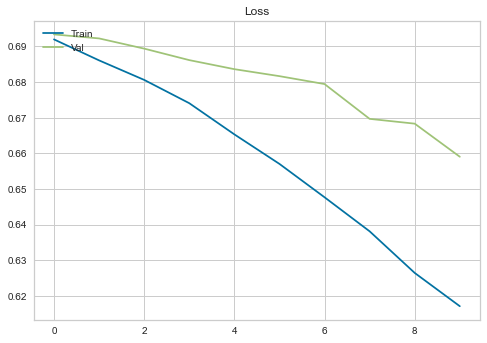

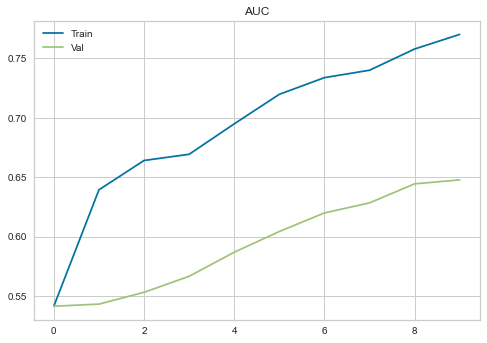

In [83]:
loss_curve = history.history["loss"]
acc_curve = history.history["auc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [84]:
results = model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.6590 - auc: 0.6477


In [85]:
results

[0.6590242981910706, 0.6477189064025879]

In [86]:
results

[0.6590242981910706, 0.6477189064025879]

In [89]:
y_prob = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [90]:
y_pred = np.where(y_prob > 0.5, 1, 0) 

0.6025631985333004


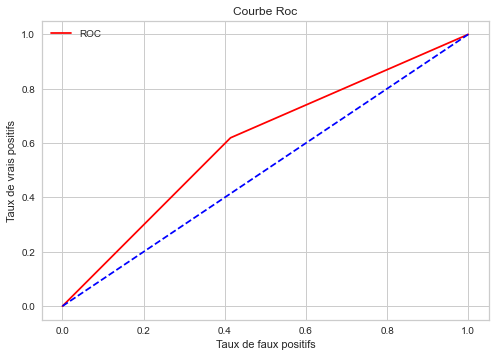

FULL Métrique Métier :  0.21425576519916142
Mean Absolute Error: 0.39832285115303984
Mean Squared Error: 0.39832285115303984
Root Mean Squared Error: 0.6311282366944454


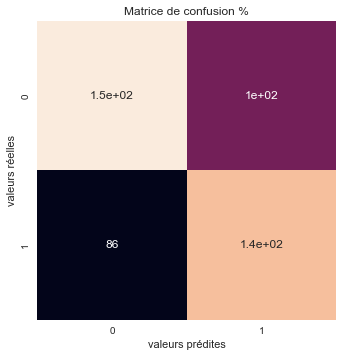

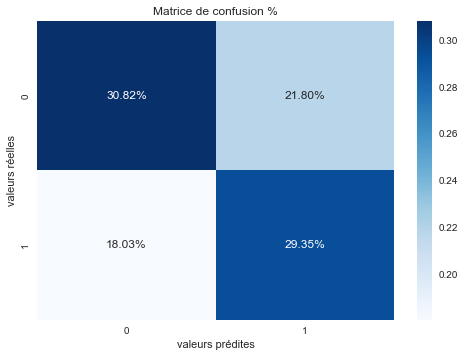


Sur le jeu de test auc : 0.603

Sur le jeu de test f1_score : 0.596

Sur le jeu de test precision : 0.574

Sur le jeu de test recall : 0.619


In [93]:
pipeline_training_metrics(y_prob, y_test)

Autre modèle simple sans embedding

In [193]:
model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  trainable = True,
  mask_zero= True )) 
model.add(Dense(32, input_dim=3622))
###model.add(Flatten())
model.add(Activation('relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(113,activation='softmax'))binary_crossentropy
#model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])

In [117]:
X_train, X_test, y_train, y_test = ml_step1_ech(df)

In [118]:

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 300)          1086600   
                                                                 
 dense_6 (Dense)             (None, 115, 32)           9632      
                                                                 
 activation_1 (Activation)   (None, 115, 32)           0         
                                                                 
 flatten_4 (Flatten)         (None, 3680)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 3681      
                                                                 
Total params: 1,099,913
Trainable params: 1,099,913
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
10/10 [==============================] - 5s 143ms/step - loss: 0.6949 - auc: 0.4905 - val_loss: 0.6913 - val_auc: 0.6405
Epoch 2/10
10/10 [==============================] - 0s 37ms/step - loss: 0.6772 - auc: 0.8503 - val_loss: 0.6889 - val_auc: 0.6564
Epoch 3/10
10/10 [==============================] - 0s 30ms/step - loss: 0.6515 - auc: 0.8690 - val_loss: 0.6809 - val_auc: 0.6748
Epoch 4/10
10/10 [==============================] - 0s 32ms/step - loss: 0.6057 - auc: 0.9415 - val_loss: 0.6661 - val_auc: 0.6894
Epoch 5/10
10/10 [==============================] - 0s 35ms/step - loss: 0.5425 - auc: 0.9575 - val_loss: 0.6456 - val_auc: 0.7136
Epoch 6/10
10/10 [==============================] - 0s 46ms/step - loss: 0.4629 - auc: 0.9781 - val_loss: 0.6220 - val_auc: 0.7380
Epoch 7/10
10/10 [==============================] - 0s 52ms/step - loss: 0.3775 - auc: 0.9885 - val_loss: 0.6147 - val_auc: 0.7414
Epoch 8/10
10/10 [==============================] - 0s 34ms/step - loss: 0.3019 - 

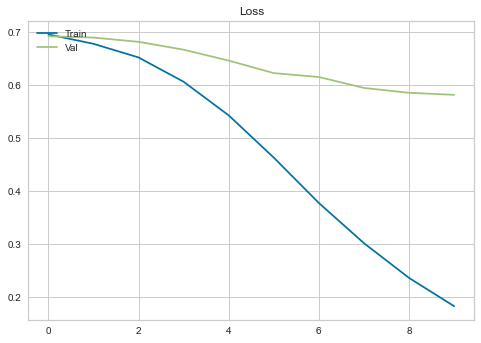

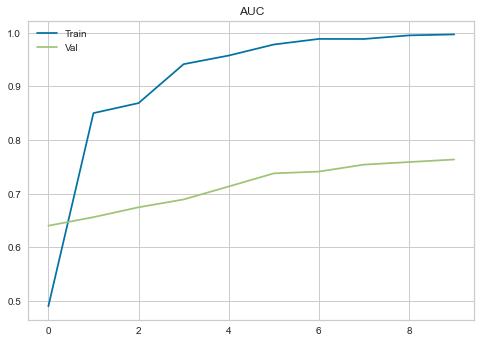

In [119]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=113)
loss_curve = history.history["loss"]
acc_curve = history.history["auc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

Créons une fonction pour pouvoir utiliser ce modèle dans le pipeline

In [194]:
def funct_model_simple_ss_embed(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    trainable = True,
    mask_zero= True )) 
    model.add(Dense(32, input_dim=3622))
    ###model.add(Flatten())
    model.add(Activation('sigmoid'))
    model.add(Dropout(rate=param))
    #model.add(Dense(25,kernel_initializer='normal',activation='relu'))
    #model.add(Dense(25,kernel_initializer='normal',activation='relu'))
    #model.add(Dense(113,activation='softmax'))binary_crossentropy
    #model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [38]:
models

method                                           function  parameters
0       1  <function funct_model_simple at 0x0000027C4A6F...  [0.2, 0.5]

In [42]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.4)
params_model1.append(0.5)
params_model1.append(0.7)


In [55]:
#models = []
models.append([{"method":2, "function":funct_model_simple_ss_embed, "parameters":params_model1}])
#models.append({"method":2, model2})

method                                           function  \
0       1  <function funct_model_simple at 0x0000027C4A6F...   
0       2  <function funct_model_simple_ss_embed at 0x000...   

             parameters  
0            [0.2, 0.5]  
0  [0.2, 0.4, 0.5, 0.7]

## BILSTM

In [94]:
model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Bidirectional(LSTM(20, return_sequences=True), input_dim=3622))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())
model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [242]:
from tensorflow.keras.optimizers import Adam

def funct_model_bilstm_embed_2(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.01)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
        optimizer=adam, 
        metrics=['AUC']
    )
    return model

In [243]:
model_bilstm_Test = funct_model_bilstm_embed_2(embedding_matrix_fasttext, [0])

In [244]:
model_bilstm_Test.summary()

Model: "sequential_833"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_833 (Embedding)   (None, 115, 300)          1086600   
                                                                 
 bidirectional_127 (Bidirect  (None, 115, 128)         186880    
 ional)                                                          
                                                                 
 dropout_748 (Dropout)       (None, 115, 128)          0         
                                                                 
 bidirectional_128 (Bidirect  (None, 64)               41216     
 ional)                                                          
                                                                 
 dropout_749 (Dropout)       (None, 64)                0         
                                                                 
 dense_1553 (Dense)          (None, 64)             

In [222]:
def funct_model_bilstm_embed(embed, param):
    model = Sequential()
    model.add(Embedding( 
    input_dim=3622, 
    output_dim=300, 
    input_length=115, 
    weights= [embed],
    trainable = False,
    mask_zero= True )) 
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_dim=3622))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.add(Flatten())
    model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
    return model

In [95]:
history_bilstm = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50,batch_size=113)

Epoch 1/50
10/10 [==============================] - 13s 387ms/step - loss: 0.6911 - auc: 0.5777 - val_loss: 0.6906 - val_auc: 0.5453
Epoch 2/50
10/10 [==============================] - 1s 114ms/step - loss: 0.6839 - auc: 0.6604 - val_loss: 0.6859 - val_auc: 0.5746
Epoch 3/50
10/10 [==============================] - 1s 114ms/step - loss: 0.6708 - auc: 0.6971 - val_loss: 0.6770 - val_auc: 0.6819
Epoch 4/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6523 - auc: 0.7415 - val_loss: 0.6633 - val_auc: 0.6544
Epoch 5/50
10/10 [==============================] - 1s 119ms/step - loss: 0.6290 - auc: 0.7614 - val_loss: 0.6517 - val_auc: 0.6729
Epoch 6/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6074 - auc: 0.7738 - val_loss: 0.6391 - val_auc: 0.7098
Epoch 7/50
10/10 [==============================] - 1s 113ms/step - loss: 0.5901 - auc: 0.7916 - val_loss: 0.6466 - val_auc: 0.6908
Epoch 8/50
10/10 [==============================] - 1s 117ms/step - loss: 0

In [96]:
history_bilstm.history

{'loss': [0.6911101937294006,
  0.6838827729225159,
  0.6707563400268555,
  0.6522542238235474,
  0.6289741396903992,
  0.6074186563491821,
  0.5901014804840088,
  0.5736559629440308,
  0.5558221340179443,
  0.544887125492096,
  0.5248053073883057,
  0.518692672252655,
  0.5032330751419067,
  0.48705407977104187,
  0.4800359010696411,
  0.4783393144607544,
  0.45693519711494446,
  0.4508610963821411,
  0.4438832104206085,
  0.42914772033691406,
  0.42428022623062134,
  0.41896751523017883,
  0.41271764039993286,
  0.39635032415390015,
  0.3917183578014374,
  0.40414780378341675,
  0.3745962679386139,
  0.3991886377334595,
  0.36651715636253357,
  0.3511136472225189,
  0.3649521470069885,
  0.34319889545440674,
  0.35594356060028076,
  0.32401391863822937,
  0.3409295082092285,
  0.32056382298469543,
  0.31174901127815247,
  0.3284261226654053,
  0.3159337341785431,
  0.29271143674850464,
  0.2933098077774048,
  0.31106770038604736,
  0.3055894374847412,
  0.2702714502811432,
  0.267196

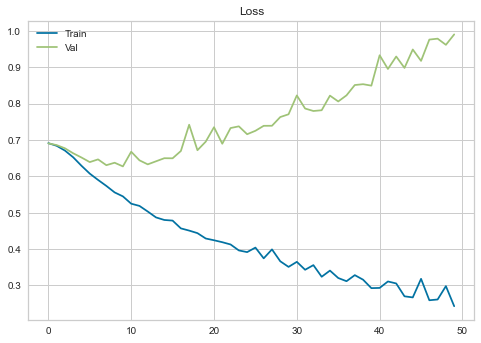

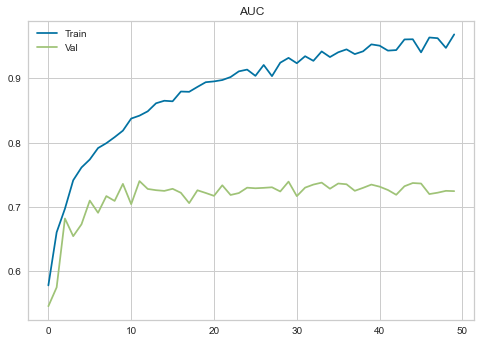

In [97]:
loss_curve = history_bilstm.history["loss"]
acc_curve = history_bilstm.history["auc"]

loss_val_curve = history_bilstm.history["val_loss"]
acc_val_curve = history_bilstm.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [107]:
y_prob = model.predict(X_test)

15/15 [==============================] - 0s 21ms/step


0.6755808623911433


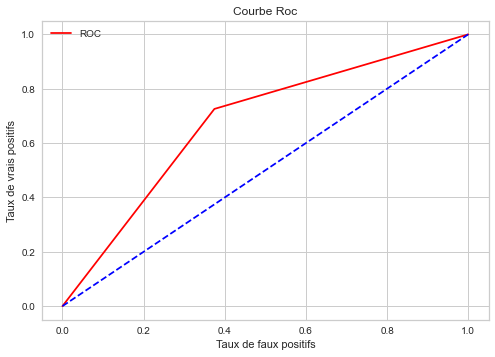

FULL Métrique Métier :  0.19035639412997907
Mean Absolute Error: 0.3270440251572327
Mean Squared Error: 0.3270440251572327
Root Mean Squared Error: 0.5718776312789587


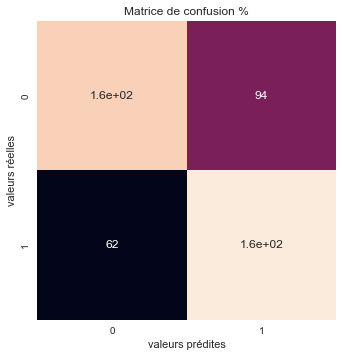

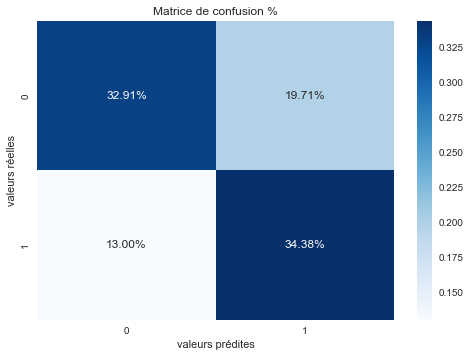


Sur le jeu de test auc : 0.676

Sur le jeu de test f1_score : 0.678

Sur le jeu de test precision : 0.636

Sur le jeu de test recall : 0.726


In [108]:
pipeline_training_metrics(y_prob, y_test)

Lancement du pipeline Modèle simple :

In [246]:
params_model1 = []
params_model1.append(0.2)
params_model1.append(0.4)
params_model1.append(0.6)

models = []
models.append({"method":1, "function":funct_model_simple, "parameters":params_model1})
models.append({"method":2, "function":funct_model_simple_ss_embed, "parameters":params_model1})
models.append({"method":3, "function":funct_model_bilstm_embed, "parameters":[0]})
models.append({"method":4, "function":funct_model_bilstm_embed_2, "parameters":[0]})
models = pd.DataFrame(models)

embeddings = []
embeddings.append({"name_embed":"fast text", "embed":embedding_matrix_fasttext})
embeddings.append({"name_embed":"glove", "embed":embedding_matrix_glove})
#models.append({"method":2, model2})
embeddings = pd.DataFrame(embeddings)

In [240]:
models

method                                           function parameters
0       4  <function funct_model_bilstm_embed_2 at 0x0000...        [0]

In [ ]:
y_train.values_count()

----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 205ms/step - loss: 1.2014 - auc: 0.4714 - val_loss: 0.7424 - val_auc: 0.4973
Epoch 2/15
7/7 [==============================] - 1s 109ms/step - loss: 0.7419 - auc: 0.5110 - val_loss: 0.8115 - val_auc: 0.5306
Epoch 3/15
7/7 [==============================] - 1s 89ms/step - loss: 0.8286 - auc: 0.5067 - val_loss: 0.8005 - val_auc: 0.5321
Epoch 4/15
7/7 [==============================] - 1s 127ms/step - loss: 0.8408 - auc: 0.4922 - val_loss: 0.6948 - val_auc: 0.5617
Epoch 5/15
7/7 [==============================] - 1s 129ms/step - loss: 0.7648 - auc: 0.4992 - val_loss: 0.7726 - val_auc: 0.5485
Epoch 6/15
7/

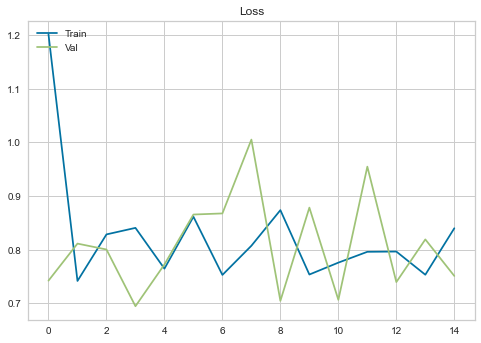

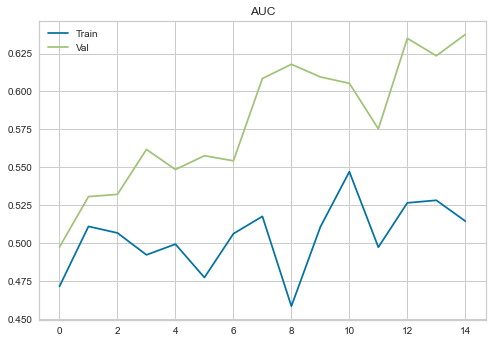

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 234ms/step - loss: 1.1097 - auc: 0.4834 - val_loss: 0.8649 - val_auc: 0.5259
Epoch 2/15
7/7 [==============================] - 1s 105ms/step - loss: 0.8221 - auc: 0.4842 - val_loss: 0.9298 - val_auc: 0.5311
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7860 - auc: 0.5038 - val_loss: 0.7055 - val_auc: 0.5637
Epoch 4/15
7/7 [==============================] - 1s 84ms/step - loss: 0.7565 - auc: 0.5224 - val_loss: 0.9119 - val_auc: 0.5602
Epoch 5/15
7/7 [==============================] - 1s 99ms/step - loss: 0.8436 - auc: 0.5145 - val_loss: 0.8063 - val_auc: 0.5905
Epoch 6/15
7/7 [==============================] - 1s 87ms/step - loss: 0.8082 - auc: 0.4972 - val_loss: 0.9403 - val_auc: 0.5588
Epoch 7/15
7/7 [==============================] - 1s 10

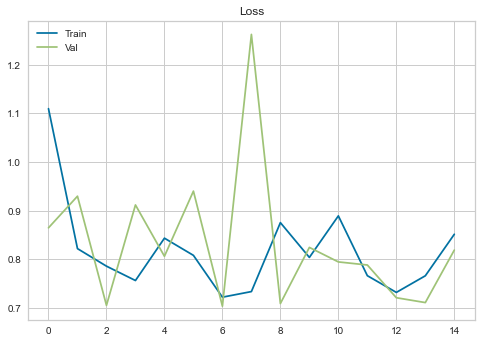

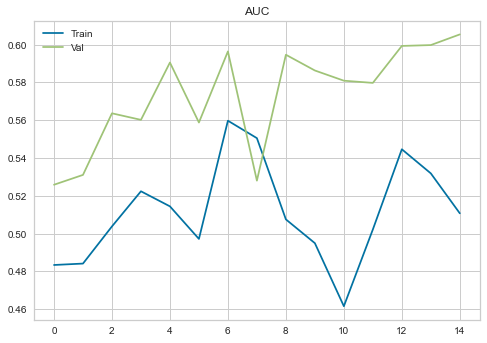

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 174ms/step - loss: 1.1539 - auc: 0.4791 - val_loss: 0.8674 - val_auc: 0.5364
Epoch 2/15
7/7 [==============================] - 1s 80ms/step - loss: 0.8117 - auc: 0.4814 - val_loss: 0.8080 - val_auc: 0.5633
Epoch 3/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7416 - auc: 0.5140 - val_loss: 0.6935 - val_auc: 0.5878
Epoch 4/15
7/7 [==============================] - 1s 79ms/step - loss: 0.8765 - auc: 0.4736 - val_loss: 0.8142 - val_auc: 0.5677
Epoch 5/15
7/7 [==============================] - 1s 78ms/step - loss: 0.7926 - auc: 0.4972 - val_loss: 0.8226 - val_auc: 0.5783
Epoch 6/15
7/7 [==============================] - 1s 77ms/step - loss: 0.7963 - auc: 0.4971 - val_loss: 0.7356 - val_auc: 0.6108
Epoch 7/15
7/7 [==============================] - 1s 79m

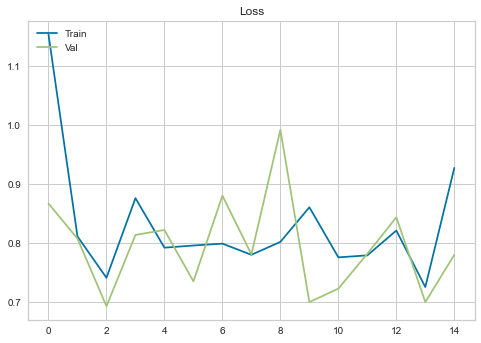

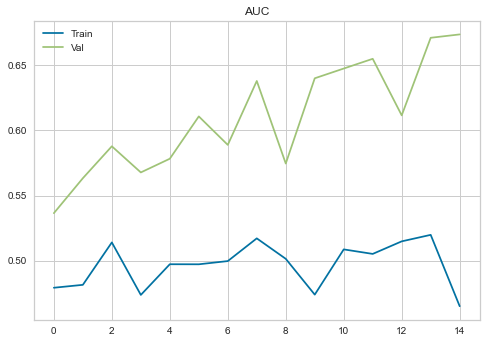

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 191.99595761299133
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 11ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


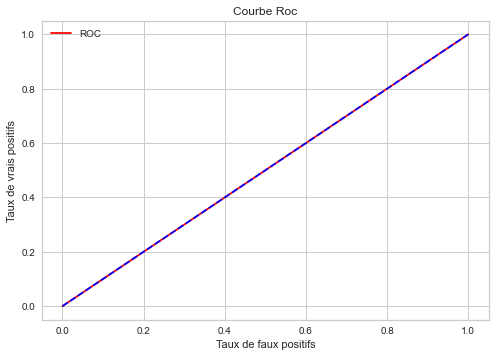

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


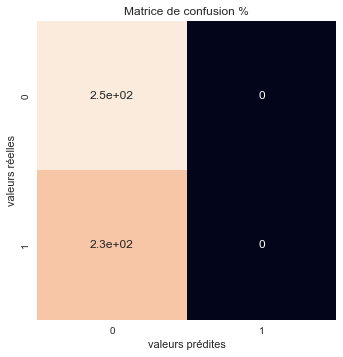

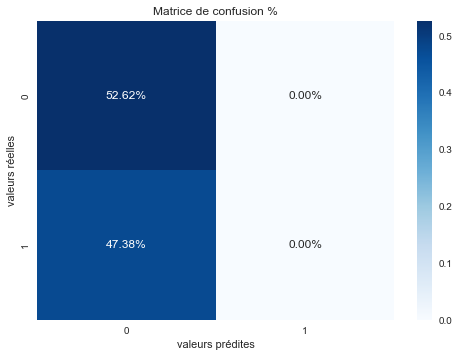


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 2s 172ms/step - loss: 1.1592 - auc: 0.4709 - val_loss: 0.7992 - val_auc: 0.5366
Epoch 2/15
7/7 [==============================] - 1s 75ms/step - loss: 0.8006 - auc: 0.4856 - val_loss: 0.7677 - val_auc: 0.5704
Epoch 3/15
7/7 [==============================] - 0s 68ms/step - loss: 0.7158 - auc: 0.5433 - val_loss: 0.7215 - val_auc: 0.5787
Epoch 4/15
7/7 [==============================] - 1s 75ms/step - loss: 0.8267 - auc: 0.5208 - val_loss: 0.8680 - val_auc: 0.6074
Epoch 5/15
7/7 [==============================] - 0s 73ms/step - loss: 0.7425 - auc: 0.5421 - val_loss: 0.6958 - val_auc: 0.6113
Epoch 6/15
7/7 [==============================] - 0s 73ms/step - loss: 0.7973 - auc: 0.5164 - val_loss: 0.8434 - val_auc: 0.6196
Epoch 7/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8171 - auc: 0.5040 - val_loss: 0.8449 - val_auc: 0.6266
Epoch 8/15
7/7 [==============================] - 0s 72ms/step - loss: 0.7547 - auc: 0.5301 - va

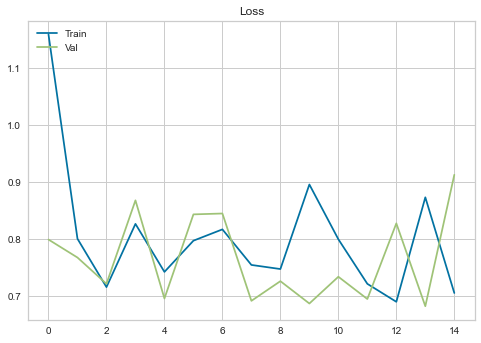

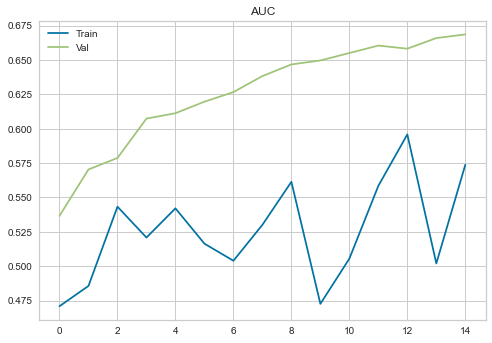

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 172ms/step - loss: 1.0838 - auc: 0.4973 - val_loss: 1.0886 - val_auc: 0.5245
Epoch 2/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8315 - auc: 0.4978 - val_loss: 0.7724 - val_auc: 0.5762
Epoch 3/15
7/7 [==============================] - 0s 69ms/step - loss: 0.7783 - auc: 0.4988 - val_loss: 0.6958 - val_auc: 0.5870
Epoch 4/15
7/7 [==============================] - 0s 72ms/step - loss: 0.8035 - auc: 0.4973 - val_loss: 0.9782 - val_auc: 0.6021
Epoch 5/15
7/7 [==============================] - 0s 73ms/step - loss: 0.8318 - auc: 0.4950 - val_loss: 0.6890 - val_auc: 0.6189
Epoch 6/15
7/7 [==============================] - 0s 72ms/step - loss: 0.7003 - auc: 0.5771 - val_loss: 0.7349 - val_auc: 0.6242
Epoch 7/15
7/7 [==============================] - 0s 72m

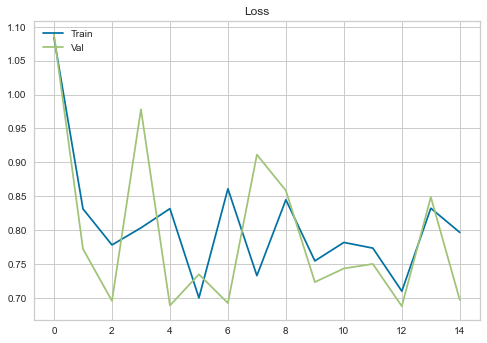

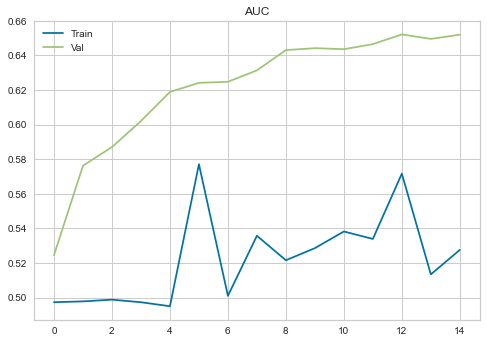

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 4s 208ms/step - loss: 1.0475 - auc: 0.4852 - val_loss: 0.8276 - val_auc: 0.5036
Epoch 2/15
7/7 [==============================] - 1s 82ms/step - loss: 0.7854 - auc: 0.5158 - val_loss: 0.9223 - val_auc: 0.5132
Epoch 3/15
7/7 [==============================] - 1s 79ms/step - loss: 0.9198 - auc: 0.4593 - val_loss: 0.8049 - val_auc: 0.5572
Epoch 4/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7368 - auc: 0.5239 - val_loss: 0.7934 - val_auc: 0.5650
Epoch 5/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8223 - auc: 0.5180 - val_loss: 0.6946 - val_auc: 0.5906
Epoch 6/15
7/7 [==============================] - 1s 73ms/step - loss: 0.7389 - auc: 0.5292 - val_loss: 0.9560 - val_auc: 0.5827
Epoch 7/15
7/7 [==============================] - 0s 71m

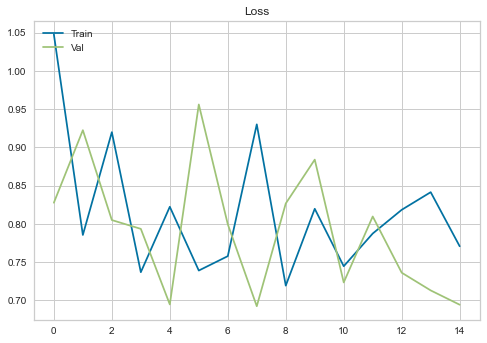

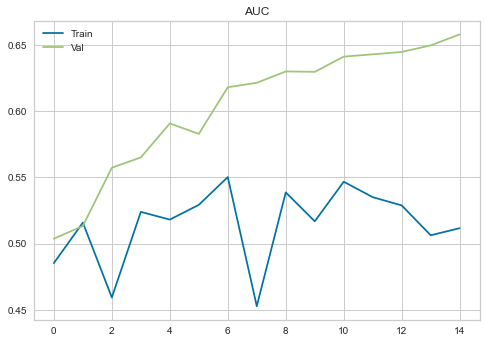

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 39.1723473072052
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 11ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


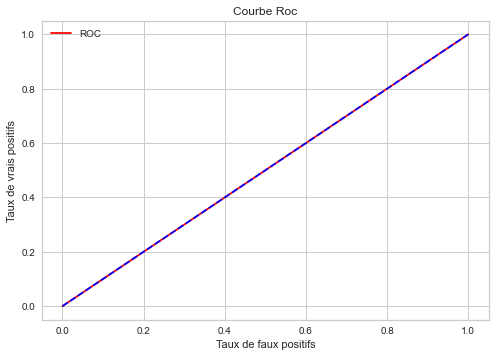

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


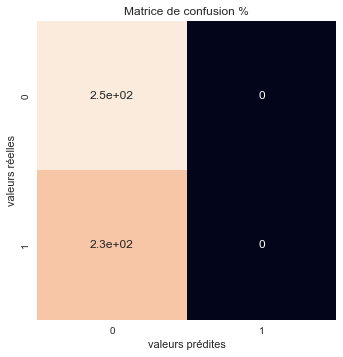

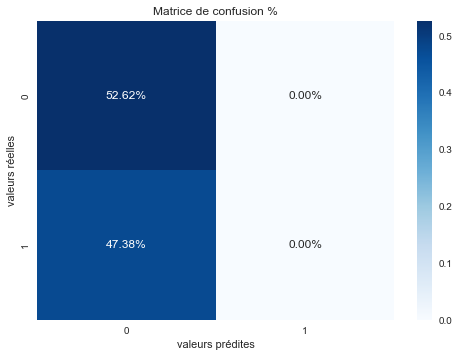


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 2s 126ms/step - loss: 1.0928 - auc: 0.5177 - val_loss: 0.7556 - val_auc: 0.4933
Epoch 2/15
7/7 [==============================] - 1s 88ms/step - loss: 0.8360 - auc: 0.4983 - val_loss: 0.8331 - val_auc: 0.5044
Epoch 3/15
7/7 [==============================] - 1s 79ms/step - loss: 0.7428 - auc: 0.5588 - val_loss: 0.9871 - val_auc: 0.5055
Epoch 4/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8785 - auc: 0.4835 - val_loss: 0.7334 - val_auc: 0.5375
Epoch 5/15
7/7 [==============================] - 1s 89ms/step - loss: 0.8711 - auc: 0.4763 - val_loss: 0.7056 - val_auc: 0.5438
Epoch 6/15
7/7 [==============================] - 1s 79ms/step - loss: 0.7799 - auc: 0.5115 - val_loss: 0.7327 - val_auc: 0.5392
Epoch 7/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8465 - auc: 0.4837 - val_loss: 0.7061 - val_auc: 0.5730
Epoch 8/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8459 - auc: 0.4816 - va

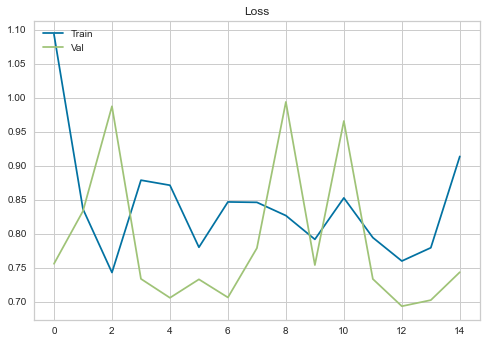

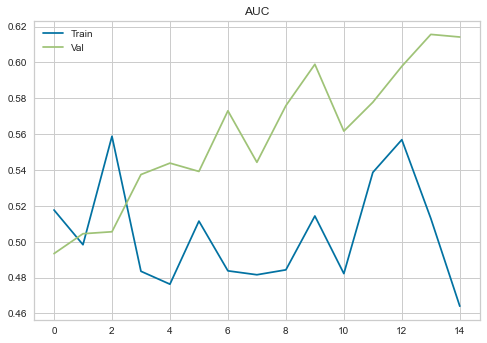

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 205ms/step - loss: 1.1569 - auc: 0.4768 - val_loss: 0.8321 - val_auc: 0.5155
Epoch 2/15
7/7 [==============================] - 1s 77ms/step - loss: 0.7430 - auc: 0.5395 - val_loss: 1.1375 - val_auc: 0.4976
Epoch 3/15
7/7 [==============================] - 1s 74ms/step - loss: 0.8051 - auc: 0.5282 - val_loss: 0.7948 - val_auc: 0.5218
Epoch 4/15
7/7 [==============================] - 1s 79ms/step - loss: 0.8835 - auc: 0.4971 - val_loss: 0.8006 - val_auc: 0.5446
Epoch 5/15
7/7 [==============================] - 0s 71ms/step - loss: 0.7781 - auc: 0.4873 - val_loss: 0.7488 - val_auc: 0.5628
Epoch 6/15
7/7 [==============================] - 0s 68ms/step - loss: 0.8580 - auc: 0.5092 - val_loss: 0.9252 - val_auc: 0.5331
Epoch 7/15
7/7 [==============================] - 1s 78m

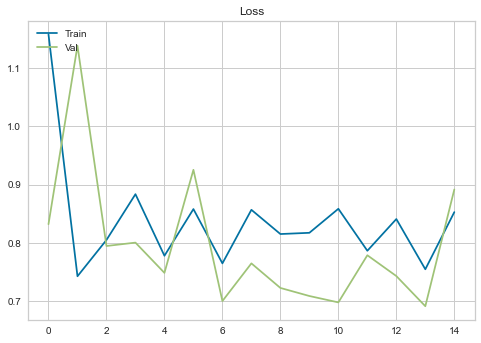

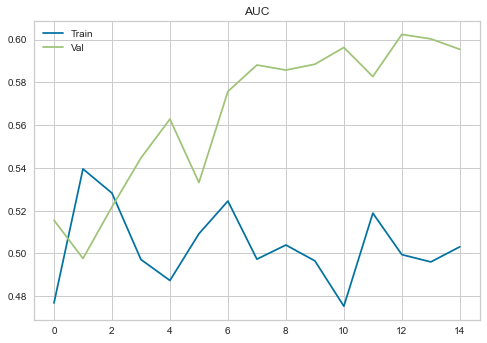

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 3s 160ms/step - loss: 1.1682 - auc: 0.4689 - val_loss: 0.9083 - val_auc: 0.4871
Epoch 2/15
7/7 [==============================] - 1s 82ms/step - loss: 0.8038 - auc: 0.5018 - val_loss: 0.7975 - val_auc: 0.4969
Epoch 3/15
7/7 [==============================] - 1s 122ms/step - loss: 0.8947 - auc: 0.4848 - val_loss: 0.7300 - val_auc: 0.5417
Epoch 4/15
7/7 [==============================] - 1s 129ms/step - loss: 0.8227 - auc: 0.4804 - val_loss: 0.9138 - val_auc: 0.6006
Epoch 5/15
7/7 [==============================] - 1s 111ms/step - loss: 0.8515 - auc: 0.5075 - val_loss: 0.8963 - val_auc: 0.6034
Epoch 6/15
7/7 [==============================] - 1s 76ms/step - loss: 0.7800 - auc: 0.5212 - val_loss: 0.6967 - val_auc: 0.6126
Epoch 7/15
7/7 [==============================] - 1s 

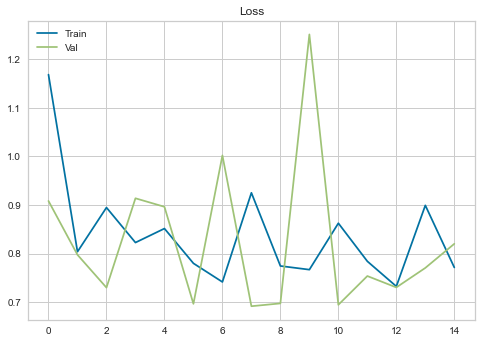

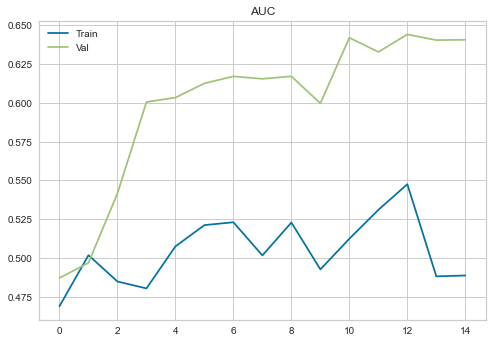

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 40.76549935340881
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


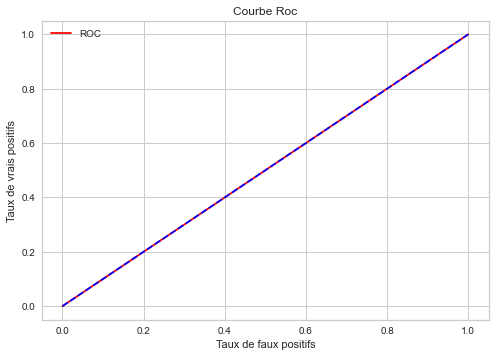

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


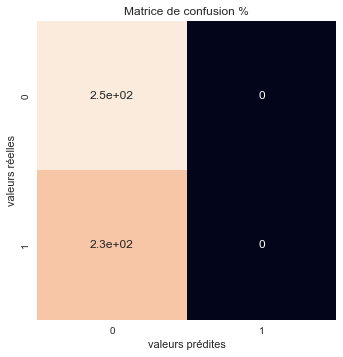

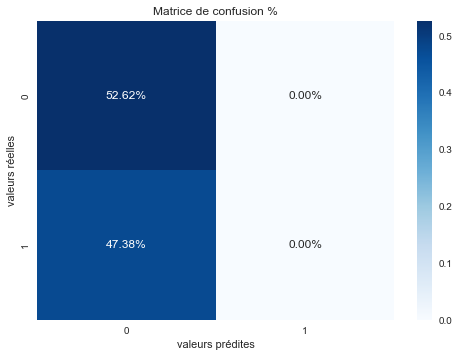


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 2s 146ms/step - loss: 1.0595 - auc: 0.4933 - val_loss: 0.7534 - val_auc: 0.4700
Epoch 2/15
7/7 [==============================] - 0s 67ms/step - loss: 0.8513 - auc: 0.4896 - val_loss: 0.6939 - val_auc: 0.4954
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7499 - auc: 0.5325 - val_loss: 0.7294 - val_auc: 0.5125
Epoch 4/15
7/7 [==============================] - 1s 82ms/step - loss: 0.9087 - auc: 0.4822 - val_loss: 0.7023 - val_auc: 0.5325
Epoch 5/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7786 - auc: 0.5043 - val_loss: 0.7980 - val_auc: 0.5509
Epoch 6/15
7/7 [==============================] - 1s 75ms/step - loss: 0.7378 - auc: 0.5427 - val_loss: 0.6920 - val_auc: 0.5740
Epoch 7/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8594 - auc: 0.5060 - val_loss: 0.8160 - val_auc: 0.5848
Epoch 8/15
7/7 [==============================] - 1s 106ms/step - loss: 0.7752 - auc: 0.5277 - val_loss: 0.

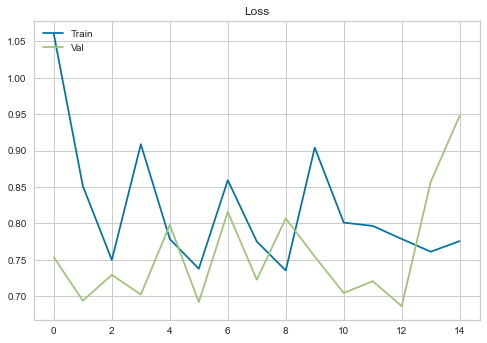

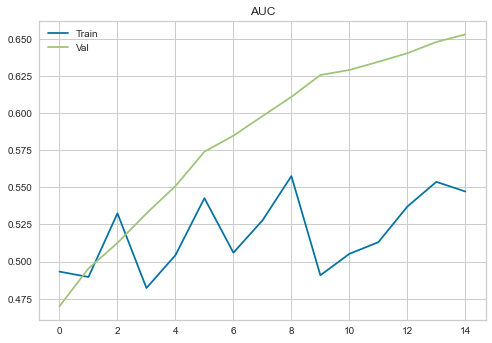

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 138ms/step - loss: 1.0205 - auc: 0.5295 - val_loss: 0.8285 - val_auc: 0.5368
Epoch 2/15
7/7 [==============================] - 1s 70ms/step - loss: 0.9103 - auc: 0.5004 - val_loss: 0.7535 - val_auc: 0.5521
Epoch 3/15
7/7 [==============================] - 0s 70ms/step - loss: 0.8147 - auc: 0.4837 - val_loss: 0.8247 - val_auc: 0.5540
Epoch 4/15
7/7 [==============================] - 1s 100ms/step - loss: 0.8168 - auc: 0.5035 - val_loss: 0.8301 - val_auc: 0.5716
Epoch 5/15
7/7 [==============================] - 1s 85ms/step - loss: 0.7568 - auc: 0.5330 - val_loss: 0.7209 - val_auc: 0.5819
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8965 - auc: 0.4916 - val_loss: 0.7436 - val_auc: 0.5918
Epoch 7/15
7/7 [==============================] - 1s 92

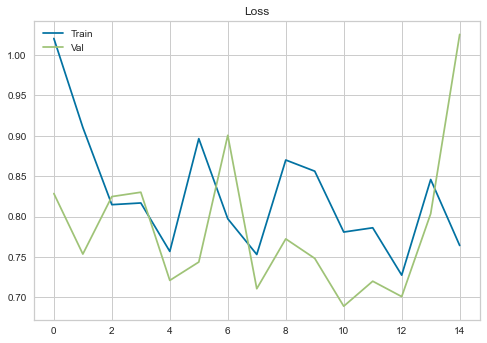

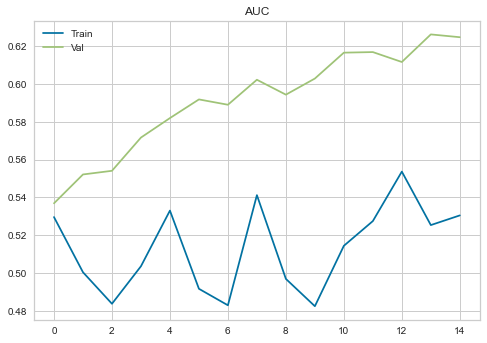

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 132ms/step - loss: 1.0540 - auc: 0.5246 - val_loss: 0.7235 - val_auc: 0.5178
Epoch 2/15
7/7 [==============================] - 1s 86ms/step - loss: 0.8505 - auc: 0.5062 - val_loss: 0.7136 - val_auc: 0.5423
Epoch 3/15
7/7 [==============================] - 0s 70ms/step - loss: 0.7977 - auc: 0.4999 - val_loss: 0.9732 - val_auc: 0.5498
Epoch 4/15
7/7 [==============================] - 0s 71ms/step - loss: 0.8126 - auc: 0.5095 - val_loss: 1.1319 - val_auc: 0.5863
Epoch 5/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8936 - auc: 0.4757 - val_loss: 0.7863 - val_auc: 0.5813
Epoch 6/15
7/7 [==============================] - 0s 75ms/step - loss: 0.7732 - auc: 0.5229 - val_loss: 0.7367 - val_auc: 0.5972
Epoch 7/15
7/7 [==============================] - 1s 78m

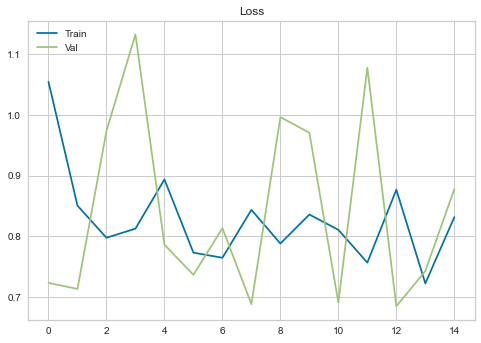

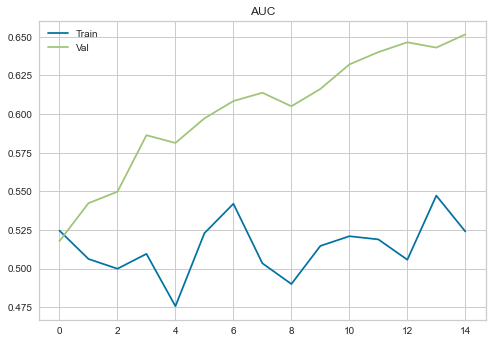

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.46133168208639913
temps calcul : 36.88045787811279
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 12ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


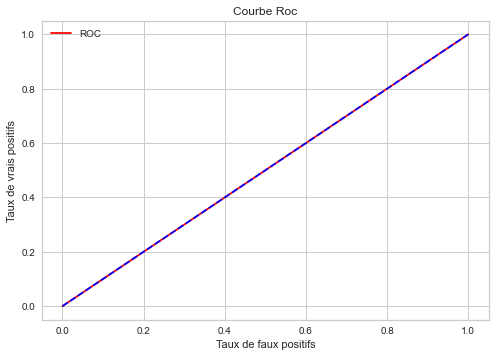

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


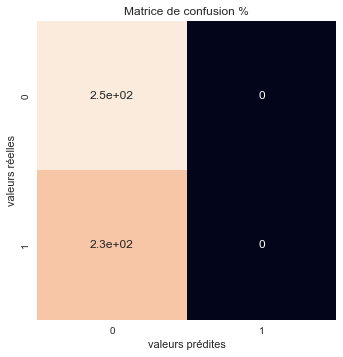

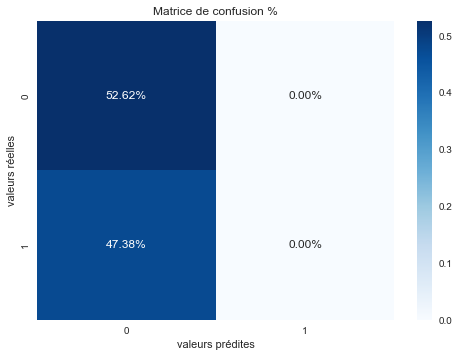


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  fast text
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 2s 198ms/step - loss: 1.1521 - auc: 0.4735 - val_loss: 0.6973 - val_auc: 0.4821
Epoch 2/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8620 - auc: 0.4773 - val_loss: 0.7762 - val_auc: 0.4951
Epoch 3/15
7/7 [==============================] - 1s 89ms/step - loss: 0.8646 - auc: 0.4923 - val_loss: 0.8563 - val_auc: 0.5051
Epoch 4/15
7/7 [==============================] - 1s 74ms/step - loss: 0.9322 - auc: 0.4740 - val_loss: 0.7945 - val_auc: 0.5059
Epoch 5/15
7/7 [==============================] - 0s 72ms/step - loss: 0.8222 - auc: 0.4886 - val_loss: 0.7914 - val_auc: 0.5331
Epoch 6/15
7/7 [==============================] - 0s 71ms/step - loss: 0.8697 - auc: 0.4630 - val_loss: 1.0176 - val_auc: 0.5364
Epoch 7/15
7/7 [==============================] - 0s 70ms/step - loss: 0.9461 - auc: 0.4831 - val_loss: 0.7610 - val_auc: 0.5403
Epoch 8/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8349 - auc: 0.4873 - va

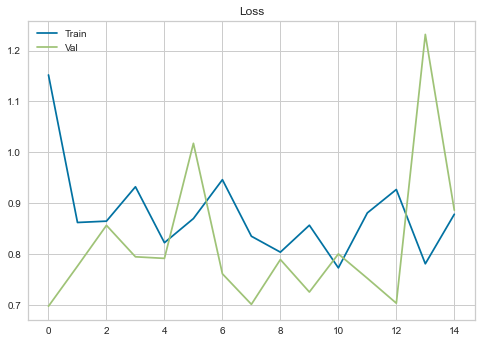

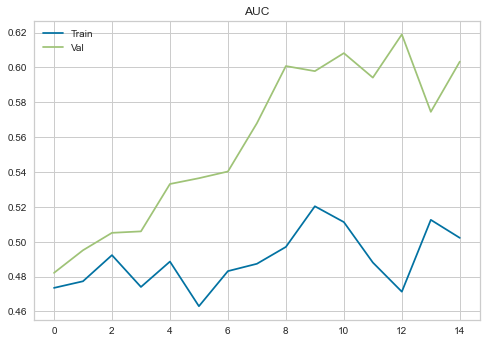

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 166ms/step - loss: 1.0593 - auc: 0.5156 - val_loss: 0.8197 - val_auc: 0.5457
Epoch 2/15
7/7 [==============================] - 1s 74ms/step - loss: 0.8215 - auc: 0.5072 - val_loss: 0.7002 - val_auc: 0.5424
Epoch 3/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8426 - auc: 0.4797 - val_loss: 1.0341 - val_auc: 0.5564
Epoch 4/15
7/7 [==============================] - 1s 87ms/step - loss: 0.8922 - auc: 0.4847 - val_loss: 0.7414 - val_auc: 0.5766
Epoch 5/15
7/7 [==============================] - 1s 83ms/step - loss: 0.8132 - auc: 0.5466 - val_loss: 0.9482 - val_auc: 0.5601
Epoch 6/15
7/7 [==============================] - 1s 76ms/step - loss: 0.8284 - auc: 0.4951 - val_loss: 0.7013 - val_auc: 0.5705
Epoch 7/15
7/7 [==============================] - 0s 70m

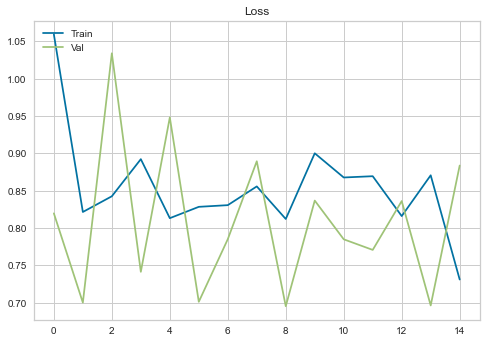

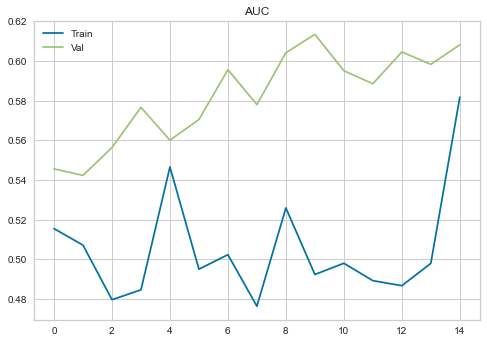

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 172ms/step - loss: 1.2254 - auc: 0.4719 - val_loss: 0.7616 - val_auc: 0.5108
Epoch 2/15
7/7 [==============================] - 0s 71ms/step - loss: 0.7708 - auc: 0.5348 - val_loss: 0.6931 - val_auc: 0.5178
Epoch 3/15
7/7 [==============================] - 1s 76ms/step - loss: 0.9434 - auc: 0.4729 - val_loss: 0.7046 - val_auc: 0.5494
Epoch 4/15
7/7 [==============================] - 0s 72ms/step - loss: 0.8201 - auc: 0.4909 - val_loss: 0.8764 - val_auc: 0.5430
Epoch 5/15
7/7 [==============================] - 0s 69ms/step - loss: 0.8415 - auc: 0.5028 - val_loss: 0.7475 - val_auc: 0.5483
Epoch 6/15
7/7 [==============================] - 0s 71ms/step - loss: 0.7819 - auc: 0.5233 - val_loss: 0.7006 - val_auc: 0.5670
Epoch 7/15
7/7 [==============================] - 0s 74m

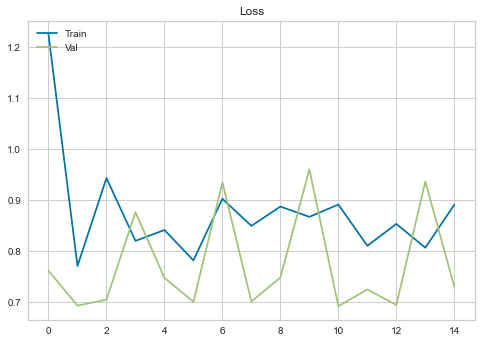

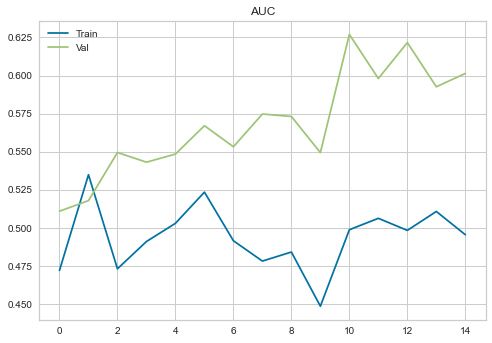

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed fast text
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863992
temps calcul : 38.46234583854675
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


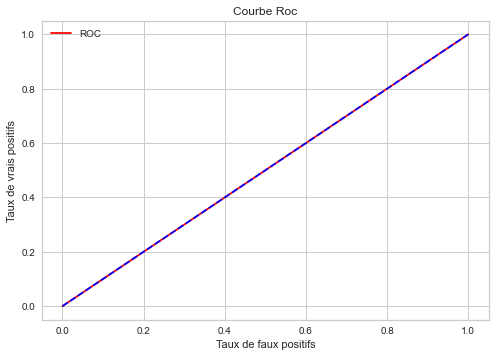

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


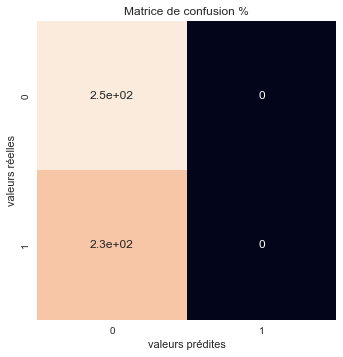

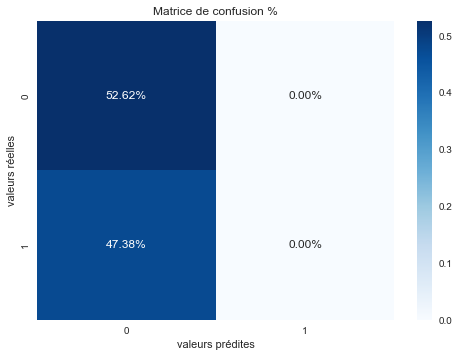


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple at 0x0000027E11A10288>
------------embeddings :  glove
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 2s 152ms/step - loss: 1.1597 - auc: 0.5114 - val_loss: 0.7334 - val_auc: 0.5133
Epoch 2/15
7/7 [==============================] - 1s 84ms/step - loss: 0.8659 - auc: 0.4836 - val_loss: 0.7465 - val_auc: 0.5194
Epoch 3/15
7/7 [==============================] - 1s 78ms/step - loss: 0.7822 - auc: 0.5446 - val_loss: 0.6936 - val_auc: 0.5481
Epoch 4/15
7/7 [==============================] - 1s 79ms/step - loss: 0.8046 - auc: 0.5275 - val_loss: 0.7932 - val_auc: 0.5673
Epoch 5/15
7/7 [==============================] - 1s 86ms/step - loss: 0.9465 - auc: 0.4710 - val_loss: 0.8806 - val_auc: 0.5817
Epoch 6/15
7/7 [==============================] - 1s 81ms/step - loss: 0.8255 - auc: 0.5356 - val_loss: 0.7033 - val_auc: 0.5899
Epoch 7/15
7/7 [==============================] - 1s 86ms/step - loss: 0.8098 - auc: 0.5144 - val_loss: 0.9284 - val_auc: 0.5946
Epoch 8/15
7/7 [==============================] - 1s 81ms/step - loss: 0.8208 - auc: 0.5373 - va

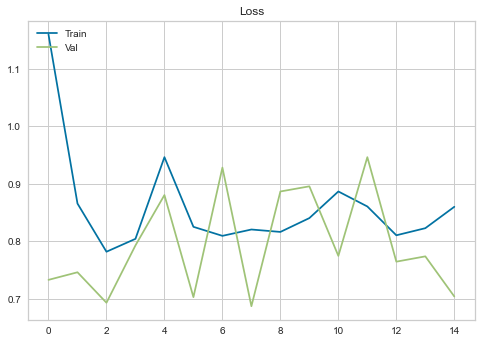

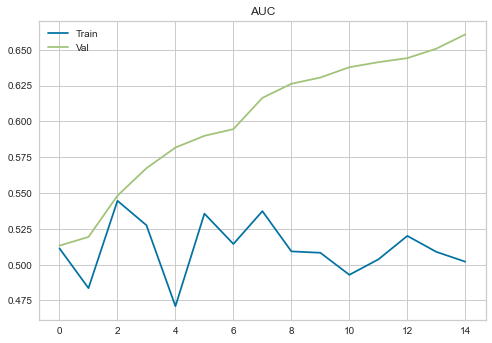

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 124ms/step - loss: 0.9993 - auc: 0.5410 - val_loss: 0.6923 - val_auc: 0.5869
Epoch 2/15
7/7 [==============================] - 1s 79ms/step - loss: 0.8595 - auc: 0.4988 - val_loss: 0.6948 - val_auc: 0.5974
Epoch 3/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8318 - auc: 0.5184 - val_loss: 0.7654 - val_auc: 0.5989
Epoch 4/15
7/7 [==============================] - 1s 80ms/step - loss: 0.8252 - auc: 0.5047 - val_loss: 0.7360 - val_auc: 0.6175
Epoch 5/15
7/7 [==============================] - 1s 78ms/step - loss: 0.7981 - auc: 0.5319 - val_loss: 0.7325 - val_auc: 0.6141
Epoch 6/15
7/7 [==============================] - 1s 80ms/step - loss: 0.8086 - auc: 0.4944 - val_loss: 0.7753 - val_auc: 0.6217
Epoch 7/15
7/7 [==============================] - 1s 76m

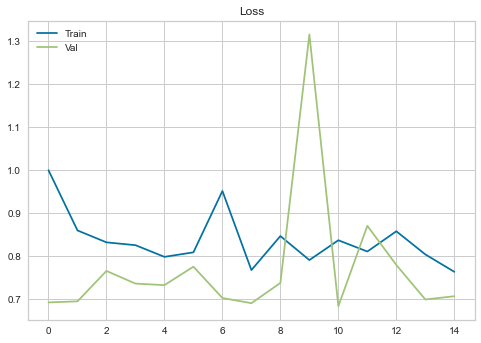

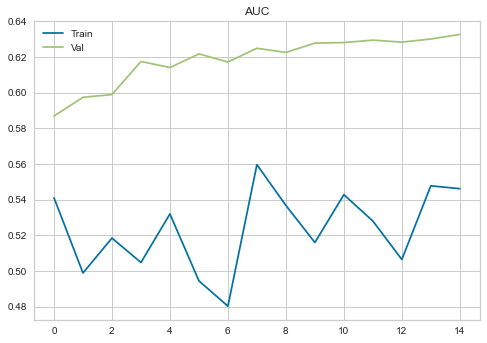

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 144ms/step - loss: 1.0345 - auc: 0.5104 - val_loss: 1.2871 - val_auc: 0.5455
Epoch 2/15
7/7 [==============================] - 0s 66ms/step - loss: 0.8646 - auc: 0.5266 - val_loss: 0.6931 - val_auc: 0.5951
Epoch 3/15
7/7 [==============================] - 1s 78ms/step - loss: 0.8280 - auc: 0.5060 - val_loss: 0.8010 - val_auc: 0.5988
Epoch 4/15
7/7 [==============================] - 1s 77ms/step - loss: 0.8416 - auc: 0.5246 - val_loss: 0.7449 - val_auc: 0.6205
Epoch 5/15
7/7 [==============================] - 1s 77ms/step - loss: 0.9037 - auc: 0.4964 - val_loss: 0.6982 - val_auc: 0.6225
Epoch 6/15
7/7 [==============================] - 1s 73ms/step - loss: 0.7939 - auc: 0.5011 - val_loss: 0.9283 - val_auc: 0.6333
Epoch 7/15
7/7 [==============================] - 1s 79m

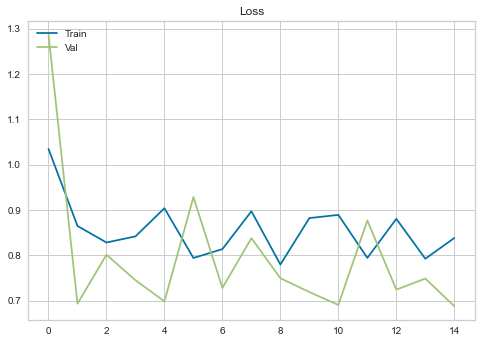

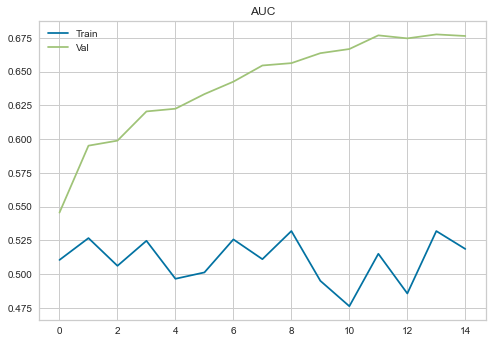

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple at 0x0000027E11A10288>
embed glove
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 37.90970802307129
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:1
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


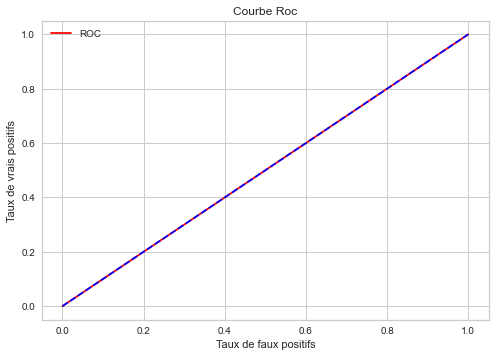

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


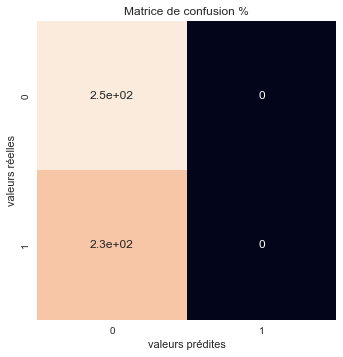

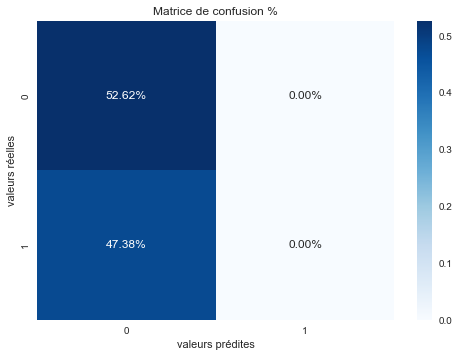


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 2s 175ms/step - loss: 1.1217 - auc: 0.4985 - val_loss: 0.8032 - val_auc: 0.5218
Epoch 2/15
7/7 [==============================] - 1s 87ms/step - loss: 0.8744 - auc: 0.4594 - val_loss: 0.9529 - val_auc: 0.5079
Epoch 3/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7760 - auc: 0.5148 - val_loss: 0.6934 - val_auc: 0.5753
Epoch 4/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7479 - auc: 0.4925 - val_loss: 1.0595 - val_auc: 0.5807
Epoch 5/15
7/7 [==============================] - 1s 91ms/step - loss: 0.7779 - auc: 0.5262 - val_loss: 0.8893 - val_auc: 0.6044
Epoch 6/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7675 - auc: 0.5268 - val_loss: 0.7013 - val_auc: 0.6567
Epoch 7/15
7/7 [==============================] - 1s 87ms/step - loss: 0.7113 - auc: 0.5504 - val_loss: 0.7016 - val_auc: 0.6488
Epoch 8/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7844 - auc: 0.5420 - val_loss: 0.8

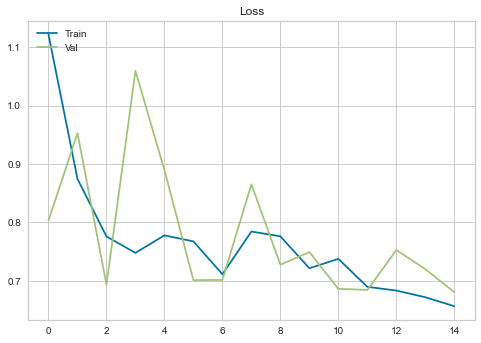

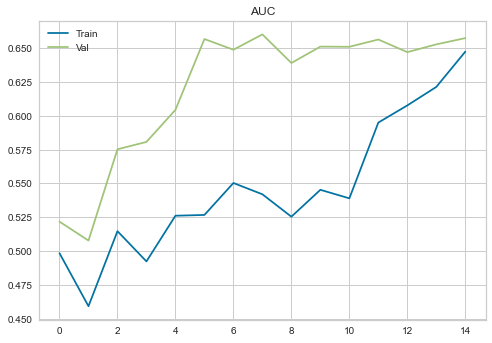

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 181ms/step - loss: 1.1775 - auc: 0.4599 - val_loss: 0.9439 - val_auc: 0.4999
Epoch 2/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7899 - auc: 0.5193 - val_loss: 0.6931 - val_auc: 0.5471
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.6981 - auc: 0.5515 - val_loss: 0.6930 - val_auc: 0.5774
Epoch 4/15
7/7 [==============================] - 1s 89ms/step - loss: 0.7182 - auc: 0.5135 - val_loss: 1.2467 - val_auc: 0.5815
Epoch 5/15
7/7 [==============================] - 1s 90ms/step - loss: 0.9010 - auc: 0.5032 - val_loss: 0.7559 - val_auc: 0.6173
Epoch 6/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7509 - auc: 0.5299 - val_loss: 0.7721 - val_auc: 0.6254
Epoch 7/15
7/7 [==============================] - 1s 92m

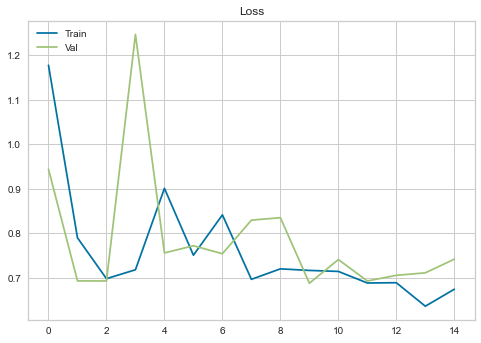

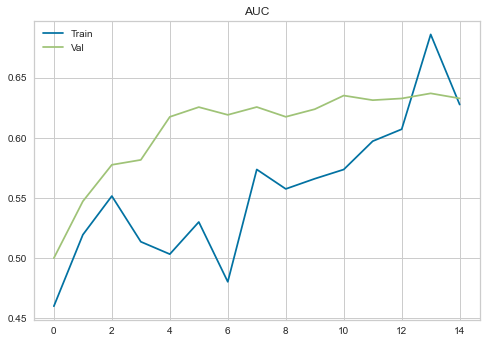

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 141ms/step - loss: 1.1039 - auc: 0.4981 - val_loss: 0.7539 - val_auc: 0.5504
Epoch 2/15
7/7 [==============================] - 1s 96ms/step - loss: 0.7295 - auc: 0.5190 - val_loss: 0.7779 - val_auc: 0.5387
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8502 - auc: 0.4707 - val_loss: 0.6922 - val_auc: 0.5866
Epoch 4/15
7/7 [==============================] - 1s 97ms/step - loss: 0.7306 - auc: 0.5055 - val_loss: 0.9878 - val_auc: 0.5499
Epoch 5/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7627 - auc: 0.5415 - val_loss: 0.9559 - val_auc: 0.6002
Epoch 6/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7513 - auc: 0.5325 - val_loss: 0.8412 - val_auc: 0.6051
Epoch 7/15
7/7 [==============================] - 1s 93m

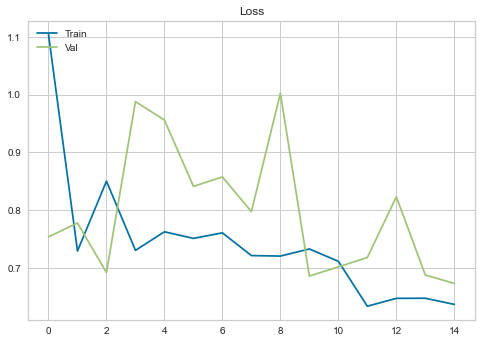

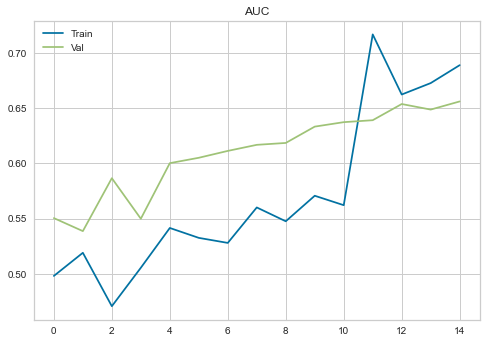

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 42.25410842895508
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


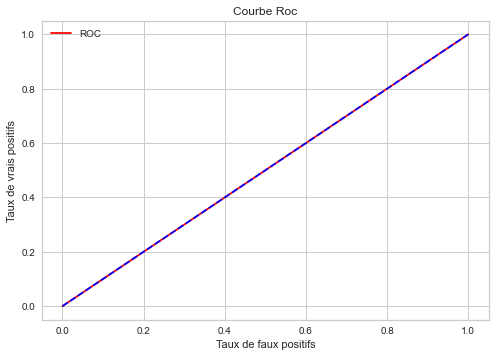

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


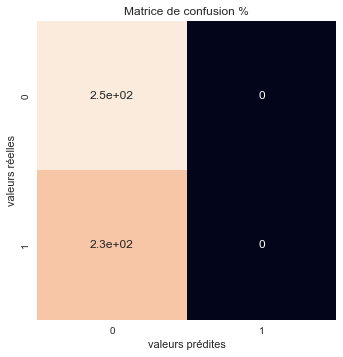

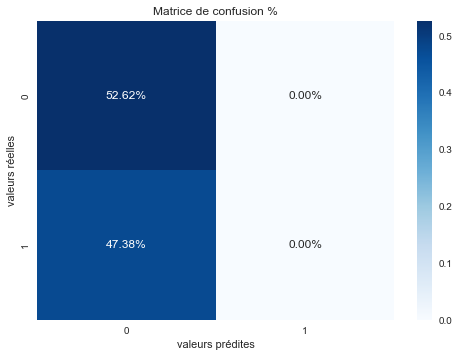


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.2
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 2s 153ms/step - loss: 1.1742 - auc: 0.4822 - val_loss: 0.7982 - val_auc: 0.5309
Epoch 2/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7539 - auc: 0.5095 - val_loss: 0.7364 - val_auc: 0.5540
Epoch 3/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8546 - auc: 0.4834 - val_loss: 0.9306 - val_auc: 0.5130
Epoch 4/15
7/7 [==============================] - 1s 96ms/step - loss: 0.7479 - auc: 0.5271 - val_loss: 0.7411 - val_auc: 0.5971
Epoch 5/15
7/7 [==============================] - 1s 97ms/step - loss: 0.7686 - auc: 0.5316 - val_loss: 0.7052 - val_auc: 0.6159
Epoch 6/15
7/7 [==============================] - 1s 101ms/step - loss: 0.6865 - auc: 0.5690 - val_loss: 0.8145 - val_auc: 0.6256
Epoch 7/15
7/7 [==============================] - 1s 105ms/step - loss: 0.8284 - auc: 0.5294 - val_loss: 0.6921 - val_auc: 0.6563
Epoch 8/15
7/7 [==============================] - 1s 110ms/step - loss: 0.7568 - auc: 0.5332 - val_loss: 

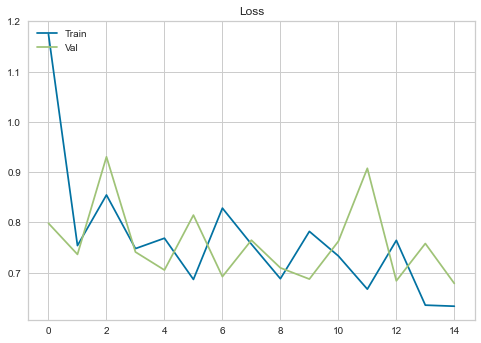

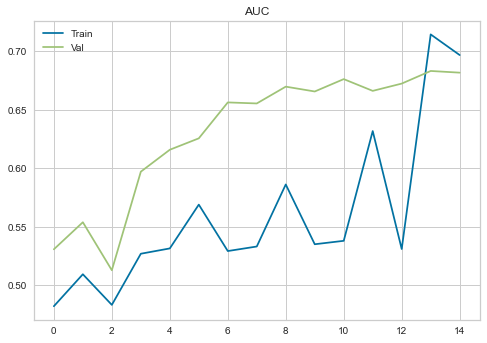

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 2s 141ms/step - loss: 1.0427 - auc: 0.5025 - val_loss: 0.8465 - val_auc: 0.5124
Epoch 2/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8255 - auc: 0.4838 - val_loss: 0.7765 - val_auc: 0.5098
Epoch 3/15
7/7 [==============================] - 1s 87ms/step - loss: 0.7127 - auc: 0.5271 - val_loss: 0.7030 - val_auc: 0.5334
Epoch 4/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7502 - auc: 0.5233 - val_loss: 1.0551 - val_auc: 0.5091
Epoch 5/15
7/7 [==============================] - 1s 120ms/step - loss: 0.7557 - auc: 0.5591 - val_loss: 0.7832 - val_auc: 0.5408
Epoch 6/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7196 - auc: 0.5667 - val_loss: 0.7309 - val_auc: 0.5936
Epoch 7/15
7/7 [==============================] - 1s 90

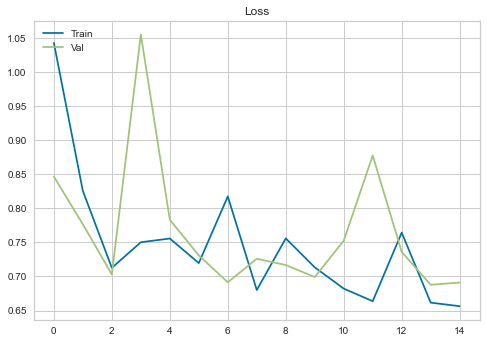

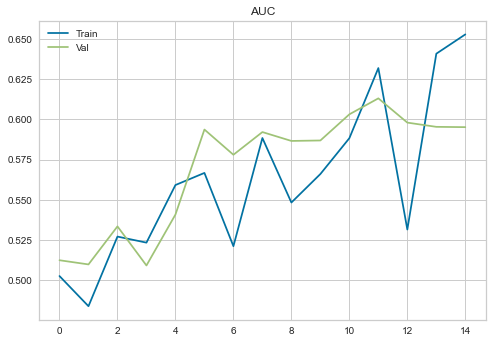

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 2s 140ms/step - loss: 1.0371 - auc: 0.5265 - val_loss: 0.7849 - val_auc: 0.5484
Epoch 2/15
7/7 [==============================] - 1s 134ms/step - loss: 0.8323 - auc: 0.4996 - val_loss: 0.7740 - val_auc: 0.5111
Epoch 3/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7135 - auc: 0.5413 - val_loss: 0.7518 - val_auc: 0.5405
Epoch 4/15
7/7 [==============================] - 1s 88ms/step - loss: 0.7278 - auc: 0.5458 - val_loss: 0.7083 - val_auc: 0.5572
Epoch 5/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8794 - auc: 0.4888 - val_loss: 0.6956 - val_auc: 0.5645
Epoch 6/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8020 - auc: 0.5047 - val_loss: 0.7595 - val_auc: 0.5820
Epoch 7/15
7/7 [==============================] - 1s 11

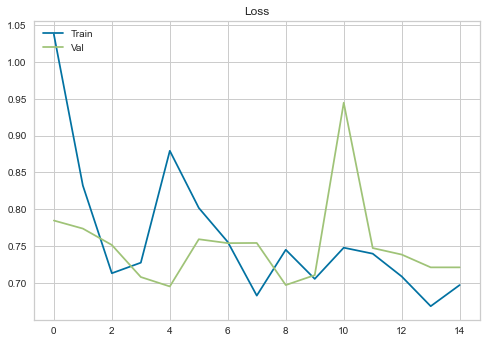

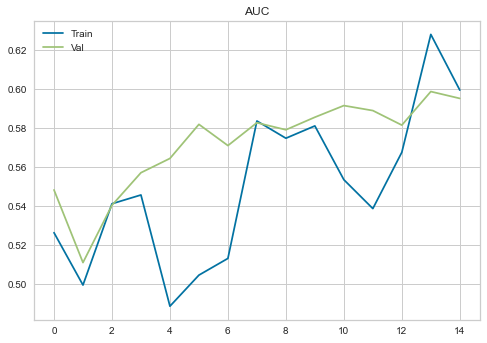

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.2
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 45.715832233428955
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 11ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


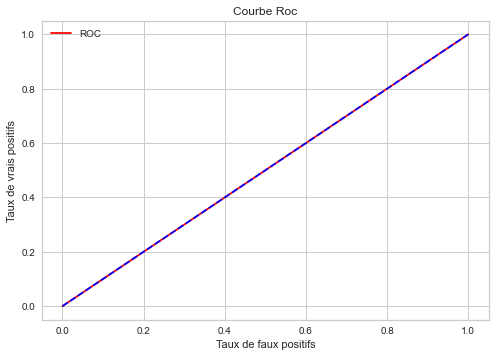

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


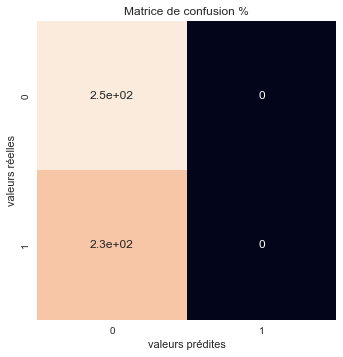

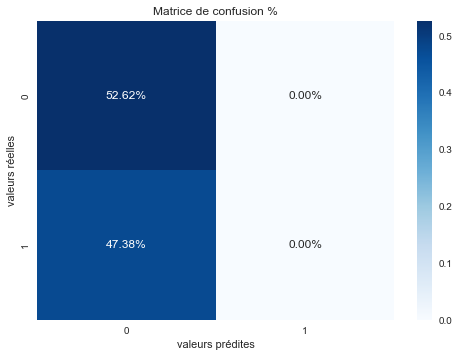


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 [==============================] - 4s 250ms/step - loss: 1.1462 - auc: 0.4985 - val_loss: 0.9300 - val_auc: 0.5021
Epoch 2/15
7/7 [==============================] - 1s 105ms/step - loss: 0.7971 - auc: 0.5172 - val_loss: 0.6990 - val_auc: 0.5070
Epoch 3/15
7/7 [==============================] - 1s 119ms/step - loss: 0.7672 - auc: 0.5165 - val_loss: 0.7823 - val_auc: 0.5232
Epoch 4/15
7/7 [==============================] - 1s 100ms/step - loss: 0.8645 - auc: 0.4862 - val_loss: 0.7833 - val_auc: 0.5340
Epoch 5/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7436 - auc: 0.5259 - val_loss: 0.7831 - val_auc: 0.5563
Epoch 6/15
7/7 [==============================] - 1s 98ms/step - loss: 0.7940 - auc: 0.5002 - val_loss: 0.7082 - val_auc: 0.5302
Epoch 7/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7295 - auc: 0.5269 - val_loss: 0.8126 - val_auc: 0.5606
Epoch 8/15
7/7 [==============================] - 1s 86ms/step - loss: 0.8000 - auc: 0.5274 - val_loss: 

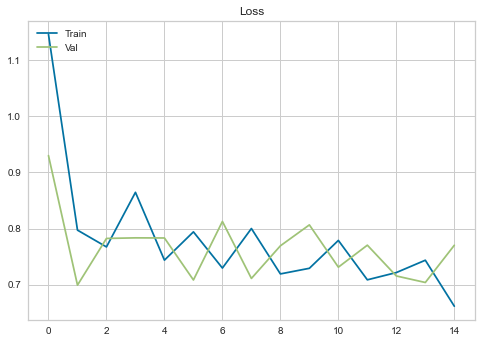

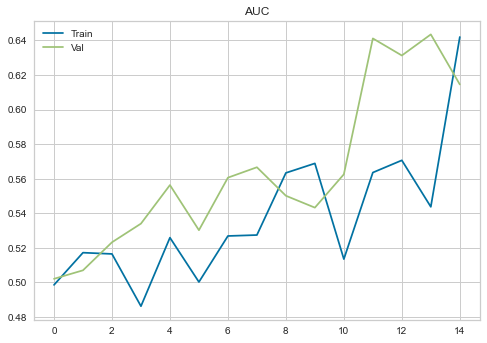

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 4s 290ms/step - loss: 1.0800 - auc: 0.5069 - val_loss: 0.8128 - val_auc: 0.5026
Epoch 2/15
7/7 [==============================] - 1s 99ms/step - loss: 0.8203 - auc: 0.5000 - val_loss: 0.8418 - val_auc: 0.5507
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.7536 - auc: 0.5318 - val_loss: 0.7951 - val_auc: 0.5242
Epoch 4/15
7/7 [==============================] - 1s 110ms/step - loss: 0.8800 - auc: 0.4811 - val_loss: 0.7958 - val_auc: 0.5735
Epoch 5/15
7/7 [==============================] - 1s 87ms/step - loss: 0.7513 - auc: 0.5267 - val_loss: 0.7077 - val_auc: 0.5870
Epoch 6/15
7/7 [==============================] - 1s 88ms/step - loss: 0.8017 - auc: 0.5092 - val_loss: 0.7439 - val_auc: 0.5839
Epoch 7/15
7/7 [==============================] - 1s 93

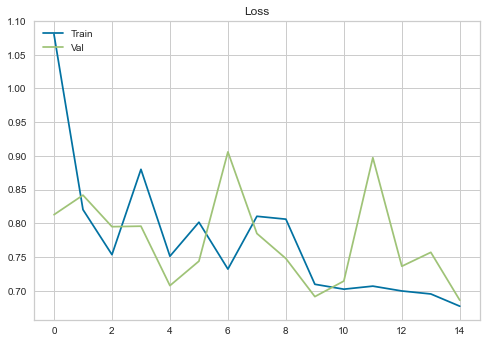

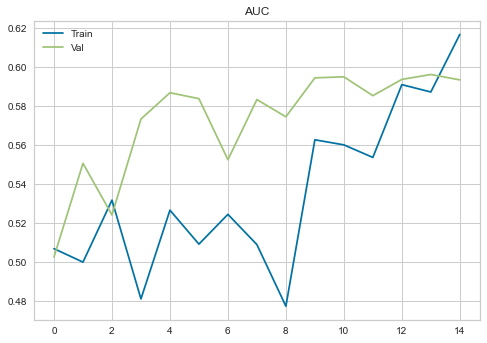

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 3s 156ms/step - loss: 1.0234 - auc: 0.5467 - val_loss: 0.8791 - val_auc: 0.5412
Epoch 2/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8374 - auc: 0.5187 - val_loss: 0.7354 - val_auc: 0.4997
Epoch 3/15
7/7 [==============================] - 1s 83ms/step - loss: 0.8005 - auc: 0.5089 - val_loss: 0.7331 - val_auc: 0.5465
Epoch 4/15
7/7 [==============================] - 1s 83ms/step - loss: 0.7788 - auc: 0.5299 - val_loss: 0.7034 - val_auc: 0.5773
Epoch 5/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8024 - auc: 0.5151 - val_loss: 0.6934 - val_auc: 0.5591
Epoch 6/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7133 - auc: 0.5288 - val_loss: 0.8891 - val_auc: 0.5532
Epoch 7/15
7/7 [==============================] - 1s 89m

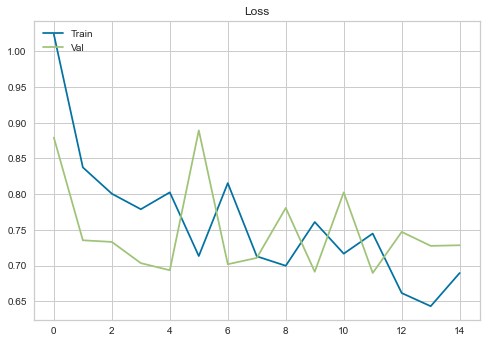

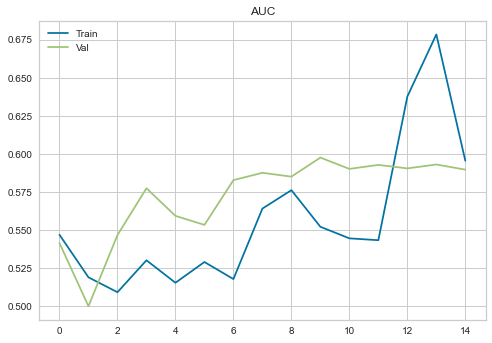

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 46.90482759475708
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 10ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


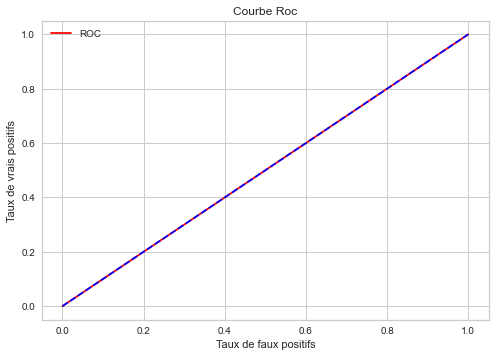

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


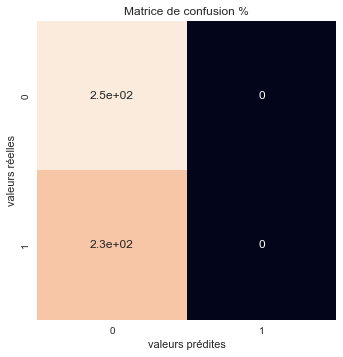

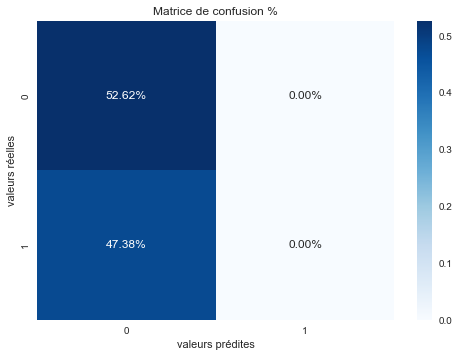


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.4
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 3s 226ms/step - loss: 1.0710 - auc: 0.5104 - val_loss: 0.7274 - val_auc: 0.5331
Epoch 2/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8285 - auc: 0.5288 - val_loss: 0.9197 - val_auc: 0.5416
Epoch 3/15
7/7 [==============================] - 1s 93ms/step - loss: 0.7761 - auc: 0.5149 - val_loss: 0.8360 - val_auc: 0.5245
Epoch 4/15
7/7 [==============================] - 1s 107ms/step - loss: 0.8262 - auc: 0.5139 - val_loss: 0.7089 - val_auc: 0.5100
Epoch 5/15
7/7 [==============================] - 1s 100ms/step - loss: 0.8041 - auc: 0.5011 - val_loss: 0.8169 - val_auc: 0.5395
Epoch 6/15
7/7 [==============================] - 1s 86ms/step - loss: 0.7670 - auc: 0.5117 - val_loss: 0.8399 - val_auc: 0.5274
Epoch 7/15
7/7 [==============================] - 1s 84ms/step - loss: 0.7931 - auc: 0.5149 - val_loss: 0.7147 - val_auc: 0.5470
Epoch 8/15
7/7 [==============================] - 1s 84ms/step - loss: 0.7124 - auc: 0.5367 - 

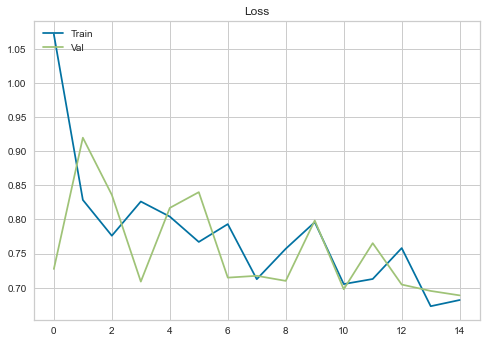

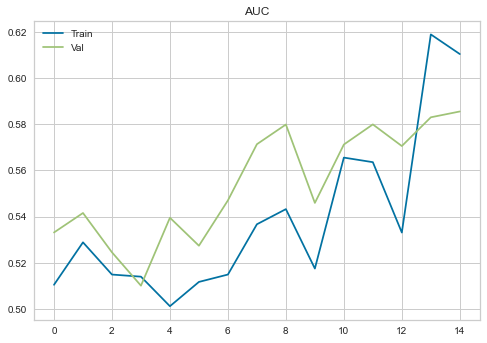

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 3s 239ms/step - loss: 1.2020 - auc: 0.4741 - val_loss: 0.7147 - val_auc: 0.5308
Epoch 2/15
7/7 [==============================] - 1s 86ms/step - loss: 0.7395 - auc: 0.4986 - val_loss: 0.9253 - val_auc: 0.5028
Epoch 3/15
7/7 [==============================] - 1s 80ms/step - loss: 0.9216 - auc: 0.4864 - val_loss: 0.7186 - val_auc: 0.5454
Epoch 4/15
7/7 [==============================] - 1s 82ms/step - loss: 0.7834 - auc: 0.5145 - val_loss: 0.7433 - val_auc: 0.5215
Epoch 5/15
7/7 [==============================] - 1s 82ms/step - loss: 0.7663 - auc: 0.5074 - val_loss: 0.7939 - val_auc: 0.5482
Epoch 6/15
7/7 [==============================] - 1s 81ms/step - loss: 0.8714 - auc: 0.4613 - val_loss: 0.7668 - val_auc: 0.5627
Epoch 7/15
7/7 [==============================] - 1s 85m

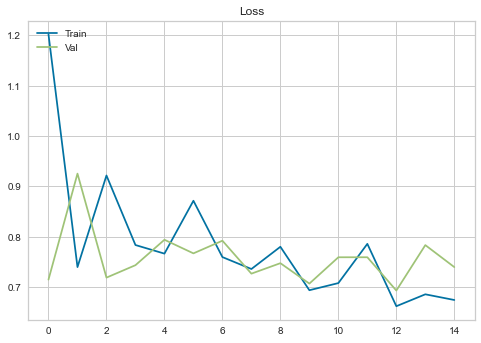

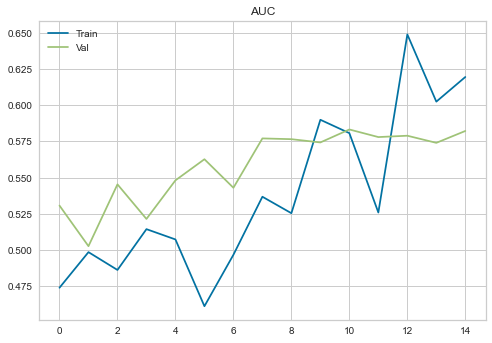

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 4s 261ms/step - loss: 1.0427 - auc: 0.4993 - val_loss: 0.9981 - val_auc: 0.5724
Epoch 2/15
7/7 [==============================] - 1s 114ms/step - loss: 0.9020 - auc: 0.4981 - val_loss: 0.8097 - val_auc: 0.5384
Epoch 3/15
7/7 [==============================] - 1s 96ms/step - loss: 0.7787 - auc: 0.5209 - val_loss: 0.7900 - val_auc: 0.5565
Epoch 4/15
7/7 [==============================] - 1s 83ms/step - loss: 0.8197 - auc: 0.4882 - val_loss: 1.0020 - val_auc: 0.5154
Epoch 5/15
7/7 [==============================] - 1s 82ms/step - loss: 0.7844 - auc: 0.5059 - val_loss: 0.7524 - val_auc: 0.5689
Epoch 6/15
7/7 [==============================] - 1s 83ms/step - loss: 0.7834 - auc: 0.5202 - val_loss: 0.9036 - val_auc: 0.5442
Epoch 7/15
7/7 [==============================] - 1s 87

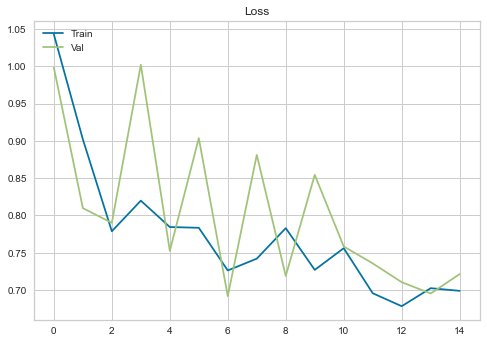

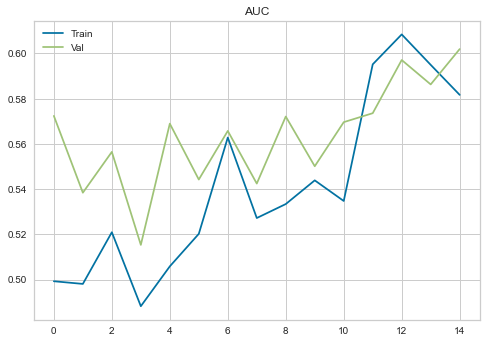

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.4
metric auc moyenne : 0.5
taux metier moyen : 0.46133168208639913
temps calcul : 44.770403146743774
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 9ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


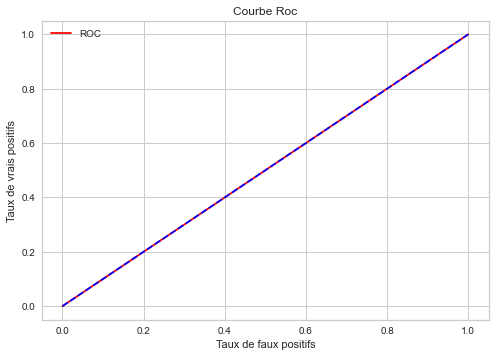

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


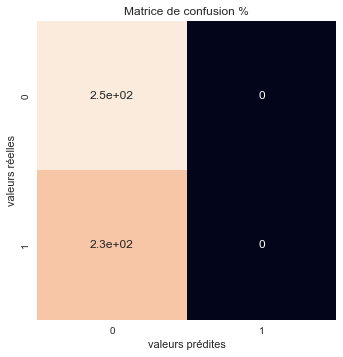

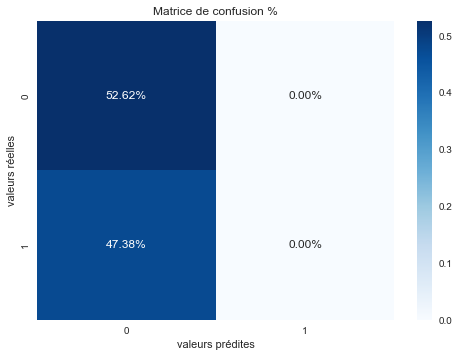


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  fast text
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 4s 238ms/step - loss: 1.0131 - auc: 0.4982 - val_loss: 0.7744 - val_auc: 0.5183
Epoch 2/15
7/7 [==============================] - 1s 142ms/step - loss: 0.8313 - auc: 0.5229 - val_loss: 0.6981 - val_auc: 0.5894
Epoch 3/15
7/7 [==============================] - 1s 84ms/step - loss: 0.8553 - auc: 0.5100 - val_loss: 0.7086 - val_auc: 0.6192
Epoch 4/15
7/7 [==============================] - 1s 90ms/step - loss: 0.8408 - auc: 0.5011 - val_loss: 0.8838 - val_auc: 0.5776
Epoch 5/15
7/7 [==============================] - 1s 113ms/step - loss: 0.7853 - auc: 0.5359 - val_loss: 0.6995 - val_auc: 0.6295
Epoch 6/15
7/7 [==============================] - 1s 142ms/step - loss: 0.8274 - auc: 0.5034 - val_loss: 0.7503 - val_auc: 0.6243
Epoch 7/15
7/7 [==============================] - 1s 107ms/step - loss: 0.8385 - auc: 0.5042 - val_loss: 0.9395 - val_auc: 0.6320
Epoch 8/15
7/7 [==============================] - 1s 97ms/step - loss: 0.8004 - auc: 0.5239 

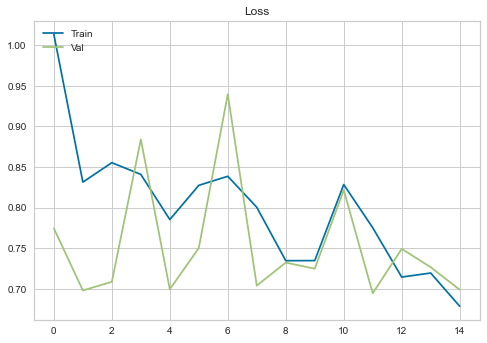

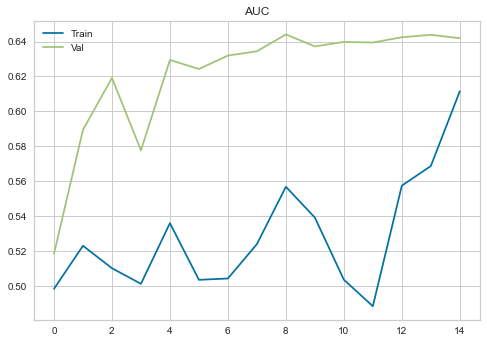

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 8s 451ms/step - loss: 1.0300 - auc: 0.5204 - val_loss: 0.7376 - val_auc: 0.5259
Epoch 2/15
7/7 [==============================] - 1s 83ms/step - loss: 0.7904 - auc: 0.5108 - val_loss: 0.8319 - val_auc: 0.5107
Epoch 3/15
7/7 [==============================] - 1s 100ms/step - loss: 0.7777 - auc: 0.5450 - val_loss: 0.7735 - val_auc: 0.5569
Epoch 4/15
7/7 [==============================] - 1s 104ms/step - loss: 0.8641 - auc: 0.4848 - val_loss: 0.7947 - val_auc: 0.5381
Epoch 5/15
7/7 [==============================] - 1s 82ms/step - loss: 0.8599 - auc: 0.4807 - val_loss: 0.6999 - val_auc: 0.5872
Epoch 6/15
7/7 [==============================] - 1s 85ms/step - loss: 0.8034 - auc: 0.4857 - val_loss: 0.9862 - val_auc: 0.5419
Epoch 7/15
7/7 [==============================] - 1s 9

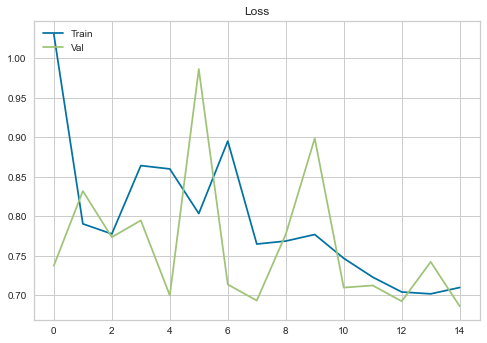

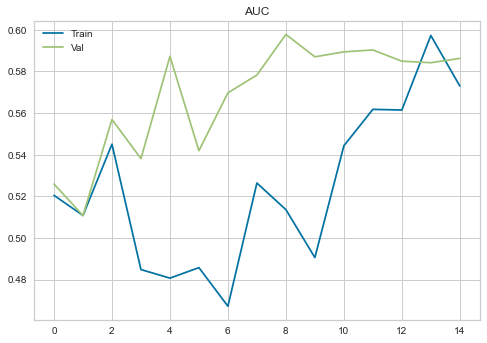

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 5s 426ms/step - loss: 1.0985 - auc: 0.4913 - val_loss: 0.6947 - val_auc: 0.5051
Epoch 2/15
7/7 [==============================] - 1s 107ms/step - loss: 0.8222 - auc: 0.5386 - val_loss: 0.7708 - val_auc: 0.4766
Epoch 3/15
7/7 [==============================] - 1s 95ms/step - loss: 0.7698 - auc: 0.5239 - val_loss: 0.6973 - val_auc: 0.5250
Epoch 4/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8773 - auc: 0.4875 - val_loss: 0.8011 - val_auc: 0.4842
Epoch 5/15
7/7 [==============================] - 1s 119ms/step - loss: 0.8462 - auc: 0.5014 - val_loss: 0.7004 - val_auc: 0.5076
Epoch 6/15
7/7 [==============================] - 1s 145ms/step - loss: 0.7965 - auc: 0.4730 - val_loss: 0.8759 - val_auc: 0.4920
Epoch 7/15
7/7 [==============================] - 1s 

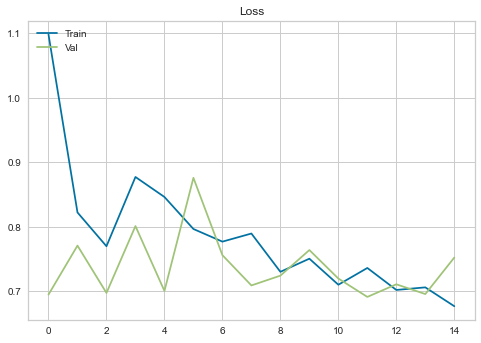

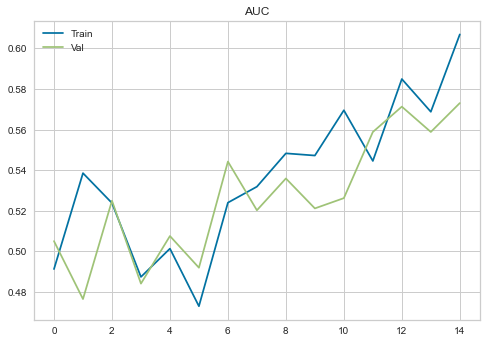

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed fast text
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863992
temps calcul : 58.92763304710388
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 11ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


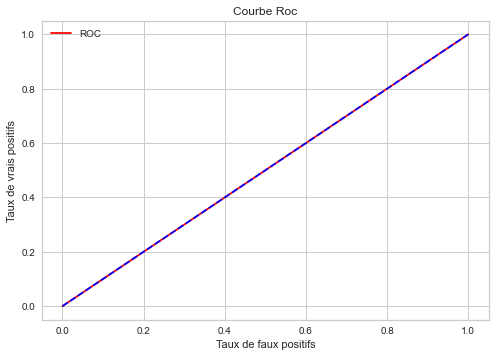

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


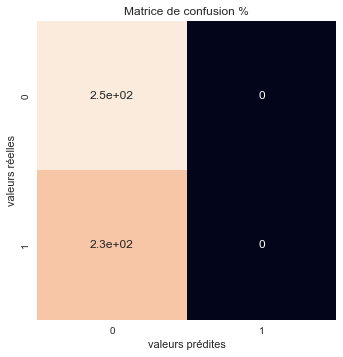

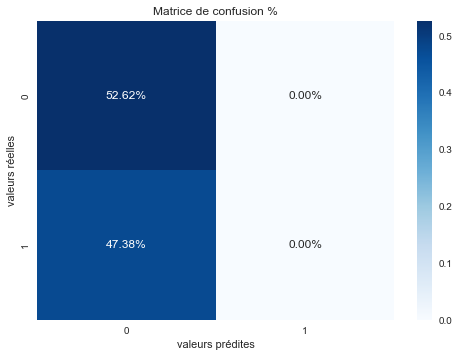


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
------------embeddings :  glove
------------params :  0.6
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 5s 523ms/step - loss: 1.0672 - auc: 0.5196 - val_loss: 0.8741 - val_auc: 0.5055
Epoch 2/15
7/7 [==============================] - 1s 131ms/step - loss: 0.8216 - auc: 0.4874 - val_loss: 0.7130 - val_auc: 0.5599
Epoch 3/15
7/7 [==============================] - 1s 92ms/step - loss: 0.8655 - auc: 0.5127 - val_loss: 0.6991 - val_auc: 0.5535
Epoch 4/15
7/7 [==============================] - 1s 82ms/step - loss: 0.8330 - auc: 0.4909 - val_loss: 0.6925 - val_auc: 0.5630
Epoch 5/15
7/7 [==============================] - 1s 83ms/step - loss: 0.7610 - auc: 0.4980 - val_loss: 0.7081 - val_auc: 0.5787
Epoch 6/15
7/7 [==============================] - 1s 84ms/step - loss: 0.7818 - auc: 0.5441 - val_loss: 0.7729 - val_auc: 0.5788
Epoch 7/15
7/7 [==============================] - 1s 81ms/step - loss: 0.8353 - auc: 0.5072 - val_loss: 0.6970 - val_auc: 0.6110
Epoch 8/15
7/7 [==============================] - 1s 83ms/step - loss: 0.7626 - auc: 0.5166 - v

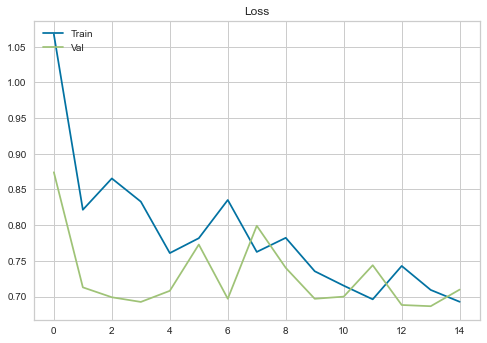

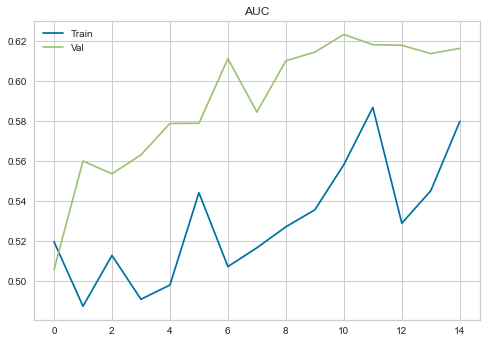

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 6s 283ms/step - loss: 1.0246 - auc: 0.5157 - val_loss: 0.7204 - val_auc: 0.5074
Epoch 2/15
7/7 [==============================] - 1s 94ms/step - loss: 0.8761 - auc: 0.4911 - val_loss: 0.7605 - val_auc: 0.5282
Epoch 3/15
7/7 [==============================] - 1s 89ms/step - loss: 0.7730 - auc: 0.5142 - val_loss: 0.7706 - val_auc: 0.5542
Epoch 4/15
7/7 [==============================] - 1s 80ms/step - loss: 0.8271 - auc: 0.5117 - val_loss: 0.8106 - val_auc: 0.5501
Epoch 5/15
7/7 [==============================] - 1s 94ms/step - loss: 0.7641 - auc: 0.5556 - val_loss: 0.8022 - val_auc: 0.5555
Epoch 6/15
7/7 [==============================] - 1s 105ms/step - loss: 0.8262 - auc: 0.5221 - val_loss: 0.7195 - val_auc: 0.5572
Epoch 7/15
7/7 [==============================] - 1s 87

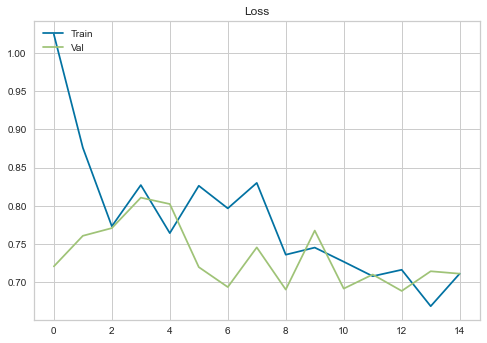

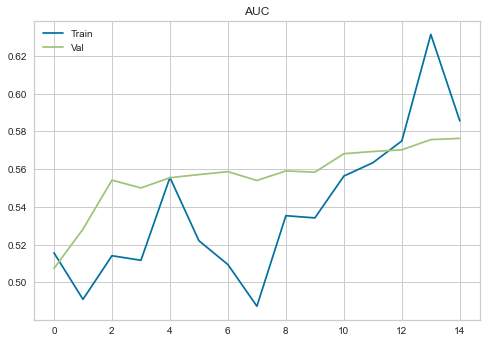

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 5s 311ms/step - loss: 1.0828 - auc: 0.5015 - val_loss: 0.8303 - val_auc: 0.5142
Epoch 2/15
7/7 [==============================] - 1s 83ms/step - loss: 0.8379 - auc: 0.5202 - val_loss: 0.8687 - val_auc: 0.5513
Epoch 3/15
7/7 [==============================] - 1s 101ms/step - loss: 0.8122 - auc: 0.5221 - val_loss: 0.7129 - val_auc: 0.6056
Epoch 4/15
7/7 [==============================] - 1s 93ms/step - loss: 0.8745 - auc: 0.4817 - val_loss: 0.7237 - val_auc: 0.5976
Epoch 5/15
7/7 [==============================] - 1s 100ms/step - loss: 0.8687 - auc: 0.4696 - val_loss: 0.7087 - val_auc: 0.6262
Epoch 6/15
7/7 [==============================] - 1s 114ms/step - loss: 0.7489 - auc: 0.5282 - val_loss: 0.6901 - val_auc: 0.6155
Epoch 7/15
7/7 [==============================] - 1s 

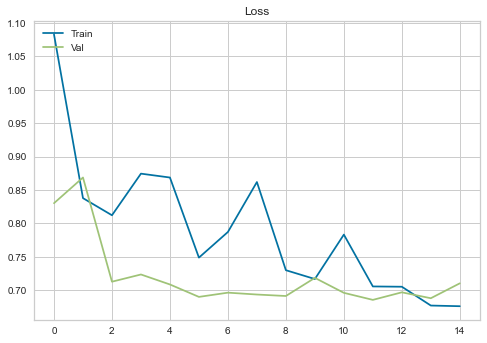

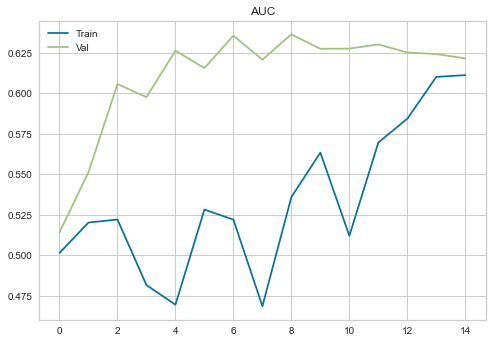

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_simple_ss_embed at 0x0000027EAA9DCD38>
embed glove
parametre : 0.6
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 53.35795044898987
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 0s 14ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:2
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


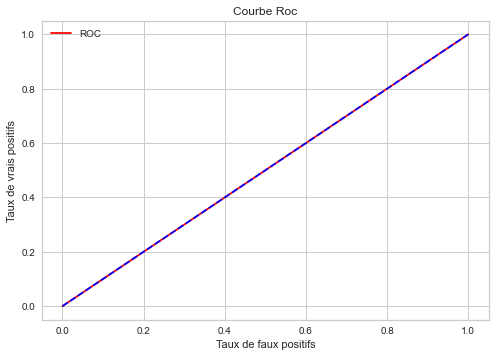

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


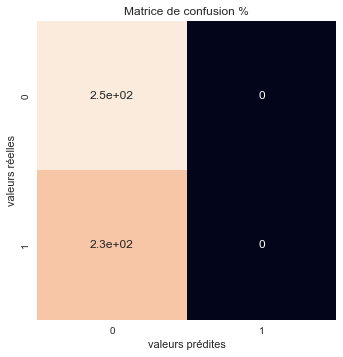

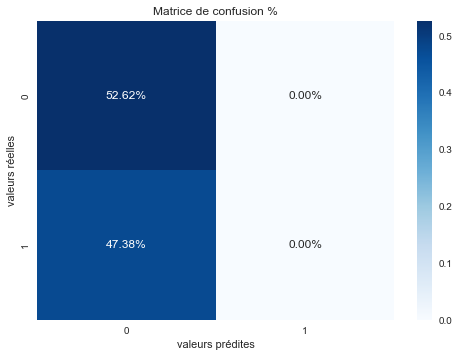


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed at 0x0000027F37157E58>
------------embeddings :  fast text
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 120s 4s/step - loss: 0.6928 - auc: 0.5257 - val_loss: 0.6904 - val_auc: 0.6115
Epoch 2/15
7/7 [==============================] - 14s 2s/step - loss: 0.6876 - auc: 0.6535 - val_loss: 0.6867 - val_auc: 0.6351
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 0.6814 - auc: 0.6801 - val_loss: 0.6811 - val_auc: 0.6617
Epoch 4/15
7/7 [==============================] - 14s 2s/step - loss: 0.6731 - auc: 0.7199 - val_loss: 0.6735 - val_auc: 0.6881
Epoch 5/15
7/7 [==============================] - 14s 2s/step - loss: 0.6608 - auc: 0.7523 - val_loss: 0.6632 - val_auc: 0.7004
Epoch 6/15
7/7 [==============================] - 13s 2s/step - loss: 0.6426 - auc: 0.7726 - val_loss: 0.6501 - val_auc: 0.7119
Epoch 7/15
7/7 [==============================] - 11s 2s/step - loss: 0.6221 - auc: 0.7890 - val_loss: 0.6385 - val_auc: 0.7225
Epoch 8/15
7/7 [==============================] - 12s 2s/step - loss: 0.6001 - auc: 0.7988 - val_loss: 

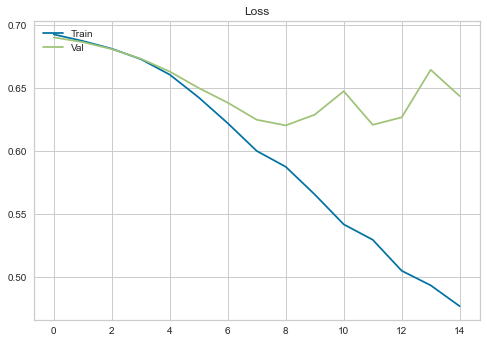

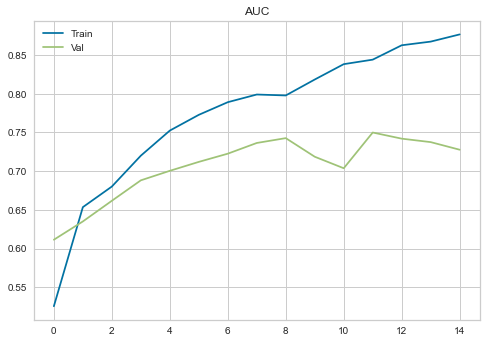

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 50s 4s/step - loss: 0.6914 - auc: 0.5634 - val_loss: 0.6904 - val_auc: 0.5875
Epoch 2/15
7/7 [==============================] - 17s 3s/step - loss: 0.6837 - auc: 0.6693 - val_loss: 0.6884 - val_auc: 0.6033
Epoch 3/15
7/7 [==============================] - 14s 2s/step - loss: 0.6749 - auc: 0.6869 - val_loss: 0.6818 - val_auc: 0.6347
Epoch 4/15
7/7 [==============================] - 17s 3s/step - loss: 0.6626 - auc: 0.7171 - val_loss: 0.6741 - val_auc: 0.6618
Epoch 5/15
7/7 [==============================] - 14s 2s/step - loss: 0.6449 - auc: 0.7425 - val_loss: 0.6743 - val_auc: 0.6575
Epoch 6/15
7/7 [==============================] - 14s 2s/step - loss: 0.6290 - auc: 0.7589 - val_loss: 0.6689 - val_auc: 0.6620
Epoch 7/15
7/7 [==============================] - 15s 2s/step -

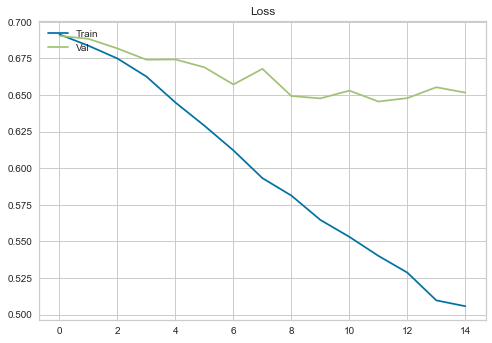

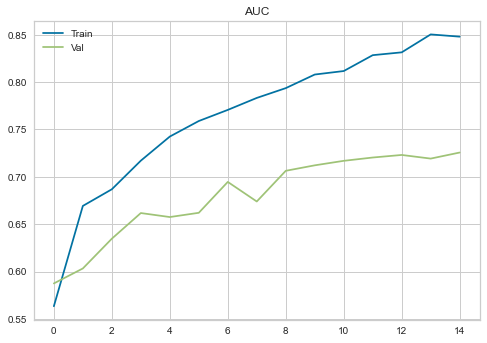

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 56s 4s/step - loss: 0.6929 - auc: 0.5181 - val_loss: 0.6895 - val_auc: 0.6397
Epoch 2/15
7/7 [==============================] - 16s 2s/step - loss: 0.6874 - auc: 0.6442 - val_loss: 0.6853 - val_auc: 0.6585
Epoch 3/15
7/7 [==============================] - 14s 2s/step - loss: 0.6814 - auc: 0.6849 - val_loss: 0.6802 - val_auc: 0.6665
Epoch 4/15
7/7 [==============================] - 14s 2s/step - loss: 0.6715 - auc: 0.7114 - val_loss: 0.6739 - val_auc: 0.6863
Epoch 5/15
7/7 [==============================] - 15s 2s/step - loss: 0.6609 - auc: 0.7282 - val_loss: 0.6624 - val_auc: 0.7247
Epoch 6/15
7/7 [==============================] - 16s 2s/step - loss: 0.6409 - auc: 0.7697 - val_loss: 0.6526 - val_auc: 0.7264
Epoch 7/15
7/7 [==============================] - 15s 2s/step -

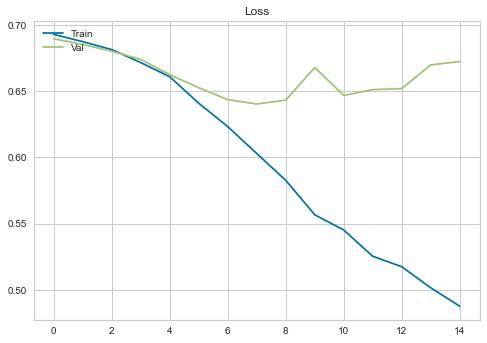

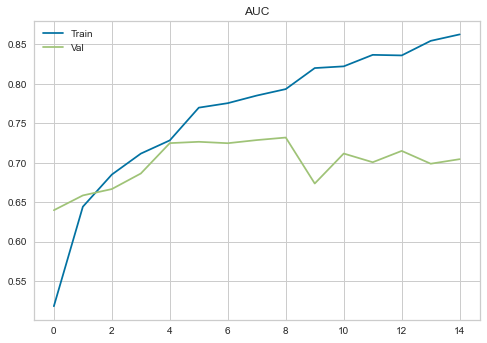

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed at 0x0000027F37157E58>
embed fast text
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 897.7248375415802
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 3s 211ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:3
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


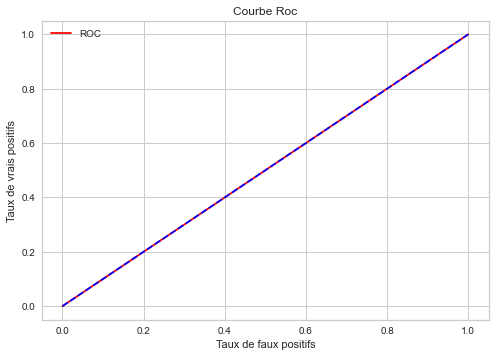

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


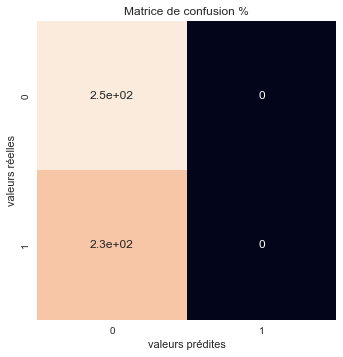

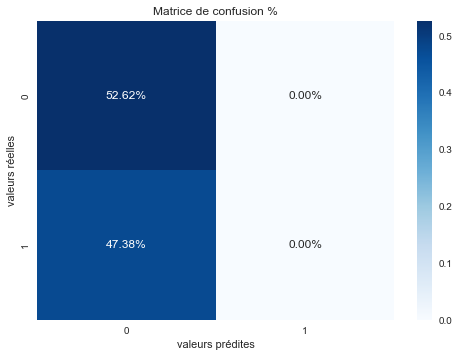


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed at 0x0000027F37157E58>
------------embeddings :  glove
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 35s 3s/step - loss: 0.6860 - auc: 0.6292 - val_loss: 0.6807 - val_auc: 0.6558
Epoch 2/15
7/7 [==============================] - 15s 2s/step - loss: 0.6571 - auc: 0.7713 - val_loss: 0.6652 - val_auc: 0.6785
Epoch 3/15
7/7 [==============================] - 19s 3s/step - loss: 0.6205 - auc: 0.8077 - val_loss: 0.6499 - val_auc: 0.6809
Epoch 4/15
7/7 [==============================] - 16s 2s/step - loss: 0.5746 - auc: 0.8334 - val_loss: 0.6378 - val_auc: 0.6912
Epoch 5/15
7/7 [==============================] - 17s 3s/step - loss: 0.5350 - auc: 0.8499 - val_loss: 0.6346 - val_auc: 0.6978
Epoch 6/15
7/7 [==============================] - 19s 3s/step - loss: 0.5007 - auc: 0.8629 - val_loss: 0.6374 - val_auc: 0.6969
Epoch 7/15
7/7 [==============================] - 14s 2s/step - loss: 0.4679 - auc: 0.8834 - val_loss: 0.6435 - val_auc: 0.6914
Epoch 8/15
7/7 [==============================] - 14s 2s/step - loss: 0.4288 - auc: 0.9133 - val_loss: 0

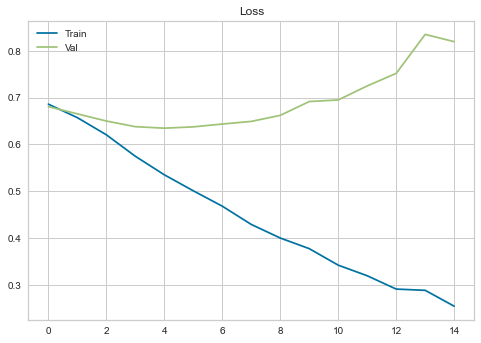

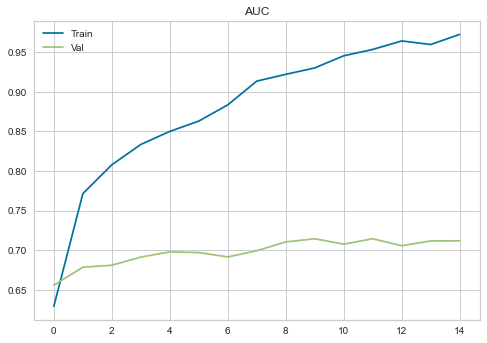

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 43s 3s/step - loss: 0.6894 - auc: 0.5744 - val_loss: 0.6854 - val_auc: 0.6322
Epoch 2/15
7/7 [==============================] - 12s 2s/step - loss: 0.6664 - auc: 0.7314 - val_loss: 0.6780 - val_auc: 0.6581
Epoch 3/15
7/7 [==============================] - 12s 2s/step - loss: 0.6461 - auc: 0.7518 - val_loss: 0.6576 - val_auc: 0.7040
Epoch 4/15
7/7 [==============================] - 12s 2s/step - loss: 0.6146 - auc: 0.7908 - val_loss: 0.6453 - val_auc: 0.7172
Epoch 5/15
7/7 [==============================] - 12s 2s/step - loss: 0.5851 - auc: 0.8124 - val_loss: 0.6265 - val_auc: 0.7310
Epoch 6/15
7/7 [==============================] - 12s 2s/step - loss: 0.5547 - auc: 0.8246 - val_loss: 0.6239 - val_auc: 0.7387
Epoch 7/15
7/7 [==============================] - 12s 2s/step -

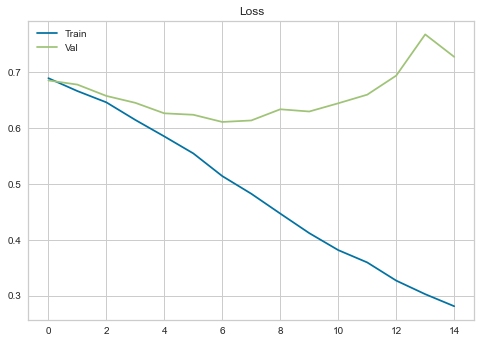

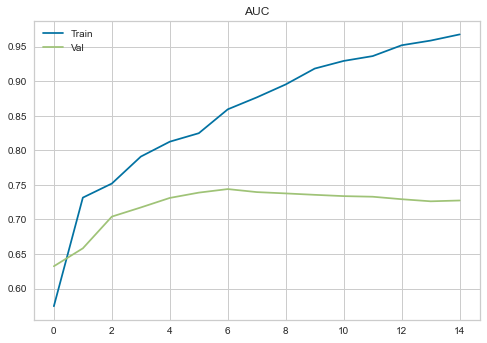

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 24s 2s/step - loss: 0.6897 - auc: 0.5936 - val_loss: 0.6797 - val_auc: 0.6772
Epoch 2/15
7/7 [==============================] - 11s 2s/step - loss: 0.6638 - auc: 0.7650 - val_loss: 0.6657 - val_auc: 0.7066
Epoch 3/15
7/7 [==============================] - 11s 2s/step - loss: 0.6317 - auc: 0.8035 - val_loss: 0.6476 - val_auc: 0.7154
Epoch 4/15
7/7 [==============================] - 11s 2s/step - loss: 0.5958 - auc: 0.8132 - val_loss: 0.6369 - val_auc: 0.7187
Epoch 5/15
7/7 [==============================] - 11s 2s/step - loss: 0.5501 - auc: 0.8472 - val_loss: 0.6318 - val_auc: 0.6916
Epoch 6/15
7/7 [==============================] - 11s 2s/step - loss: 0.5180 - auc: 0.8607 - val_loss: 0.6210 - val_auc: 0.7160
Epoch 7/15
7/7 [==============================] - 12s 2s/step -

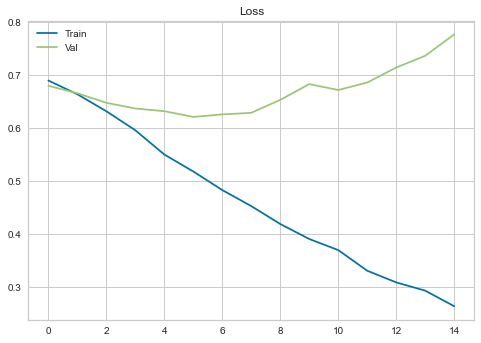

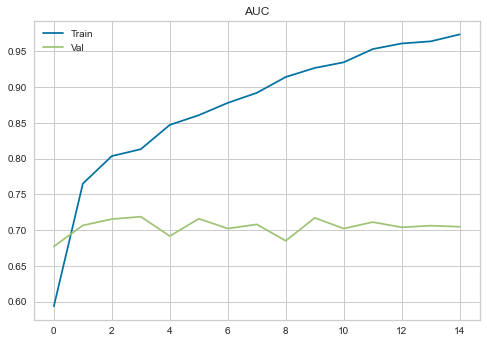

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed at 0x0000027F37157E58>
embed glove
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 673.2698736190796
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 3s 186ms/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:3
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


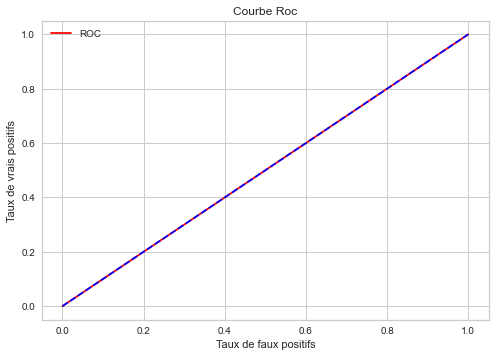

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


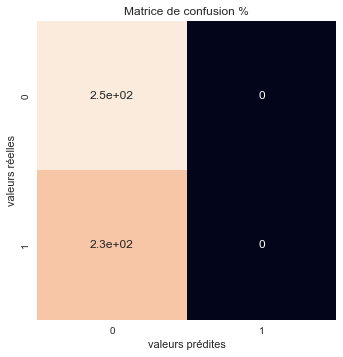

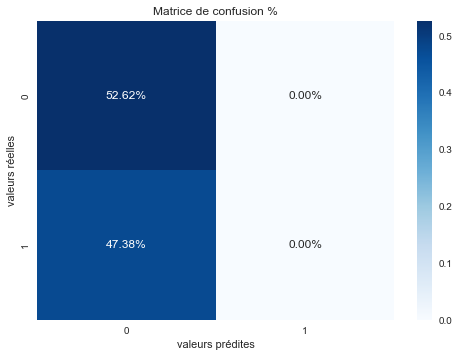


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
------------embeddings :  fast text
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 65s 7s/step - loss: 0.6945 - auc: 0.5407 - val_loss: 0.6727 - val_auc: 0.6677
Epoch 2/15
7/7 [==============================] - 32s 5s/step - loss: 0.6295 - auc: 0.7186 - val_loss: 0.6786 - val_auc: 0.7199
Epoch 3/15
7/7 [==============================] - 31s 5s/step - loss: 0.5692 - auc: 0.7705 - val_loss: 0.6142 - val_auc: 0.7549
Epoch 4/15
7/7 [==============================] - 33s 5s/step - loss: 0.5601 - auc: 0.7912 - val_loss: 0.6220 - val_auc: 0.7417
Epoch 5/15
7/7 [==============================] - 32s 5s/step - loss: 0.5018 - auc: 0.8337 - val_loss: 0.5822 - val_auc: 0.7751
Epoch 6/15
7/7 [==============================] - 32s 5s/step - loss: 0.4636 - auc: 0.8649 - val_loss: 0.6614 - val_auc: 0.7722
Epoch 7/15
7/7 [==============================] - 32s 5s/step - loss: 0.4237 - auc: 0.8902 - val_loss: 0.6306 - val_auc: 0.7725
Epoch 8/15
7/7 [==============================] - 34s 5s/step - loss: 0.3713 - auc: 0.9147 - val_loss: 0

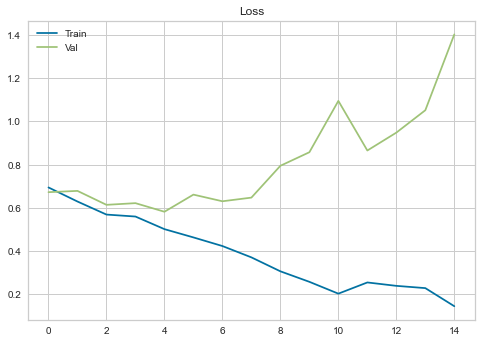

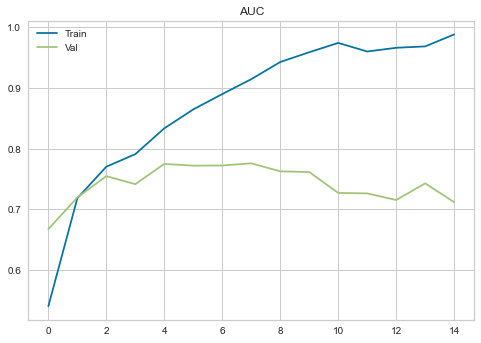

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 76s 7s/step - loss: 0.6899 - auc: 0.5626 - val_loss: 0.6800 - val_auc: 0.6427
Epoch 2/15
7/7 [==============================] - 40s 6s/step - loss: 0.6418 - auc: 0.7080 - val_loss: 0.6334 - val_auc: 0.7280
Epoch 3/15
7/7 [==============================] - 40s 6s/step - loss: 0.5831 - auc: 0.7797 - val_loss: 0.6086 - val_auc: 0.7484
Epoch 4/15
7/7 [==============================] - 39s 6s/step - loss: 0.5009 - auc: 0.8368 - val_loss: 0.6050 - val_auc: 0.7913
Epoch 5/15
7/7 [==============================] - 38s 6s/step - loss: 0.4529 - auc: 0.8702 - val_loss: 0.5638 - val_auc: 0.7954
Epoch 6/15
7/7 [==============================] - 46s 7s/step - loss: 0.3990 - auc: 0.9009 - val_loss: 0.6595 - val_auc: 0.7765
Epoch 7/15
7/7 [==============================] - 43s 6s/step -

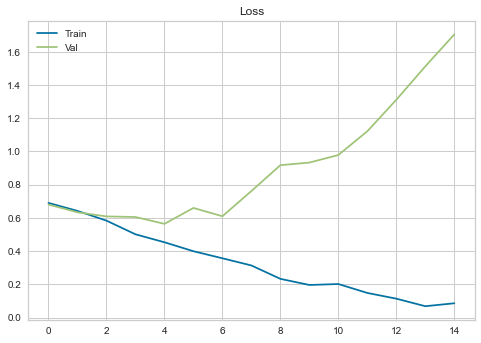

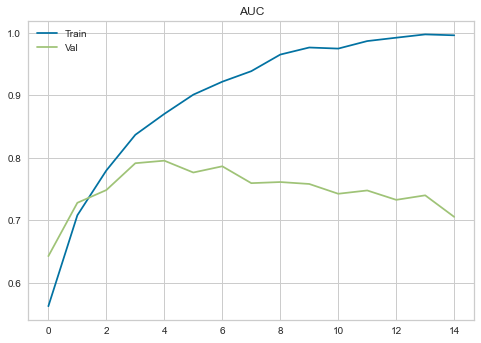

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 68s 7s/step - loss: 0.6885 - auc: 0.5691 - val_loss: 0.6795 - val_auc: 0.6767
Epoch 2/15
7/7 [==============================] - 39s 6s/step - loss: 0.6416 - auc: 0.6952 - val_loss: 0.6258 - val_auc: 0.7236
Epoch 3/15
7/7 [==============================] - 41s 6s/step - loss: 0.5575 - auc: 0.8009 - val_loss: 0.5946 - val_auc: 0.7449
Epoch 4/15
7/7 [==============================] - 46s 7s/step - loss: 0.4907 - auc: 0.8458 - val_loss: 0.6565 - val_auc: 0.7478
Epoch 5/15
7/7 [==============================] - 40s 6s/step - loss: 0.4447 - auc: 0.8764 - val_loss: 0.6046 - val_auc: 0.7687
Epoch 6/15
7/7 [==============================] - 41s 6s/step - loss: 0.3804 - auc: 0.9100 - val_loss: 0.6811 - val_auc: 0.7535
Epoch 7/15
7/7 [==============================] - 45s 6s/step -

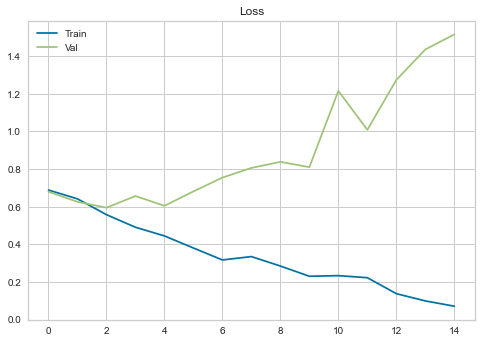

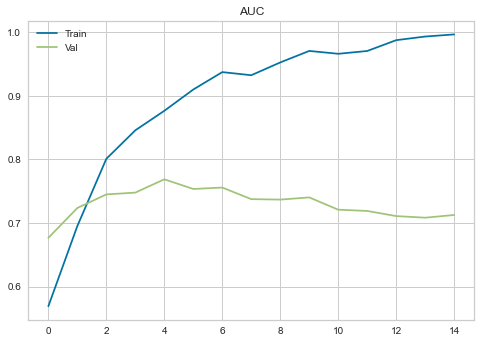

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
embed fast text
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 1911.6510379314423
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 16s 1s/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:4
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


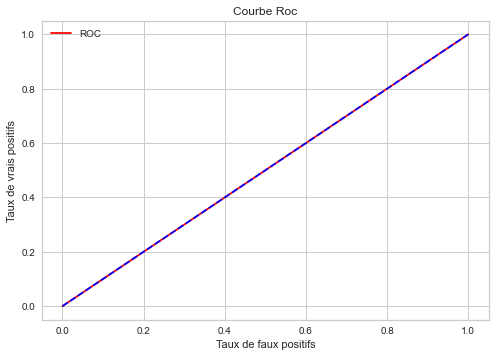

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


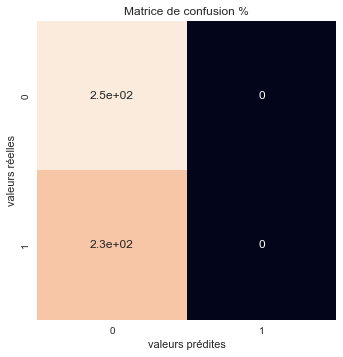

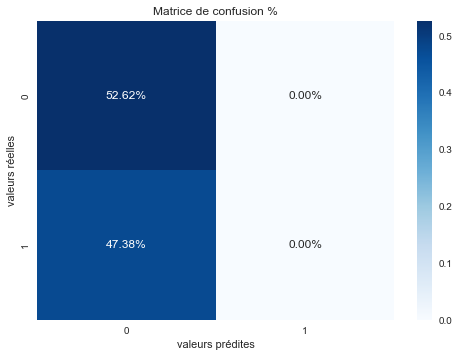


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000
----------------------------------------------
-----function :  <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
------------embeddings :  glove
------------params :  0
X shape :  (1112, 115)
y shape :  [0. 0. 0. ... 0. 0. 1.]
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/15
7/7 [==============================] - 53s 6s/step - loss: 0.7050 - auc: 0.5440 - val_loss: 0.6580 - val_auc: 0.6743
Epoch 2/15
7/7 [==============================] - 33s 5s/step - loss: 0.5828 - auc: 0.7681 - val_loss: 0.6626 - val_auc: 0.7052
Epoch 3/15
7/7 [==============================] - 33s 5s/step - loss: 0.4791 - auc: 0.8500 - val_loss: 0.6664 - val_auc: 0.7386
Epoch 4/15
7/7 [==============================] - 34s 5s/step - loss: 0.3435 - auc: 0.9255 - val_loss: 0.8327 - val_auc: 0.7182
Epoch 5/15
7/7 [==============================] - 34s 5s/step - loss: 0.2204 - auc: 0.9695 - val_loss: 1.0192 - val_auc: 0.7083
Epoch 6/15
7/7 [==============================] - 33s 5s/step - loss: 0.1340 - auc: 0.9889 - val_loss: 1.4835 - val_auc: 0.6754
Epoch 7/15
7/7 [==============================] - 39s 6s/step - loss: 0.1074 - auc: 0.9919 - val_loss: 1.4996 - val_auc: 0.6861
Epoch 8/15
7/7 [==============================] - 51s 7s/step - loss: 0.0553 - auc: 0.9985 - val_loss: 1

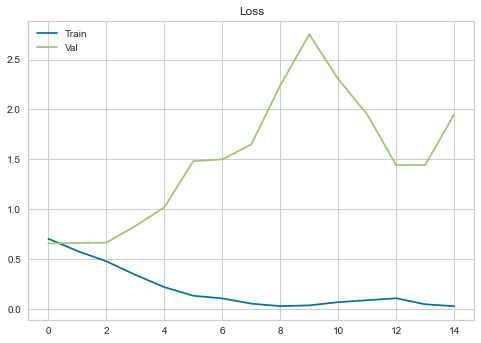

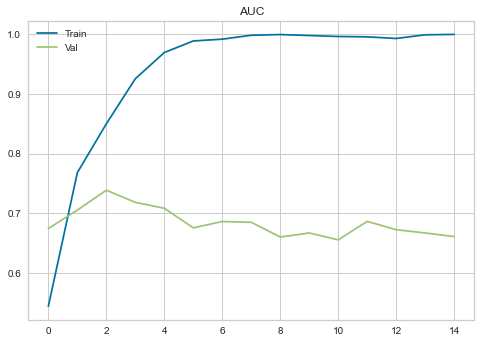

For fold 0:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (741, 115)
y_train shape :  (741,)
x_test shape :  (371, 115)
y_test shape :  (371,)
Epoch 1/15
7/7 [==============================] - 81s 10s/step - loss: 0.7014 - auc: 0.5643 - val_loss: 0.6445 - val_auc: 0.6829
Epoch 2/15
7/7 [==============================] - 49s 7s/step - loss: 0.6421 - auc: 0.7192 - val_loss: 0.6527 - val_auc: 0.7412
Epoch 3/15
7/7 [==============================] - 49s 7s/step - loss: 0.5706 - auc: 0.7973 - val_loss: 0.5817 - val_auc: 0.7802
Epoch 4/15
7/7 [==============================] - 43s 6s/step - loss: 0.4171 - auc: 0.8928 - val_loss: 0.8016 - val_auc: 0.7587
Epoch 5/15
7/7 [==============================] - 36s 5s/step - loss: 0.3631 - auc: 0.9198 - val_loss: 0.6750 - val_auc: 0.7665
Epoch 6/15
7/7 [==============================] - 32s 5s/step - loss: 0.2558 - auc: 0.9631 - val_loss: 0.8718 - val_auc: 0.7563
Epoch 7/15
7/7 [==============================] - 33s 5s/step 

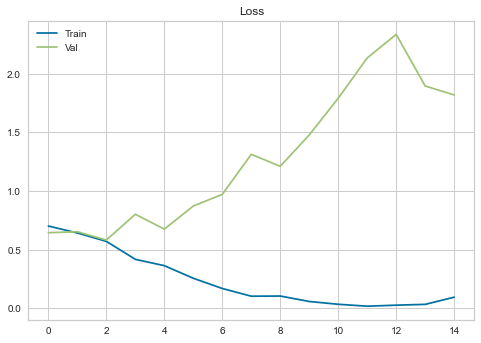

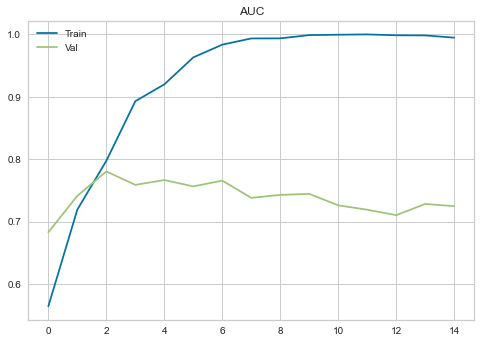

For fold 1:
AUC: 0.5
f1-score: 0.0
score métier:0.4609164420485175
x_train shape :  (742, 115)
y_train shape :  (742,)
x_test shape :  (370, 115)
y_test shape :  (370,)
Epoch 1/15
7/7 [==============================] - 97s 8s/step - loss: 0.6876 - auc: 0.6030 - val_loss: 0.6272 - val_auc: 0.7179
Epoch 2/15
7/7 [==============================] - 35s 5s/step - loss: 0.5366 - auc: 0.8179 - val_loss: 0.6891 - val_auc: 0.7268
Epoch 3/15
7/7 [==============================] - 34s 5s/step - loss: 0.4042 - auc: 0.8965 - val_loss: 0.6825 - val_auc: 0.7299
Epoch 4/15
7/7 [==============================] - 34s 5s/step - loss: 0.3062 - auc: 0.9393 - val_loss: 0.7839 - val_auc: 0.7252
Epoch 5/15
7/7 [==============================] - 34s 5s/step - loss: 0.2311 - auc: 0.9668 - val_loss: 0.9277 - val_auc: 0.7029
Epoch 6/15
7/7 [==============================] - 34s 5s/step - loss: 0.1286 - auc: 0.9917 - val_loss: 1.2164 - val_auc: 0.7102
Epoch 7/15
7/7 [==============================] - 35s 5s/step -

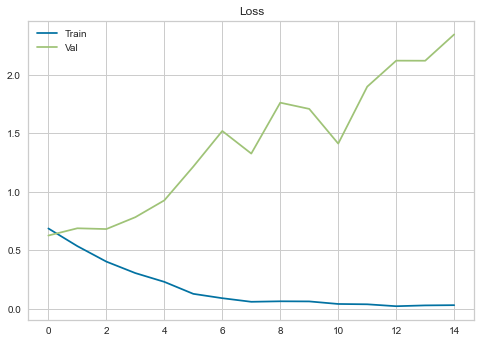

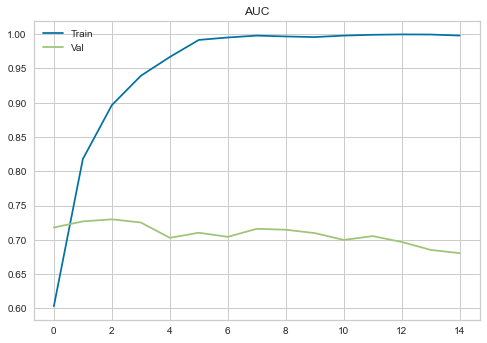

For fold 2:
AUC: 0.5
f1-score: 0.0
score métier:0.46216216216216216
---------------------------------------------------------
---------------------------------------------------------
function <function funct_model_bilstm_embed_2 at 0x0000027F0ED18048>
embed glove
parametre : 0
metric auc moyenne : 0.5
taux metier moyen : 0.4613316820863991
temps calcul : 1870.0825922489166
---------------------------------------------------------
---------------------------------------------------------
15/15 [==============================] - 18s 1s/step
-----------------prediction : 0
(477,)
FULL Métrique Métier :  0.42641509433962266
For test:4
AUC: 0.5
f1-score: 0.0
score métier:0.42641509433962266
0.5


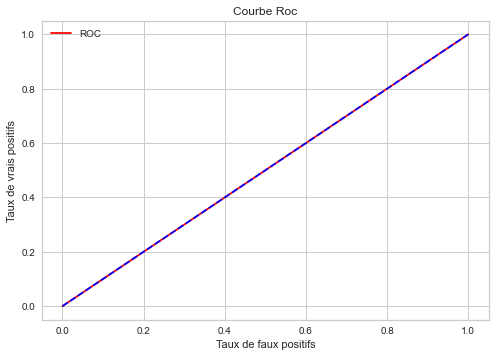

FULL Métrique Métier :  0.42641509433962266
Mean Absolute Error: 0.47379454926624737
Mean Squared Error: 0.47379454926624737
Root Mean Squared Error: 0.6883273561803623


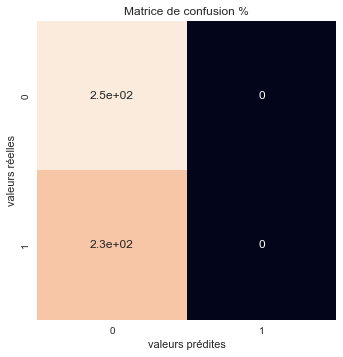

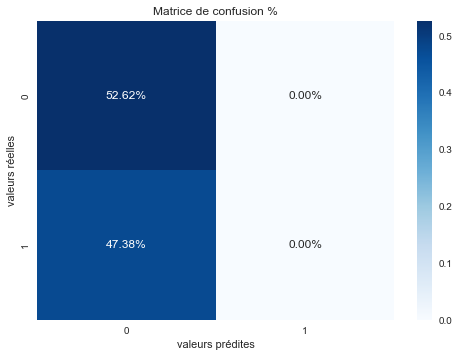


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.000

Sur le jeu de test precision : 0.000

Sur le jeu de test recall : 0.000


C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [247]:
metric_history = []
test_history_n = []
search_best_model(df, embeddings)

In [248]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()
train_graph=df_metrics_history.copy()

In [249]:
train_graph

index  method                                              model  \
0       0       1  <keras.engine.sequential.Sequential object at ...   
1       1       1  <keras.engine.sequential.Sequential object at ...   
2       2       1  <keras.engine.sequential.Sequential object at ...   
3       3       1  <keras.engine.sequential.Sequential object at ...   
4       4       1  <keras.engine.sequential.Sequential object at ...   
5       5       1  <keras.engine.sequential.Sequential object at ...   
6       6       2  <keras.engine.sequential.Sequential object at ...   
7       7       2  <keras.engine.sequential.Sequential object at ...   
8       8       2  <keras.engine.sequential.Sequential object at ...   
9       9       2  <keras.engine.sequential.Sequential object at ...   
10     10       2  <keras.engine.sequential.Sequential object at ...   
11     11       2  <keras.engine.sequential.Sequential object at ...   
12     12       3  <keras.engine.sequential.Sequential object at ...   
13     13       3  <keras.engine.sequential.Sequential object at ...   
14     14       4  <keras.engine.sequential.Sequential object at ...   
15     15       4  <keras.engine.sequential.Sequential object at ...   

                                             function  auc    metier  \
0   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
2   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
3   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
4   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
5   <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
6   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
7   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
8   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
9   <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
10  <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
11  <function funct_model_simple_ss_embed at 0x000...  0.5  0.461332   
12  <function funct_model_bilstm_embed at 0x000002...  0.5  0.461332   
13  <function funct_model_bilstm_embed at 0x000002...  0.5  0.461332   
14  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.461332   
15  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.461332   

           time name_embed                                          embbeding  \
0    191.995958  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     39.172347      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     40.765499  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     36.880458      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     38.462346  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5     37.909708      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6     42.254108  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7     45.715832      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8     46.904828  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9     44.770403      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10    58.927633  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
11    53.357950      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12   897.724838  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
13   673.269874      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
14  1911.651038  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15  1870.082592      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

    parameters  
0          0.2  
1          0.2  
2          0.4  
3          0.4  
4          0.6  
5          0.6  
6          0.2  
7          0.2  
8          0.4  
9     

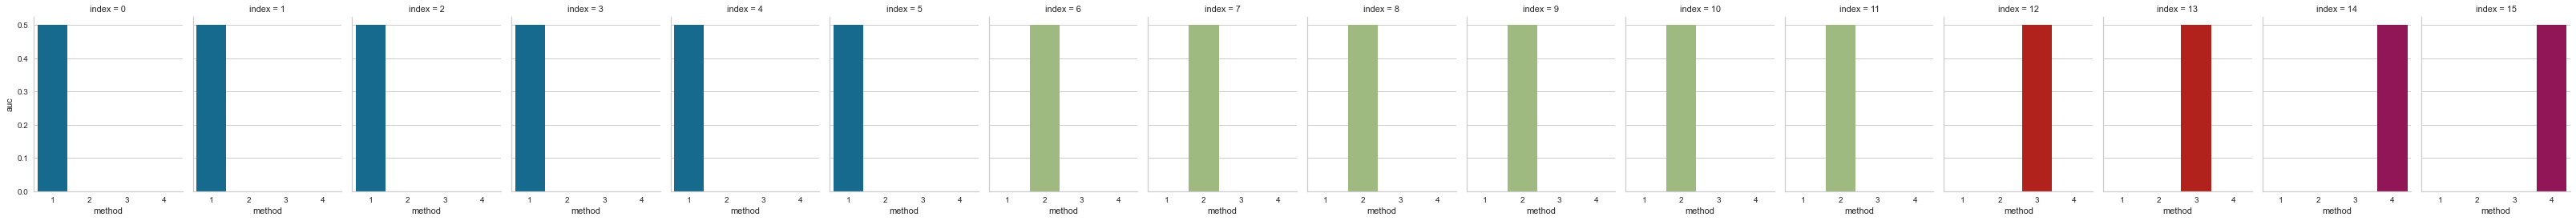

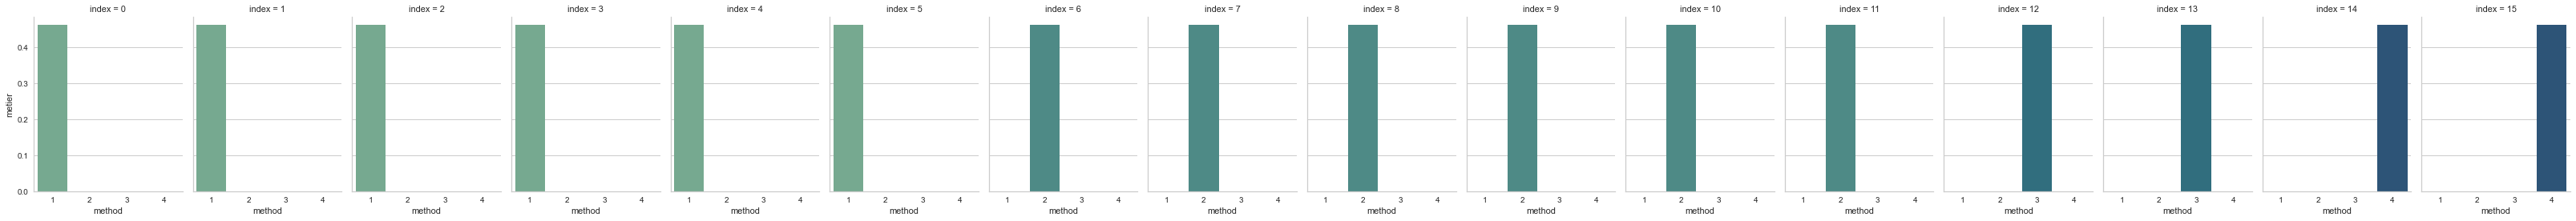

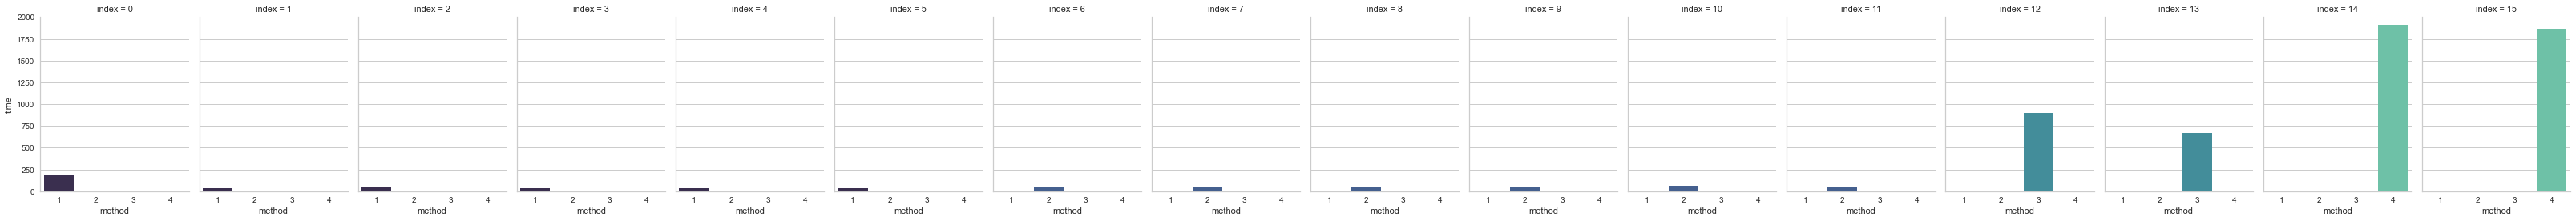

In [250]:
sns.catplot(x="method", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)
sns.catplot(x="method", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)
sns.catplot(x="method", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [254]:
df_metrics_history.head(2)

index  method                                              model  \
0      0       1  <keras.engine.sequential.Sequential object at ...   
1      1       1  <keras.engine.sequential.Sequential object at ...   

                                            function  auc    metier  \
0  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   

         time name_embed                                          embbeding  \
0  191.995958  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   39.172347      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

   parameters  
0         0.2  
1         0.2

In [261]:
df_metrics_history["funct_model"] = df_metrics_history["function"] 

In [262]:
df_metrics_history.head(2)

index  method                                              model  \
0      0       1  <keras.engine.sequential.Sequential object at ...   
1      1       1  <keras.engine.sequential.Sequential object at ...   

                                            function  auc    metier  \
0  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   
1  <function funct_model_simple at 0x0000027E11A1...  0.5  0.461332   

         time name_embed                                          embbeding  \
0  191.995958  fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1   39.172347      glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

   parameters                                        funct_model  
0         0.2  <function funct_model_simple at 0x0000027E11A1...  
1         0.2  <function funct_model_simple at 0x0000027E11A1...

In [294]:
df_metrics_history_test=pd.DataFrame(test_history_n).reset_index()
test_graph=df_metrics_history_test.copy()

In [295]:
df_metrics_history_test

index  method                                              model  \
0       0       1  <keras.engine.sequential.Sequential object at ...   
1       1       1  <keras.engine.sequential.Sequential object at ...   
2       2       1  <keras.engine.sequential.Sequential object at ...   
3       3       1  <keras.engine.sequential.Sequential object at ...   
4       4       1  <keras.engine.sequential.Sequential object at ...   
5       5       1  <keras.engine.sequential.Sequential object at ...   
6       6       2  <keras.engine.sequential.Sequential object at ...   
7       7       2  <keras.engine.sequential.Sequential object at ...   
8       8       2  <keras.engine.sequential.Sequential object at ...   
9       9       2  <keras.engine.sequential.Sequential object at ...   
10     10       2  <keras.engine.sequential.Sequential object at ...   
11     11       2  <keras.engine.sequential.Sequential object at ...   
12     12       3  <keras.engine.sequential.Sequential object at ...   
13     13       3  <keras.engine.sequential.Sequential object at ...   
14     14       4  <keras.engine.sequential.Sequential object at ...   
15     15       4  <keras.engine.sequential.Sequential object at ...   

                                             function  auc    metier  \
0   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
1   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
2   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
3   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
4   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
5   <function funct_model_simple at 0x0000027E11A1...  0.5  0.426415   
6   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
7   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
8   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
9   <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
10  <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
11  <function funct_model_simple_ss_embed at 0x000...  0.5  0.426415   
12  <function funct_model_bilstm_embed at 0x000002...  0.5  0.426415   
13  <function funct_model_bilstm_embed at 0x000002...  0.5  0.426415   
14  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.426415   
15  <function funct_model_bilstm_embed_2 at 0x0000...  0.5  0.426415   

         time name_embedd                                          embbeding  \
0    2.169956   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1    2.324220       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2    1.985316   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3    2.300685       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4    2.123386   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5    2.126399       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6    2.660528   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7    2.807645       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8    2.170822   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9    2.074769       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10   2.608727   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
11   2.357906       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12   5.817344   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
13   4.678314       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
14  17.973743   fast text  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15  20.927022       glove  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

    parameters  
0          0.2  
1          0.2  
2          0.4  
3          0.4  
4          0.6  
5          0.6  
6          0.2  
7          0.2  
8          0.4  
9          0.4  
10    

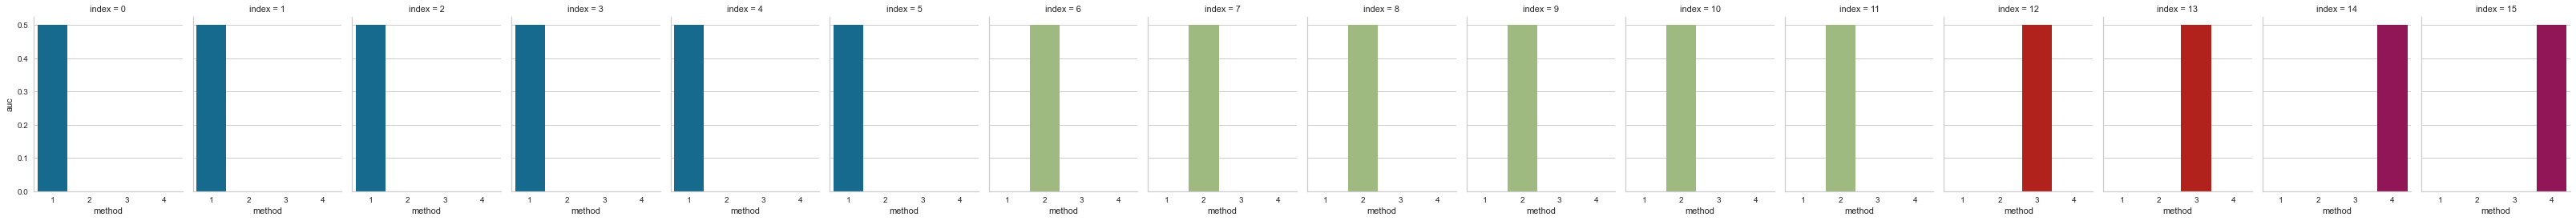

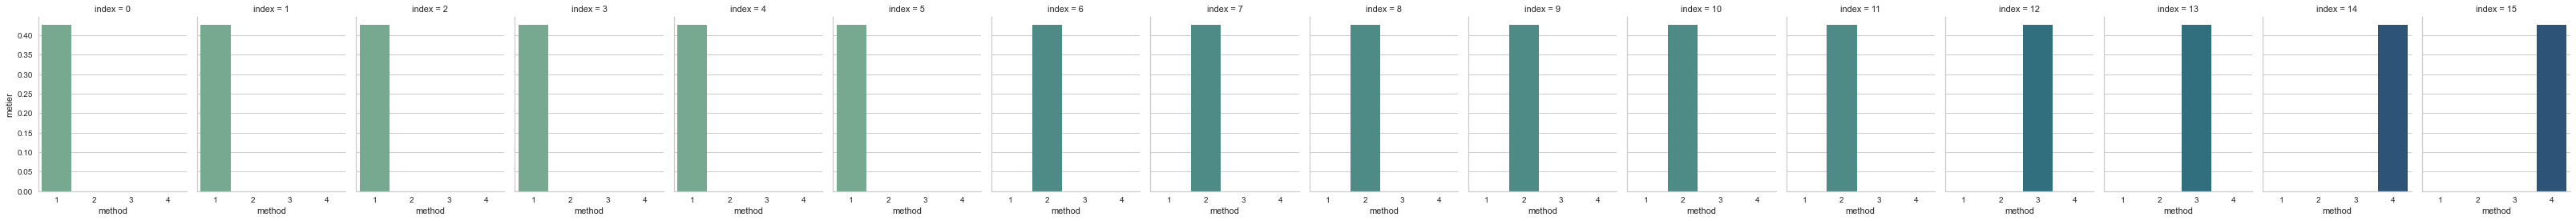

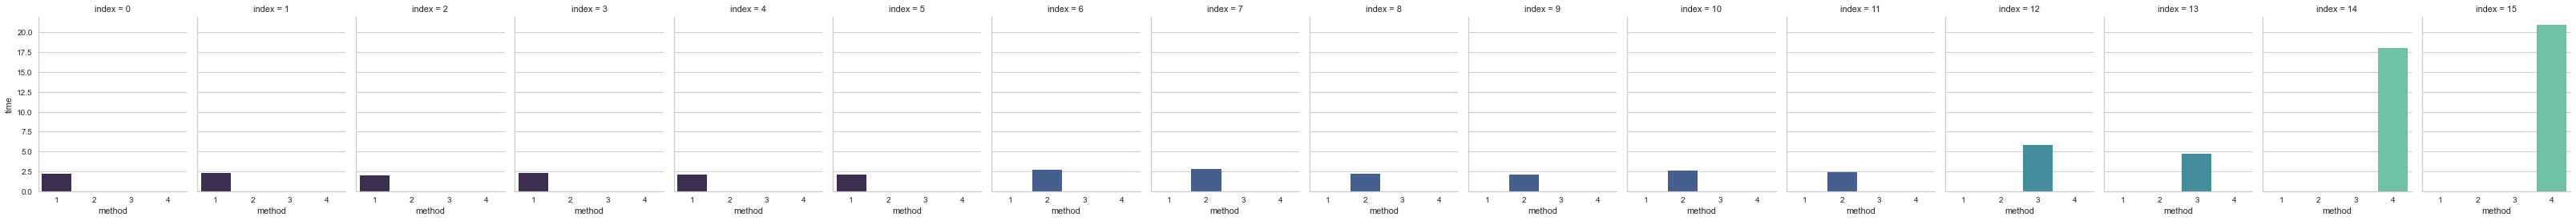

In [297]:
sns.catplot(x="method", y="auc",
                col="index",
                data=test_graph, kind="bar",
                height=4, aspect=.7)
sns.catplot(x="method", y="metier",
                col="index",
                data=test_graph, kind="bar",palette="crest",
                height=4, aspect=.7)
sns.catplot(x="method", y="time",
                col="index",
                data=test_graph, kind="bar",palette="mako",
                height=4, aspect=.7)


Nous allons réaliser un pipeline différent pour Bert afin que ce soit plus clair.

## Bert

In [292]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [293]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

Nous allons utiliser un modèle pré-entrainé Bert qui a été entrainé sur une grande quantité de données. C'est donc plus intéressant ici d'utiliser ce type de modèle car nous recherchons les sentiments des tweets. 

Nous décidons d'utiliser le modèle bert de base, qui est composé de 12 couches, 768 cachés, 12 têtes, 110 millions de paramètres.<br>
Plus d'information, ici : https://github.com/google-research/bert

In [18]:
num_classes=len(df.target.unique())

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)



loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\aurel/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

Le tokenizer permet de mettre en minuscule les mots et les tokenizés. Un mot hors vocabulaire est découpé en deux avec des "##".<br>
Regardons un exemple :

In [19]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


calculates a été découpé en deux mots :  'calculate', '##s' car il n'existe pas dans le vocabulaire.

Faisons la même chose pour nos données

In [20]:
sentences=df['tweet_lemma_join']
labels=df['target']
len(sentences),len(labels)

(1589, 1589)

Le but est donc de tokenizer nos données pour remplir les paramètres du modèle.<br>
Nous en avons 3 : 
- input_ids : les identifiants d'entrée obtenus à partir du tokenizer
- attention_mask : Masquer les valeurs sélectionnées dans [0, 1]: 1 pour les jetons non masqués , 0 pour les jetons marqués (0 si le jeton est ajouté par remplissage), obtenus aussi avec le tokenizer.
- labels : la variable cible pour calculer la perte de classification ou de régression.  Si num_classes == 1, une perte de régression est calculée (perte moyenne-carrée), si num_classes > 1, une perte de classification est calculée (entropie croisée)

In [21]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(1589, 1589, 1589)

Sauvegarde des parametres dans des fichiers pickle pour ne pas refaire cette étape

In [22]:
import pickle
print('Preparing the pickle file.....')

pickle_inp_path='./output/bert_inp.pkl'
pickle_mask_path='./output/bert_mask.pkl'
pickle_label_path='./output/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))
 

Preparing the pickle file.....
Pickle files saved as  ./output/bert_inp.pkl ./output/bert_mask.pkl ./output/bert_label.pkl
Loading the saved pickle files..
Input shape (1589, 64) Attention mask shape (1589, 64) Input label shape (1589,)


Division en train, test

In [23]:

train_inp,val_inp,train_label,val_label,train_mask,val_mask=pk_multi.train_test_split(input_ids,labels,attention_masks,test_size=0.3)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

 


Train inp shape (1112, 64) Val input shape (477, 64)
Train label shape (1112,) Val label shape (477,)
Train attention mask shape (1112, 64) Val attention mask shape (477, 64)


Nous configurons ici les différents paramètres : perte, métrique et ceux de l'optimiseur

In [24]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./output/models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('auc')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [25]:

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


Epoch 1/4
35/35 [==============================] - 278s 7s/step - loss: 0.6746 - auc: 0.5818 - val_loss: 0.6143 - val_auc: 0.6792
Epoch 2/4
35/35 [==============================] - 251s 7s/step - loss: 0.5434 - auc: 0.7401 - val_loss: 0.5822 - val_auc: 0.6876
Epoch 3/4
35/35 [==============================] - 245s 7s/step - loss: 0.3768 - auc: 0.8336 - val_loss: 0.6005 - val_auc: 0.7149
Epoch 4/4
35/35 [==============================] - 242s 7s/step - loss: 0.2192 - auc: 0.9173 - val_loss: 0.6851 - val_auc: 0.7191


In [31]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

model_save_path='./output/models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

15/15 [==============================] - 31s 2s/step


In [37]:
pred_labels = np.argmax(preds.logits, axis=1)
#pred_labels = preds.arg_max(axis=1)

In [38]:

f1 = metrics.f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

F1 score 0.6149870801033592
Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.92      0.74       227
         1.0       0.87      0.48      0.61       250

    accuracy                           0.69       477
   macro avg       0.74      0.70      0.68       477
weighted avg       0.75      0.69      0.67       477

Training and saving built model.....


In [39]:
metrics.confusion_matrix(val_label,pred_labels)

array([[209,  18],
       [131, 119]], dtype=int64)

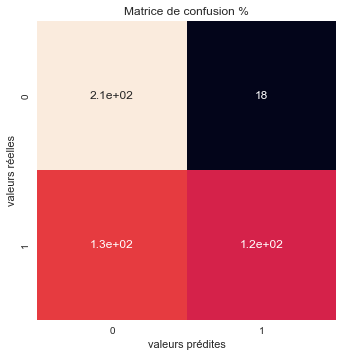

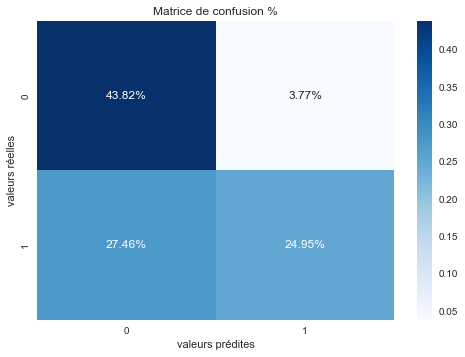

In [41]:
#Matrice de confusion
conf = metrics.confusion_matrix(val_label,pred_labels)
conf
sns.heatmap(conf, square=True, annot=True, cbar=False)
        #, xticklabels=list(iris.target_names)
        #, yticklabels=list(iris.target_names))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion %')
plt.show()

sns.heatmap(conf/np.sum(conf), annot=True, 
        fmt='.2%', cmap='Blues')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion %')
plt.show()

Nous obtenons de bien meilleurs résultats avec le modèle de Bert

## Service cognitif Azure : Analyse de sentiment

In [ ]:
def call_kv():
    #managed_identity_client_id="29c78b11-afdb-4374-b699-4a930cba9823"
    credential = DefaultAzureCredential()
    #keyvault_credential= AzureCliCredential()
    key_client = SecretClient(vault_url="https://kv-dev1-weu-001.vault.azure.net/",
                           credential=credential)
    secret = key_client.get_secret("scg")
    key = key_client.get_secret("endptscg")
    print(f"Secret value is {key.value}")
    return secret, key

In [ ]:
from azure.identity import ClientSecretCredential

def get_authentication(tenant_id, client_id, client_secret, endpoint_kv, secret_name_cg):
    try:

        credential = ClientSecretCredential(
            tenant_id=tenant_id,
            client_id=client_id,
            client_secret=client_secret
        )
        # authentication to keyvault
        secret_client = SecretClient(vault_url=endpoint_kv, credential=credential)
        # retrieve secret in keyvault
        secret = secret_client.get_secret(secret_name_cg)

        ## connect to service text analyze
        key_credential = AzureKeyCredential(secret.value)
        return key_credential
    except Exception as e:
        print("error authentication ",e)

In [ ]:
SECRET_NAME_CG = os.getenv('SECRET_NAME_CG')
ENDPOINT_KV = os.environ.get('ENDPOINT_KV')
TENANT_ID = os.getenv('TENANT_ID')
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

# authentication to get secret to connect to service cognitive azure
cog_key = get_authentication(TENANT_ID, CLIENT_ID, CLIENT_SECRET, ENDPOINT_KV, SECRET_NAME_CG)
cog_endpoint = os.getenv('ENDPOINT_CG')

In [99]:
import os
from azure.ai.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

In [100]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [101]:
def azure_cg(text, score):
    documents = []
    documents.append(text)
    response = client.analyze_sentiment(documents=documents)[0]
    if score == 1:
        return response.confidence_scores.positive
    elif score == 2:
        return response.confidence_scores.neutral
    elif score == 3:
        return response.confidence_scores.negative

In [102]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                    tweet_lemma_join target_lib  
0  know sphincter oddi dysfunction pls send link ...   Negative  
1            not lookin good Mr. Sun not lookin good   Negative

In [153]:
df["cg_positive"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 1))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [154]:
gc.collect()

51875

In [155]:
df.head(2)

target    identity                          date    username  \
0       0  2063963976  Sun Jun 07 04:45:03 PDT 2009   Oh2BeTall   
1       0  2018659971  Wed Jun 03 10:18:42 PDT 2009  kawtreenah   

                                               tweet  \
0  @drallenlubell do know anything about sphincte...   
1  its not lookin good Mr. Sun, its not lookin good    

                                         tweet_clean  \
0  (know, sphincter, oddi, dysfunction, pls, send...   
1   (not, lookin, good, Mr., Sun, not, lookin, good)   

                                         tweet_lemma  \
0  [know, sphincter, oddi, dysfunction, pls, send...   
1   [not, lookin, good, Mr., Sun, not, lookin, good]   

                                    tweet_lemma_join target_lib  cg_positive  \
0  know sphincter oddi dysfunction pls send link ...   Negative         0.01   
1            not lookin good Mr. Sun not lookin good   Negative         0.01   

   cg_neutral  cg_negative  
0        0.06         0.93  
1        0.01         0.98

In [156]:
df["cg_neutral"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 2))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [157]:
df["cg_neutral"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 2))
df["cg_negative"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 3))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [198]:
# df.to_csv("output/sample_cg.csv") >> sur tweet_lemma_join
# df.to_csv("output/sample_cg_v2.csv") # sur tweet

In [5]:
df = pd.read_csv("output/sample_cg_v2.csv")

In [7]:
del df["Unnamed: 0"]

In [8]:
gc.collect()

21

In [6]:
df.tail(3)

Unnamed: 0  target    identity                          date  \
1586        1597     1.0  1694091879  Mon May 04 01:02:50 PDT 2009   
1587        1598     1.0  1978674036  Sun May 31 00:05:41 PDT 2009   
1588        1599     1.0  1686803025  Sun May 03 06:49:31 PDT 2009   

             username                                              tweet  \
1586           SDoT84                                I am following Mya    
1587  chellebelle12xo  closed my phone on my finger  and it hurt like...   
1588    KyngDyngalyng  I can't wait until tomorrow...breakfast,car ri...   

                                            tweet_clean  \
1586                                     following Mya    
1587  closed phone finger hurt like bitch lol going ...   
1588  n't wait tomorrow breakfast car riding massage...   

                                            tweet_lemma  \
1586                                  ['follow', 'Mya']   
1587  ['closed', 'phone', 'finger', 'hurt', 'like', ...   
1588  ['not', 'wait', 'tomorrow', 'breakfast', 'car'...   

                                       tweet_lemma_join target_lib  \
1586                                         follow Mya   Positive   
1587  closed phone finger hurt like bitch lol go bed...   Positive   
1588  not wait tomorrow breakfast car ride massage g...   Positive   

      cg_positive  cg_neutral  cg_negative  
1586         0.02        0.95         0.03  
1587         0.38        0.10         0.52  
1588         0.77        0.20         0.03

Nous modifions la valeur 4 à 1 afin que ce soit plus pratique avec l'utilisation des algorithmes. 1 = tweet positif et 0 tweet negatif

In [111]:
df2 = df.copy()

In [175]:
df['target'] = df['target'].map({0:0,
                             pd.NaN:1},
                             na_action=None)

AttributeError: module 'pandas' has no attribute 'NaN'

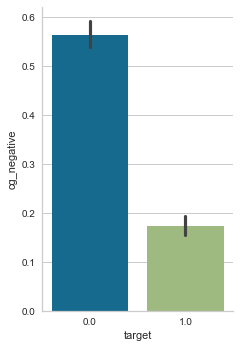

In [177]:
sns.catplot(x="target", y="cg_negative",
                data=df, kind="bar",
                 aspect=.7)

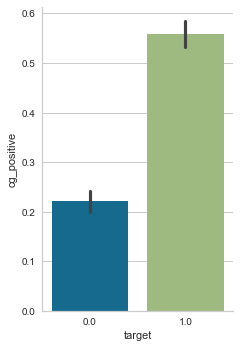

In [178]:
sns.catplot(x="target", y="cg_positive",
                data=df, kind="bar",
                 aspect=.7)



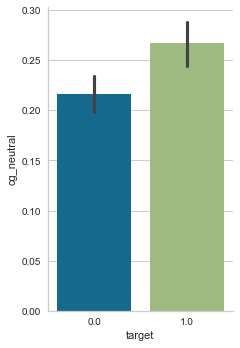

In [179]:
sns.catplot(x="target", y="cg_neutral",
                data=df, kind="bar",
                 aspect=.7)

### Modèle Simple : Regression logistique VS RandomForest

Nous séparons notre jeu de données en train et en test

In [10]:
def pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    X=data2[["cg_positive", "cg_neutral", "cg_negative"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

Nous voulons détecter les commentaires négéatifs pour pouvoir agir. Nous allons créer une nouvelle métrique dans laquelle nous allons donc accentuer la non détection des commentaires négatifs.

Nous testons deux méthodes : Regression logistique et l'arbre de decision : Random forest

Pour cela, nous utilisons Hyperopt pour choisir les meilleures paramètres possibles

In [24]:
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
# fonction pour diviser le dataframe en training set
def step1_ech(df):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

####score pour fonction metier >> on veut detecter les commentaires negatives afin de pouvoir agir, nous accentuons donc le poids pour les Faux negatifs.
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []
feat_imp_df = pd.DataFrame()
feat_imp_df_history = []


###creation de fonction pour le tuning des hyperparamètres
def objective(params, X, y):
    gc.collect()
    print("------------------------------------------------")
    print("--------------params : ", params)
    #del params['type']
    classifier_type = params['type']
    #maxd=params['max_depthg']
    #del params['max_depthg']
    del params['type']
    
    ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
        
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    feat_imp_df = pd.DataFrame()

    auc_fold=[]
    metier_fold=[]
    cv = StratifiedKFold(n_splits=3)
    i=1
    t0 = time.time()
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                #standardisation
        std_scale = StandardScaler().fit(X_train)
        X_train = std_scale.fit_transform(X_train)
        clf.fit(X_train, y_train)  
            
        y_prob = clf.predict_proba(X_test)[:,1] 
                
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
        y_pred = np.where(y_prob > 0.5, 1, 0) 
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        metier_c=fmetric_metier(y_test, y_pred)
        auc_fold.append(roc_auc)
        metier_fold.append(metier_c)
        print(f'For fold {i}:')
        print(f'AUC: {roc_auc}')
        print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
        print(f'score métier:{metier_c}')
        fold_importance_df = pd.DataFrame()
        if (classifier_type != 'logreg'):
            fold_importance_df["classifier_type"] = classifier_type
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            if len(feat_imp_df)>0:
                feat_imp_df = pd.concat([feat_imp_df, fold_importance_df], axis=0)
            else:
                feat_imp_df = fold_importance_df
                feat_imp_df_history.append(feat_imp_df)
        gc.collect()
        i+=1
        
    time_res=time.time() - t0
    auc_m=np.mean(auc_fold)
    metier=np.mean(metier_fold)
    print("metric auc moyenne :", auc_m)
    print("taux metier moyen :", metier)
    print("temps calcul :", time_res)

    if len(best_metric_history_n)>0:
        best_metric = max(best_metric_history_n)
    else:
        best_metric=auc_m

    print("best_metric : ", best_metric)
    if auc_m > best_metric:
        best_metric=auc_m

    metric_history.append({'classifier_type':classifier_type, 'auc':auc_m,'metier':metier, 'time':time_res, 'params':params})
    best_metric_history_n.append(best_metric)

    #Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': 1-auc_m, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'rf',
        'max_depth': hp.choice('max_depth', range(3,10)),
        'n_estimators': hp.choice('n_estimators', range(100,300)),#nb d'arbres dans la forêt
        'max_features': hp.choice('max_features', range(1, 3)),#nb de variables max pour diviser un noeud
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1,0.4), #nb de points de données placées dans un noeud avec qu'il soit divisé
        'min_samples_split': hp.choice('min_samples_split', range(2,12)) #nb minimal de points de données autorisées dans un noeud de feuille
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
        #bootstrap > avec ou sans remplacement
    },
    {
        'type': 'logreg',
        'C': hp.uniform('LR_C', 0.1,1.0), # force de la penalité
        'solver': hp.choice('solver', ['liblinear']),#, 'lbfgs'
        'penalty' : hp.choice('penalty', ['l1','l2'])
    }
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    scores = []
    i=0
    print("------------------------------------------")
    ###hyperopt tuning
    with mlflow.start_run():
            best_result = fmin(
                                partial(objective, 
                                        X=X_train, 
                                        y=y_train),
                                    space=search_space,
                                    algo=tpe.suggest,
                                    max_evals=10
                                    #trials=SparkTrials()
            )
    gc.collect()
    scores.append(best_result)
    return np.array(scores)


def SearchModel(df, target):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test=step1_ech(df)
    result=score_model(X_train, y_train)
    return result, X_train, y_train, X_test, y_test

In [25]:
result, X_train, y_train, X_test, y_test = SearchModel(df, "target")

------------------------------------------
------------------------------------------------      
--------------params :                                
{'C': 0.23355134504657385, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                
0.1417789757412399                                    
For fold 1:                                           
AUC: 0.7455655713870312                               
f1-score: 0.7614213197969544                          
score métier:0.1417789757412399                       
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                
0.20458221024258758                                   
For fold 2:                                           
AUC: 0.7182175050886885                               
f1-score: 0.7664399092970521                          
score métier:0.20458221024258758                      
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                
0.15864864864864864                                   
For fold 3:                                           
AUC: 0.7305555555555555                               
f1-score: 0.7543424317617866                          
score métier:0.15864864864864864                      
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                  
0.7314462106770918                                    
taux metier moyen :                                   
0.1683366115441587                                    
temps calcul :                                        
0.8252496719360352                                    
best_metric :                                         
0.7314462106770918                                    
------------------------------------------------                                
--------------params :                                                          
{'C': 0.6996001358561512, 'penalty': 'l1', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                          
0.08436657681940701                                                             
For fold 1:                                                                     
AUC: 0.7412038383250945                                                

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.1293800539083558                                                              
For fold 2:                                                                     
AUC: 0.7410875254434429                                                         
f1-score: 0.7473684210526316                                                    
score métier:0.1293800539083558                                                 
 10%|█         | 1/10 [00:01<00:09,  1.09s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.09945945945945946                                                             
For fold 3:                                                                     
AUC: 0.7005847953216374                                                         
f1-score: 0.6626506024096386                                                    
score métier:0.09945945945945946                                                
 10%|█         | 1/10 [00:02<00:09,  1.09s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                            
0.7276253863633917                                                              
taux metier moyen :                                                             
0.10440203006240743                                                             
temps calcul :                                                                  
1.0384292602539062                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.2250601624134342, 'min_samples_split': 2, 'n_estimators': 282, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.1657681940700809                                                              
For fold 2:                                                                     
AUC: 0.6787292817679558                                                         
f1-score: 0.6909090909090909                                                    
score métier:0.1657681940700809                                                 
 20%|██        | 2/10 [00:04<00:09,  1.21s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.13648648648648648                                                             
For fold 3:                                                                     
AUC: 0.6745614035087719                                                         
f1-score: 0.6591549295774648                                                    
score métier:0.13648648648648648                                                
 20%|██        | 2/10 [00:05<00:09,  1.21s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6752318180349585                                                              
taux metier moyen :                                                             
0.14765182972730143                                                             
temps calcul :                                                                  
3.1004068851470947                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 0.2227807505469715, 'min_samples_split': 5, 'n_estimators': 237, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 30%|███       | 3/10 [00:07<00:15,  2.22s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 30%|███       | 3/10 [00:08<00:15,  2.22s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
2.4285216331481934                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 0.2082399000033839, 'min_samples_split': 9, 'n_estimators': 134, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.14150943396226415                                                             
For fold 2:                                                                     
AUC: 0.6854318115731317                                                         
f1-score: 0.6794520547945206                                                    
score métier:0.14150943396226415                                                
 40%|████      | 4/10 [00:09<00:14,  2.43s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.09027027027027029                                                             
For fold 3:                                                                     
AUC: 0.6646198830409357                                                         
f1-score: 0.588235294117647                                                     
score métier:0.09027027027027029                                                
 40%|████      | 4/10 [00:10<00:14,  2.43s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6748451854005794                                                              
taux metier moyen :                                                             
0.0983740074306112                                                              
temps calcul :                                                                  
1.4786481857299805                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.1776268410539253, 'min_samples_split': 3, 'n_estimators': 214, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 50%|█████     | 5/10 [00:11<00:10,  2.18s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 50%|█████     | 5/10 [00:12<00:10,  2.18s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
1.9182014465332031                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.13777374837122203, 'min_samples_split': 3, 'n_estimators': 162, 'type': 'rf'}
FULL Métrique Métier :                                

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.09218328840970351                                                             
For fold 2:                                                                     
AUC: 0.6858098284384995                                                         
f1-score: 0.628930817610063                                                     
score métier:0.09218328840970351                                                
 60%|██████    | 6/10 [00:13<00:08,  2.20s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.061621621621621624                                                            
For fold 3:                                                                     
AUC: 0.6090643274853801                                                         
f1-score: 0.4126984126984127                                                    
score métier:0.061621621621621624                                               
 60%|██████    | 6/10 [00:14<00:08,  2.20s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.6598305924418165                                                              
taux metier moyen :                                                             
0.07417935455671305                                                             
temps calcul :                                                                  
1.5849978923797607                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'C': 0.2986530401866129, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                          
0.1417789757412399       

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.20458221024258758                                                             
For fold 2:                                                                     
AUC: 0.7182175050886885                                                         
f1-score: 0.7664399092970521                                                    
score métier:0.20458221024258758                                                
 70%|███████   | 7/10 [00:14<00:06,  2.08s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.1562162162162162                                                              
For fold 3:                                                                     
AUC: 0.7333333333333334                                                         
f1-score: 0.7562189054726367                                                    
score métier:0.1562162162162162                                                 
 70%|███████   | 7/10 [00:15<00:06,  2.08s/trial, best loss: 0.2685537893229082]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                            
0.7323721366030177                                                              
taux metier moyen :                                                             
0.16752580073334788                                                             
temps calcul :                                                                  
0.6945886611938477                                                              
best_metric :                                                                   
0.7314462106770918                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129, 'type': 'rf'}
FULL Métrique Métier :                                  

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 80%|████████  | 8/10 [00:16<00:03,  1.71s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.051351351351351354                                                            
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.051351351351351354                                               
 80%|████████  | 8/10 [00:16<00:03,  1.71s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.05125907578737767                                                             
temps calcul :                                                                  
1.2763583660125732                                                              
best_metric :                                                                   
0.7323721366030177                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.3379142387144206, 'min_samples_split': 5, 'n_estimators': 136, 'type': 'rf'}
FULL Métrique Métier :                                 

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.4390835579514825                                                              
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6773618538324421                                                    
score métier:0.4390835579514825                                                 
 90%|█████████ | 9/10 [00:17<00:01,  1.66s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.43783783783783786                                                             
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6785714285714285                                                    
score métier:0.43783783783783786                                                
 90%|█████████ | 9/10 [00:18<00:01,  1.66s/trial, best loss: 0.2676278633969823]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.438668317913601                                                               
temps calcul :                                                                  
1.2330029010772705                                                              
best_metric :                                                                   
0.7323721366030177                                                              
100%|██████████| 10/10 [00:18<00:00,  1.83s/trial, best loss: 0.2676278633969823]


In [21]:
metric_history

[{'classifier_type': 'rf',
  'auc': 0.546832358674464,
  'metier': 0.24802675991355239,
  'time': 1.4449489116668701,
  'params': {'max_depth': 5,
   'max_features': 1,
   'min_samples_leaf': 0.27236264301515356,
   'min_samples_split': 7,
   'n_estimators': 109}},
 {'classifier_type': 'rf',
  'auc': 0.6696439533456108,
  'metier': 0.07031737937398315,
  'time': 2.717998743057251,
  'params': {'max_depth': 6,
   'max_features': 1,
   'min_samples_leaf': 0.11248992486751819,
   'min_samples_split': 6,
   'n_estimators': 286}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.438668317913601,
  'time': 2.2539877891540527,
  'params': {'max_depth': 6,
   'max_features': 2,
   'min_samples_leaf': 0.3965926573794545,
   'min_samples_split': 4,
   'n_estimators': 130}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.438668317913601,
  'time': 1.783200740814209,
  'params': {'max_depth': 9,
   'max_features': 2,
   'min_samples_leaf': 0.3471644892065293,
   'min_samples_split': 

In [26]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()

In [27]:
df_metrics_history

index classifier_type       auc    metier      time  \
0      0          logreg  0.731446  0.168337  0.825250   
1      1          logreg  0.727625  0.104402  1.038429   
2      2              rf  0.675232  0.147652  3.100407   
3      3              rf  0.500000  0.051259  2.428522   
4      4              rf  0.674845  0.098374  1.478648   
5      5              rf  0.500000  0.051259  1.918201   
6      6              rf  0.659831  0.074179  1.584998   
7      7          logreg  0.732372  0.167526  0.694589   
8      8              rf  0.500000  0.051259  1.276358   
9      9              rf  0.500000  0.438668  1.233003   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

In [28]:
train_graph=df_metrics_history.copy()

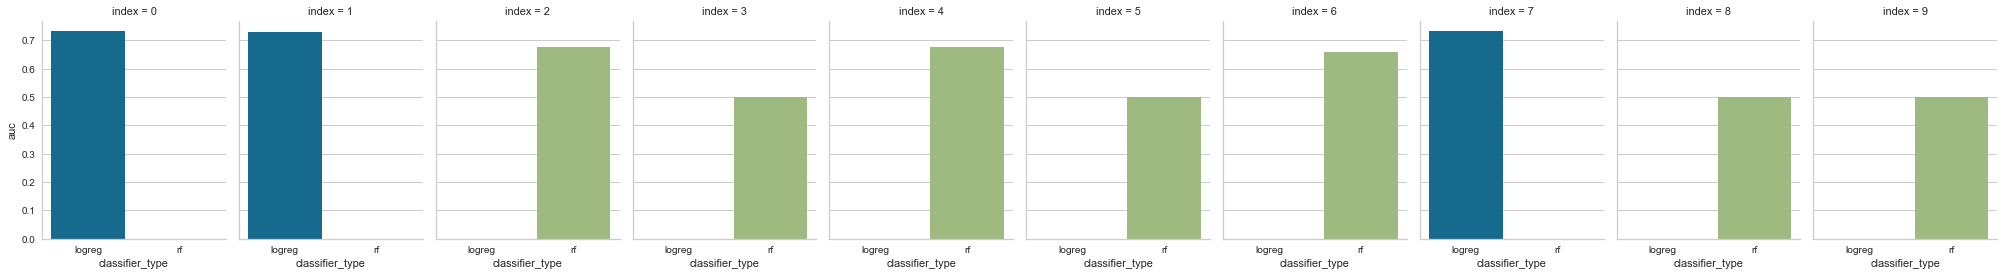

In [29]:
sns.catplot(x="classifier_type", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)

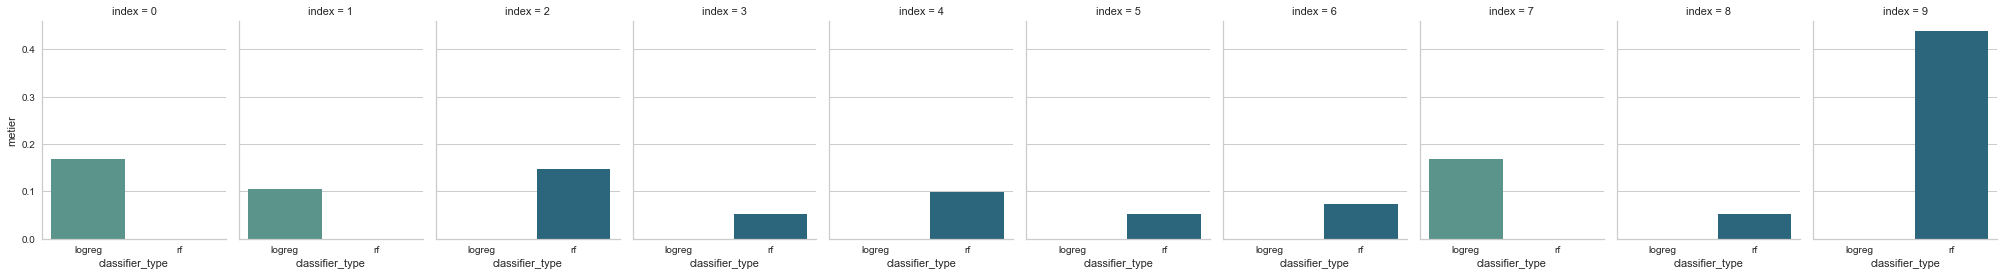

In [30]:
sns.catplot(x="classifier_type", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)

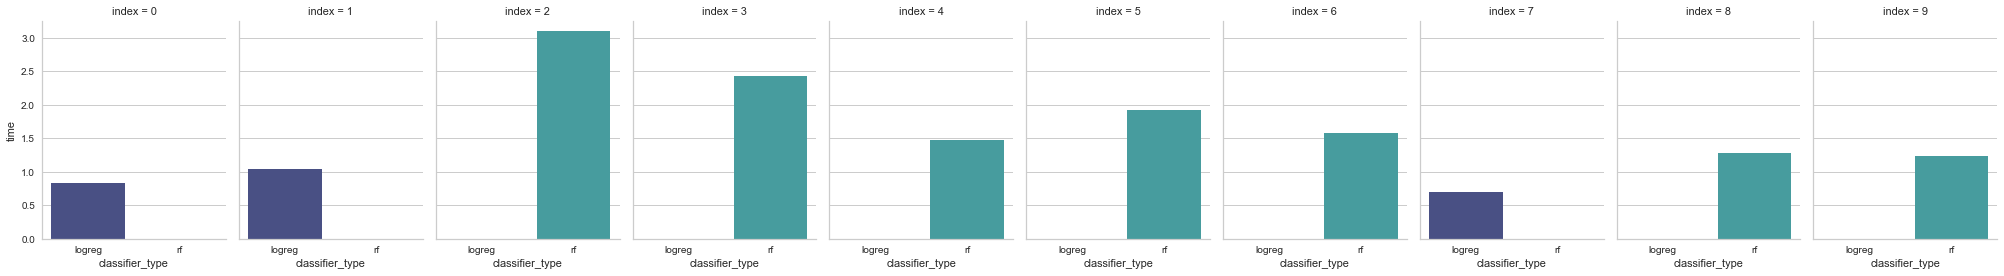

In [31]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [32]:
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_prob, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #

def result_compare_model(df_best_score_history):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        res = compare_best_model(i, item.classifier_type, item.params, X_train, y_train, X_test, y_test)
        all_bestscore_history.append(res)
        i=i+1
    return pd.DataFrame(all_bestscore_history)

def compare_best_model(i,classifier_type, params, X_train, y_train, X_test, y_test):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    
    t0 = time.time()
             
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:,1] 
    
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    metier_c=fmetric_metier(y_test, y_pred)
    pipeline_training_metrics(y_pred, y_test)
    time_res=time.time() - t0
    return {'classifier_type':classifier_type, 'score':roc_auc,'metier':metier_c,'time': time_res, 'params':params}

In [40]:
df_metrics_history

index classifier_type       auc    metier      time  \
0      0          logreg  0.731446  0.168337  0.825250   
1      1          logreg  0.727625  0.104402  1.038429   
2      2              rf  0.675232  0.147652  3.100407   
3      3              rf  0.500000  0.051259  2.428522   
4      4              rf  0.674845  0.098374  1.478648   
5      5              rf  0.500000  0.051259  1.918201   
6      6              rf  0.659831  0.074179  1.584998   
7      7          logreg  0.732372  0.167526  0.694589   
8      8              rf  0.500000  0.051259  1.276358   
9      9              rf  0.500000  0.438668  1.233003   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

{'C': 0.23355134504657385, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


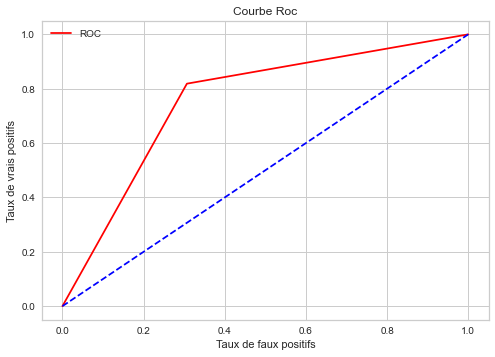

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


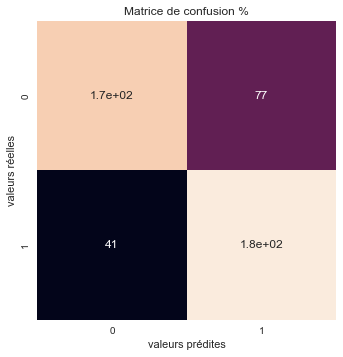

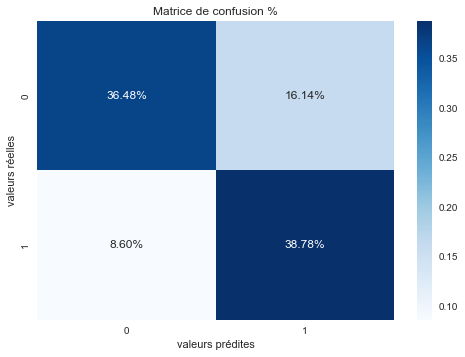


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'C': 0.6996001358561512, 'penalty': 'l1', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


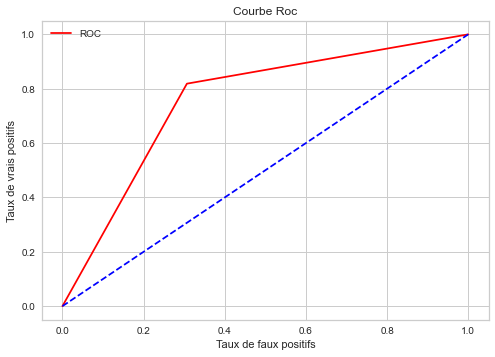

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


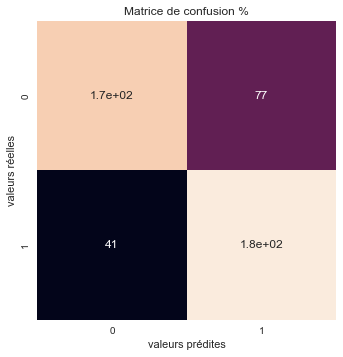

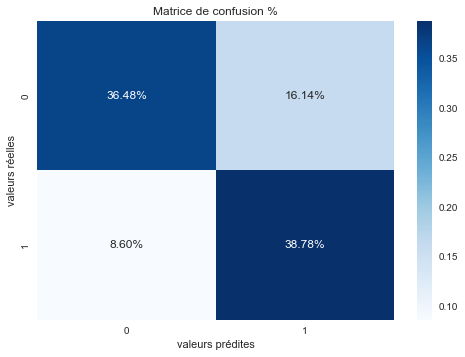


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.2250601624134342, 'min_samples_split': 2, 'n_estimators': 282}
FULL Métrique Métier :  0.1387840670859539
0.753922363642774


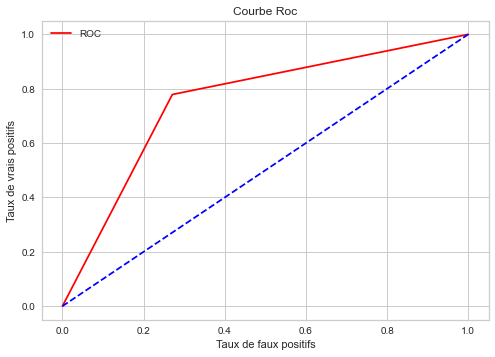

FULL Métrique Métier :  0.1387840670859539
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


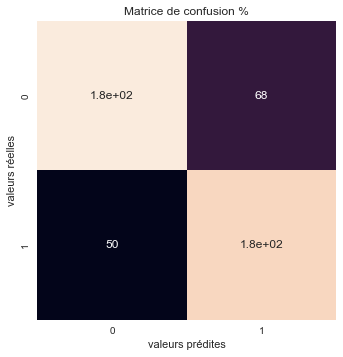

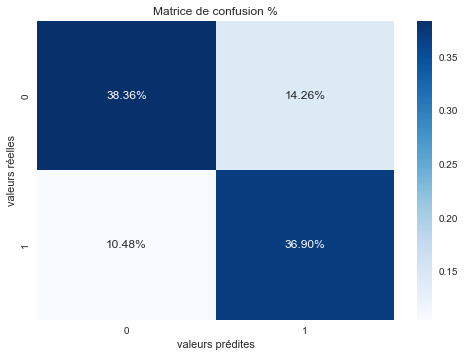


Sur le jeu de test auc : 0.754

Sur le jeu de test f1_score : 0.749

Sur le jeu de test precision : 0.721

Sur le jeu de test recall : 0.779
{'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 0.2227807505469715, 'min_samples_split': 5, 'n_estimators': 237}
FULL Métrique Métier :  0.13354297693920336
0.755473680499242


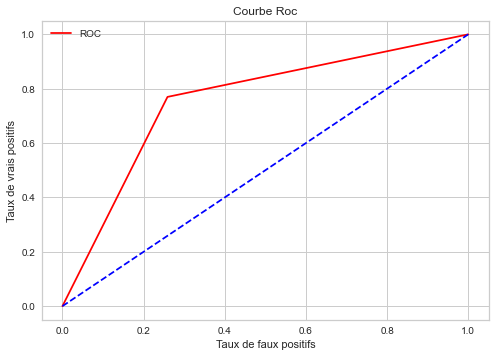

FULL Métrique Métier :  0.13354297693920336
Mean Absolute Error: 0.24528301886792453
Mean Squared Error: 0.24528301886792453
Root Mean Squared Error: 0.4952605565436486


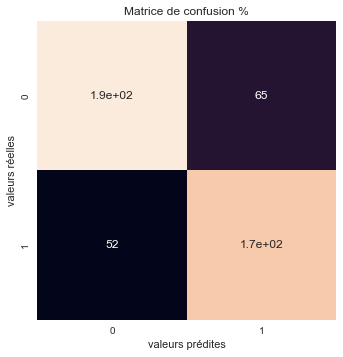

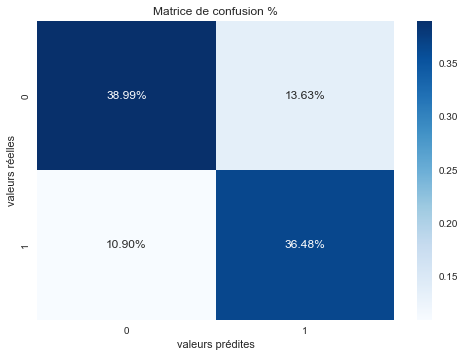


Sur le jeu de test auc : 0.755

Sur le jeu de test f1_score : 0.748

Sur le jeu de test precision : 0.728

Sur le jeu de test recall : 0.770
{'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 0.2082399000033839, 'min_samples_split': 9, 'n_estimators': 134}
FULL Métrique Métier :  0.14067085953878405
0.7519303317702641


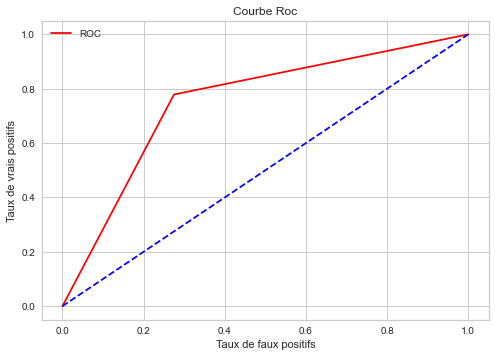

FULL Métrique Métier :  0.14067085953878405
Mean Absolute Error: 0.24947589098532494
Mean Squared Error: 0.24947589098532494
Root Mean Squared Error: 0.49947561600675255


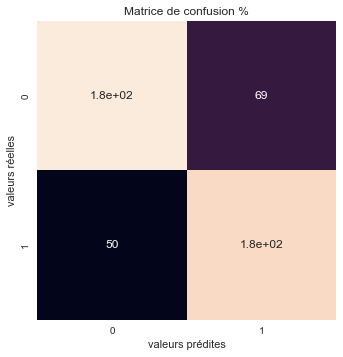

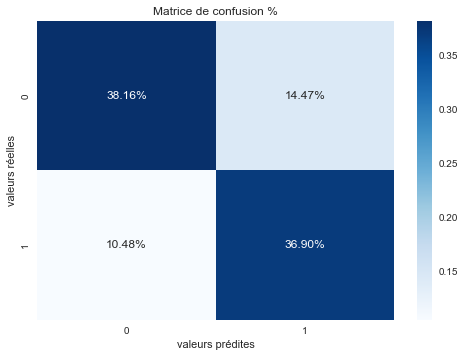


Sur le jeu de test auc : 0.752

Sur le jeu de test f1_score : 0.747

Sur le jeu de test precision : 0.718

Sur le jeu de test recall : 0.779
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.1776268410539253, 'min_samples_split': 3, 'n_estimators': 214}
FULL Métrique Métier :  0.13731656184486374
0.7514896167542221


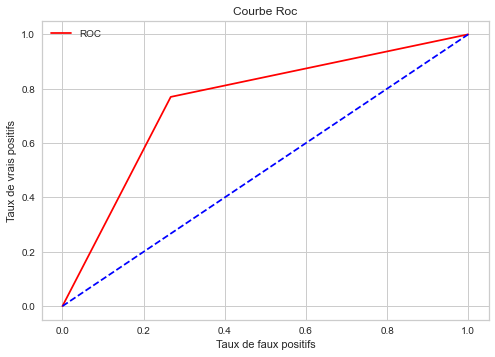

FULL Métrique Métier :  0.13731656184486374
Mean Absolute Error: 0.24947589098532494
Mean Squared Error: 0.24947589098532494
Root Mean Squared Error: 0.49947561600675255


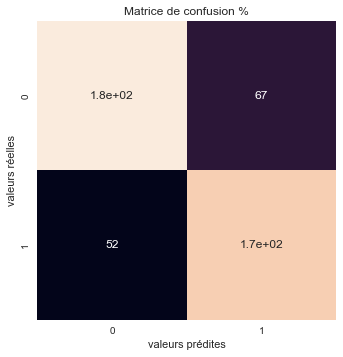

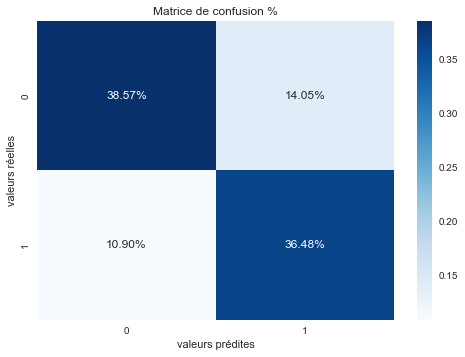


Sur le jeu de test auc : 0.751

Sur le jeu de test f1_score : 0.745

Sur le jeu de test precision : 0.722

Sur le jeu de test recall : 0.770
{'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 0.13777374837122203, 'min_samples_split': 3, 'n_estimators': 162}
FULL Métrique Métier :  0.14821802935010484
0.7439622042802242


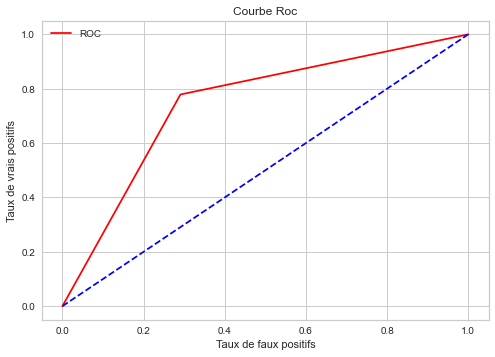

FULL Métrique Métier :  0.14821802935010484
Mean Absolute Error: 0.2578616352201258
Mean Squared Error: 0.2578616352201258
Root Mean Squared Error: 0.5078007830046403


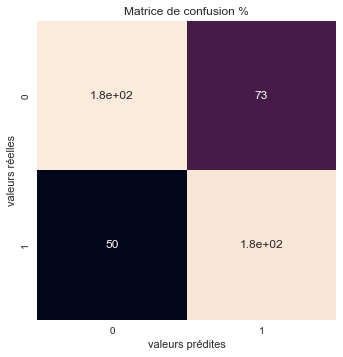

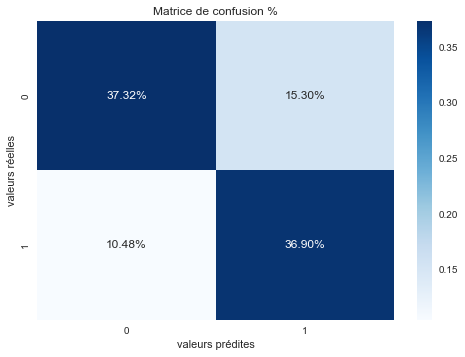


Sur le jeu de test auc : 0.744

Sur le jeu de test f1_score : 0.741

Sur le jeu de test precision : 0.707

Sur le jeu de test recall : 0.779
{'C': 0.2986530401866129, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


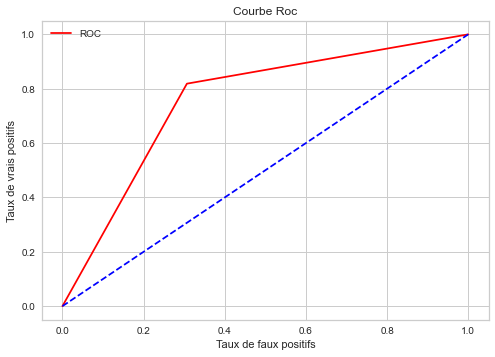

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


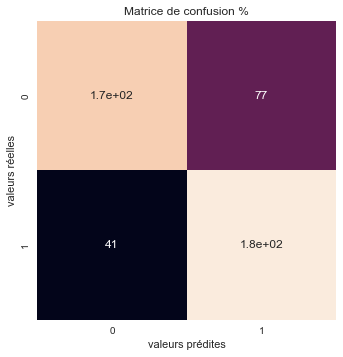

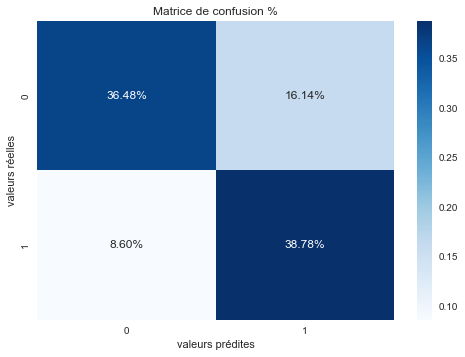


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129}
FULL Métrique Métier :  0.12515723270440252
0.7543718929591369


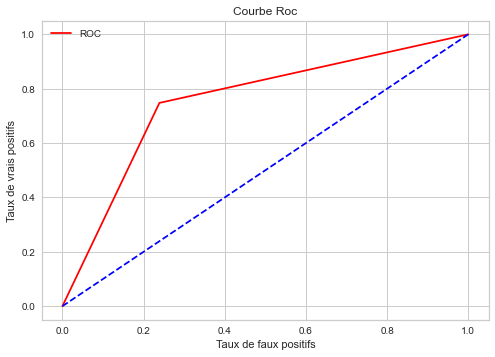

FULL Métrique Métier :  0.12515723270440252
Mean Absolute Error: 0.24528301886792453
Mean Squared Error: 0.24528301886792453
Root Mean Squared Error: 0.4952605565436486


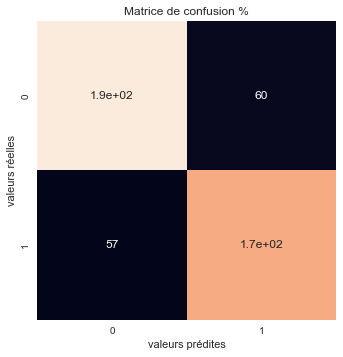

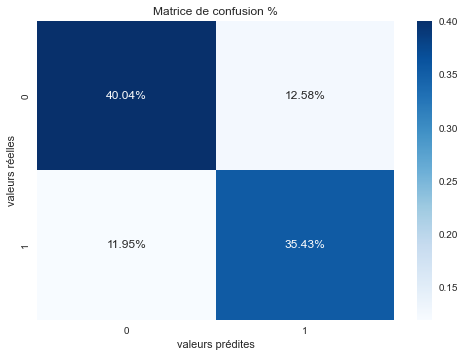


Sur le jeu de test auc : 0.754

Sur le jeu de test f1_score : 0.743

Sur le jeu de test precision : 0.738

Sur le jeu de test recall : 0.748
{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.3379142387144206, 'min_samples_split': 5, 'n_estimators': 136}
FULL Métrique Métier :  0.47358490566037736
0.5


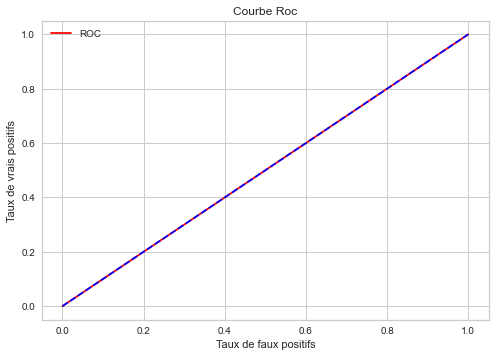

FULL Métrique Métier :  0.47358490566037736
Mean Absolute Error: 0.5262054507337526
Mean Squared Error: 0.5262054507337526
Root Mean Squared Error: 0.7254002003954456


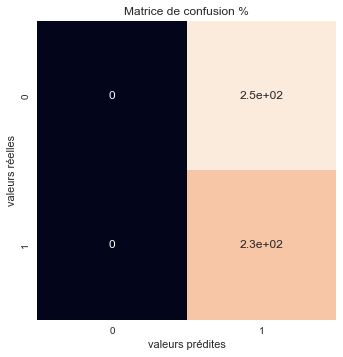

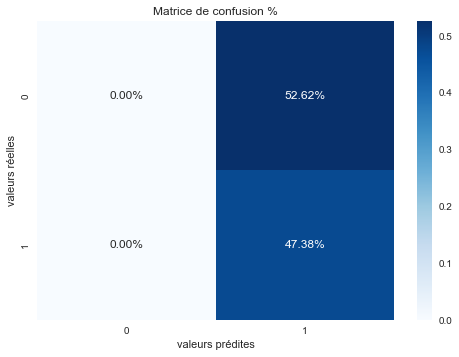


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.643

Sur le jeu de test precision : 0.474

Sur le jeu de test recall : 1.000


In [33]:
final_result=result_compare_model(df_metrics_history)

In [34]:
final_result = final_result.reset_index()

In [35]:

data=final_result.copy()



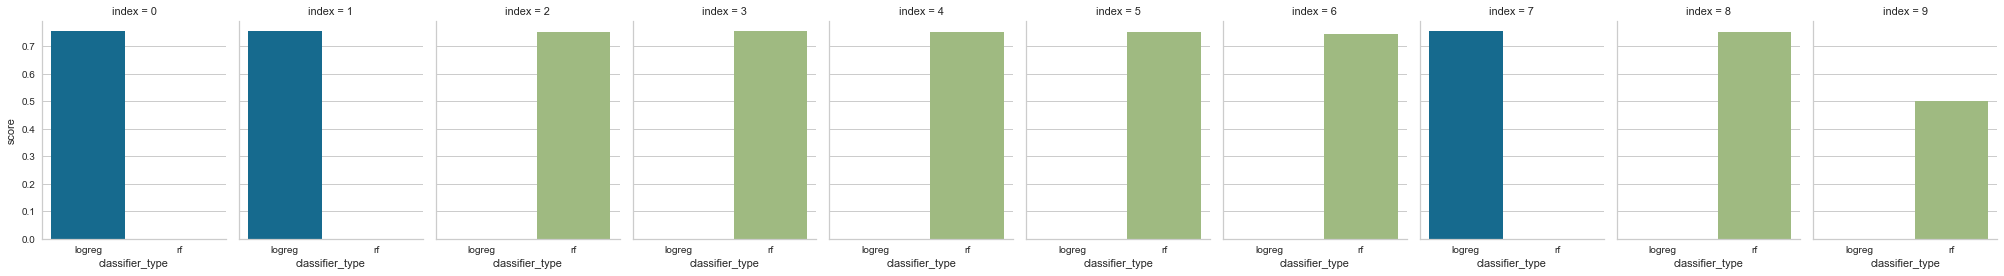

In [36]:
sns.catplot(x="classifier_type", y="score",
                col="index",
                data=data, kind="bar",
                height=4, aspect=.7)

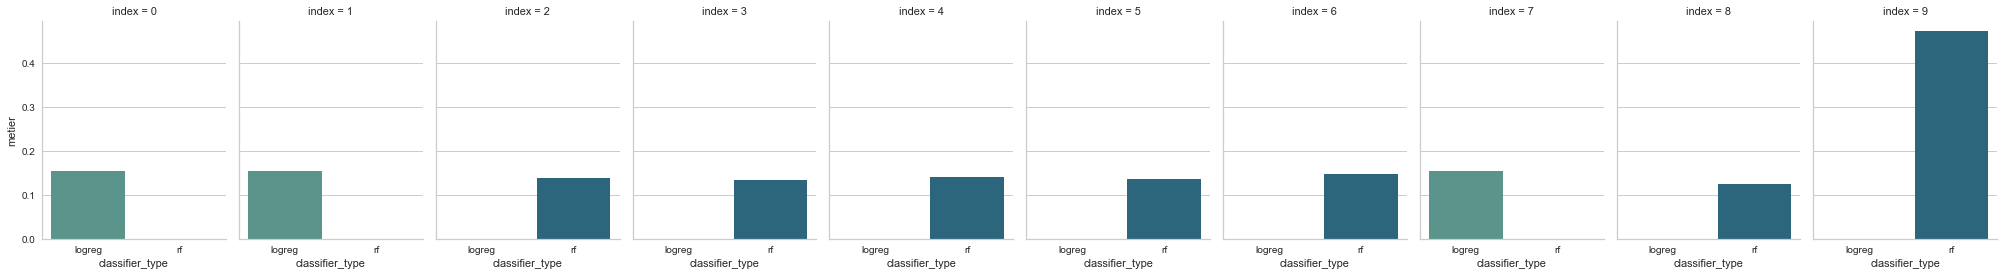

In [37]:
sns.catplot(x="classifier_type", y="metier",
                col="index",
                data=data, kind="bar",palette="crest",
                height=4, aspect=.7)

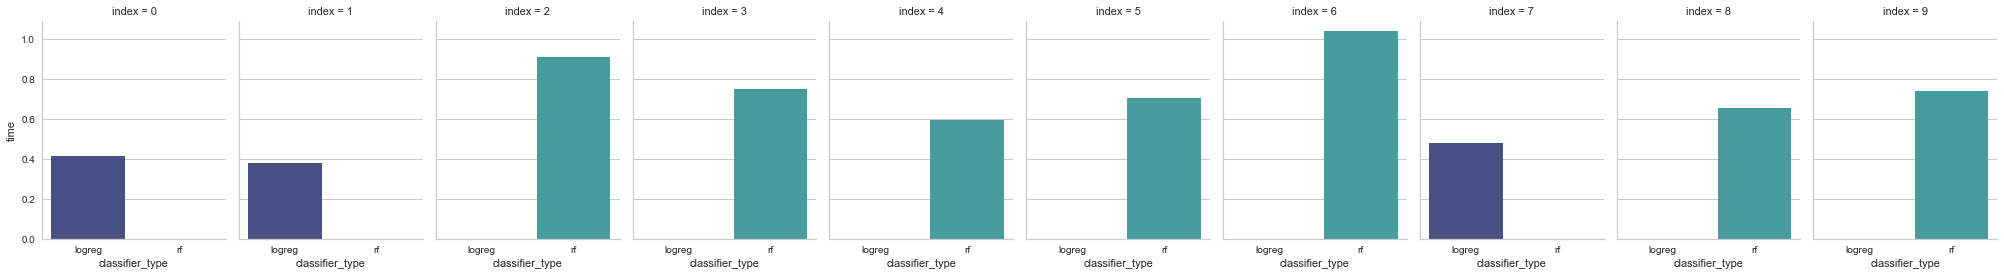

In [38]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=data, kind="bar",palette="mako",
                height=4, aspect=.7)

In [39]:
final_result

index classifier_type     score    metier      time  \
0      0          logreg  0.755906  0.153878  0.415999   
1      1          logreg  0.755906  0.153878  0.380997   
2      2              rf  0.753922  0.138784  0.910601   
3      3              rf  0.755474  0.133543  0.748651   
4      4              rf  0.751930  0.140671  0.595245   
5      5              rf  0.751490  0.137317  0.704485   
6      6              rf  0.743962  0.148218  1.039997   
7      7          logreg  0.755906  0.153878  0.481996   
8      8              rf  0.754372  0.125157  0.655226   
9      9              rf  0.500000  0.473585  0.738204   

                                              params  
0  {'C': 0.23355134504657385, 'penalty': 'l2', 's...  
1  {'C': 0.6996001358561512, 'penalty': 'l1', 'so...  
2  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...  
4  {'max_depth': 4, 'max_features': 1, 'min_sampl...  
5  {'max_depth': 7, 'max_features': 2, 'min_sampl...  
6  {'max_depth': 8, 'max_features': 1, 'min_sampl...  
7  {'C': 0.2986530401866129, 'penalty': 'l2', 'so...  
8  {'max_depth': 8, 'max_features': 2, 'min_sampl...  
9  {'max_depth': 7, 'max_features': 1, 'min_sampl...

### Choix :  Random forest (numéro 8)

In [45]:
import joblib

def result_save_model(df_best_score_history, num_choice):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        if item.index==num_choice:
            save_best_model(i, item.classifier_type, item.params, X_train, y_train)

def save_best_model(i,classifier_type, params, X_train, y_train):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0    
    clf.fit(X_train, y_train)
    joblib.dump(clf, "output/models/method1/my_random_forest.pkl")
    print("ok")

In [46]:
result_save_model(final_result, 8)

{'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 0.309764679582077, 'min_samples_split': 4, 'n_estimators': 129}
ok


In [48]:
X_train

cg_positive  cg_neutral  cg_negative
53           0.43        0.06         0.51
486          0.07        0.01         0.92
142          0.01        0.14         0.84
852          0.14        0.78         0.08
1137         0.55        0.44         0.01
...           ...         ...          ...
924          0.66        0.32         0.03
1247         0.98        0.00         0.02
271          0.01        0.17         0.82
474          0.58        0.06         0.35
1379         0.13        0.83         0.05

[1112 rows x 3 columns]

In [51]:
##

#import joblib
#from sklearn.ensemble import RandomForestClassifier


# save
#joblib.dump(rf, "my_random_forest.joblib")

# load
loaded_rf = joblib.load("output/models/method1/my_random_forest.pkl")
#loaded_rf.predict(X)

In [58]:
d = {'cg_positive': [0.06], 'cg_neutral': [0.22], 'cg_negative': [0.72]}

In [59]:
Xd= pd.DataFrame(d)

In [60]:
y_hat = loaded_rf.predict(Xd)

In [61]:
y_hat

array([0.])